In this notebook we are going to analyze, process and build a machine learning model from loan application dataset. 
The aim of this project is to build a model that could predict whether a borrower defaulted or not. There are 2 target values that is a good borrower (1) and a bad borrower (0).

# Importing Packages and Data

First lets import the data and make a back up file. Also import pandas and numpy. Notice that there is a lot of columns, so I change pandas settings to include all columns so i don't miss any variable

In [1]:
import numpy as np
import pandas as pd

In [2]:
backup = pd.read_csv('loan_data.csv')
df = backup.copy()
df.head()

C:\Users\azzah\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   
2         NaN         NaN         NaN      NaN              NaN    NaN   
3         NaN         NaN         NaN      NaN              NaN    NaN   
4         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 75 columns]

In [3]:
df.shape

(466285, 75)

# Preprocessing

## Part A: Inspecting and Changing Data Type of Each Columns

First let's look at each value and it's data type. Let's inspect if any of the columns data types need to be changed.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

We could see that we need to change some column data type:
- **emp_length** data type is string, it should be in integer (number of Months)
- **term** data type is string, it should be in integer (number of Months)
- **issue_date** data type is string, it should be in date time (mmm-yy)
- **earliest_cr_line** data type is string, it should be in date time (mmm-yy)

**emp_length** tell us about how many years a customer has been employed. the data is in string so lets preprocess it into integer

In [5]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [6]:
df['emp_length_int'] = df['emp_length'].fillna('0')
df['emp_length_int'] = df['emp_length_int'].replace('< 1 year','0')
df['emp_length_int'] = df['emp_length_int'].str.extract('(\d+)').astype(int)
df['emp_length_int'].unique()

array([10,  0,  1,  3,  8,  9,  4,  5,  6,  2,  7])

**term** tell us about the number of payments on the loan. Values are in number of months, so the data should be in integer

In [7]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [8]:
df['term'] = df['term'].str.extract('(\d+)').astype(int)
df.term.unique()

array([36, 60])

**issue_d** tell us about the month which the loan was funded. This data was taken in 2017, so we will take how many month it has been since issue_d up until 2017-12-31. We will do this to **issue_d** and **earliest_cr_line**.

In [9]:
df['issue_d']=pd.to_datetime(df['issue_d'],format = '%b-%y')

In [10]:
df['issue_d_in_mnths'] =round(pd.to_numeric((pd.to_datetime('2017-12-31')-df['issue_d'])/ np.timedelta64(1,'M')))  

In [11]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [12]:
df['earliest_cr_line_in_mnths'] = round(pd.to_numeric((pd.to_datetime('2017-12-31')-df['earliest_cr_line'])/np.timedelta64(1,'M')))

In [13]:
df['earliest_cr_line_in_mnths'][df['earliest_cr_line_in_mnths']<0] = df['earliest_cr_line_in_mnths'].max()

<ipython-input-13-a5a0f4e74f79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['earliest_cr_line_in_mnths'][df['earliest_cr_line_in_mnths']<0] = df['earliest_cr_line_in_mnths'].max()


## Part B: From Categorical to Dummy Variable

In [14]:
[print(i,':', df[i].nunique()) for i in df.columns]

Unnamed: 0 : 466285
id : 466285
member_id : 466285
loan_amnt : 1352
funded_amnt : 1354
funded_amnt_inv : 9854
term : 2
int_rate : 506
installment : 55622
grade : 7
sub_grade : 35
emp_title : 205475
emp_length : 11
home_ownership : 6
annual_inc : 31901
verification_status : 3
issue_d : 91
loan_status : 9
pymnt_plan : 2
url : 466285
desc : 124436
purpose : 14
title : 63099
zip_code : 888
addr_state : 50
dti : 3997
delinq_2yrs : 24
earliest_cr_line : 664
inq_last_6mths : 28
mths_since_last_delinq : 145
mths_since_last_record : 123
open_acc : 62
pub_rec : 26
revol_bal : 58142
revol_util : 1269
total_acc : 112
initial_list_status : 2
out_prncp : 135665
out_prncp_inv : 141189
total_pymnt : 351609
total_pymnt_inv : 347659
total_rec_prncp : 172713
total_rec_int : 270249
total_rec_late_fee : 5808
recoveries : 22773
collection_recovery_fee : 20275
last_pymnt_d : 98
last_pymnt_amnt : 198194
next_pymnt_d : 100
last_credit_pull_d : 103
collections_12_mths_ex_med : 9
mths_since_last_major_derog : 16

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

After inspecting some variable below and looking at each columns the unique value, we can conclude that there is 8 columns that is a categorical variable. and that is : **grade, sub_grade, home_ownerhip, verification_status, loan_status, purpose, addr_state, initial_list_status**

In [15]:
cat = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state', 'initial_list_status']
con = [pd.get_dummies(df[i],prefix=i, prefix_sep='_') for i in cat]
dfdum = pd.concat(con, axis =1)

In [16]:
dfdum.columns.values

array(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified',
       'verification_status_Verified', 'lo

## Part C : Check and Clean Missing Value

In [17]:
df.isnull().sum()

Unnamed: 0                        0
id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
                              ...  
total_cu_tl                  466285
inq_last_12m                 466285
emp_length_int                    0
issue_d_in_mnths                  0
earliest_cr_line_in_mnths        29
Length: 78, dtype: int64

In [18]:
df['total_rev_hi_lim'].fillna(df['funded_amnt'], inplace = True)
df['total_rev_hi_lim'].isnull().sum()

0

Looking the dataset we will treat missing value in **annual_inc** by replacing it with its mean while the columns **earliest_cr_line_in_mnths**, **acc_now_delinq**,**total_acc**, **pub_rec**,**open_acc**, **inq_last_6mths**, **delinq_2yrs**, **emp_length_int** missing value will be replaced by 0

In [19]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace = True)

In [20]:
missing = ['earliest_cr_line_in_mnths','acc_now_delinq','total_acc','pub_rec','open_acc','inq_last_6mths','delinq_2yrs','emp_length_int']
df[missing] = df[missing].fillna(0)

## Part D : Inspecting Dependent Variable  Values

Because we are using Logistic Regression, so we need to classify the value into 2 categories. Good and Bad. Where Good is labeled '1' and Bad is labeled '0'

In [21]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [22]:
df.loan_status.value_counts()/df.loan_status.count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [23]:
df['dependent'] = np.where(df['loan_status'].isin(['Charged Off', 'Default','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off' ]), 0, 1)

# Data Preparation

## Part A : Splitting Data Into Train and Test

In [24]:
dfdum = dfdum.reset_index()
df = df.reset_index()

In [25]:
df = pd.merge(df,dfdum, on = 'index')

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df_input_train,df_input_test,df_target_train,df_target_test = train_test_split(df.drop('dependent',axis=1), df['dependent'])

In [28]:
df_input_train.shape

(349713, 205)

In [29]:
df_target_train.shape

(349713,)

## Part B : Preparing Train Dataset

Because this is a PD model need to be easy to understand, we need to transform all the Independent Variable into a Categorical Variable through Course Classing.
One of the method that can be use for course classing is Weight Of Evidence. Here we will calculate the Weight of Evidence of each independent variable and use it to bin them.

In [30]:
df_input_prep = df_input_train
df_target_prep = df_target_train 

### Weight of  Evidence for the Categorical Variables

In [31]:
dfprep = pd.concat([df_input_train['grade'],df_target_train],axis = 1)

In [32]:
dfprep.head()

grade  dependent
145391     D          0
392160     C          1
2469       C          1
308958     B          1
132941     B          1

In [33]:
total = dfprep.groupby(dfprep.columns.values[0], as_index=False)[dfprep.columns.values[1]].count()

In [34]:
mean = dfprep.groupby(dfprep.columns.values[0], as_index=False)[dfprep.columns.values[1]].mean()

In [35]:
dfprep = pd.merge(total, mean, on = 'grade')

In [36]:
dfprep.columns = [dfprep.columns.values[0], 'count', 'proportion_of_good']
dfprep['proportion_of_count'] = dfprep['count']/dfprep['count'].sum()

In [37]:
dfprep['n_good'] = dfprep['proportion_of_good']*dfprep['count']
dfprep['n_bad'] = (1-dfprep['proportion_of_good'])*dfprep['count']

In [38]:
dfprep['prop_n_good'] = dfprep['n_good']/dfprep['n_good'].sum() 
dfprep['prop_n_bad'] = dfprep['n_bad']/dfprep['n_bad'].sum() 

In [39]:
dfprep['WoE'] = np.log(dfprep['prop_n_good']/dfprep['prop_n_bad'])

In [40]:
dfprep

grade   count  proportion_of_good  proportion_of_count   n_good    n_bad  \
0     A   56039            0.960581             0.160243  53830.0   2209.0   
1     B  102821            0.921796             0.294015  94780.0   8041.0   
2     C   94020            0.885056             0.268849  83213.0  10807.0   
3     D   57574            0.845503             0.164632  48679.0   8895.0   
4     E   26828            0.803414             0.076714  21554.0   5274.0   
5     F    9915            0.757842             0.028352   7514.0   2401.0   
6     G    2516            0.713434             0.007194   1795.0    721.0   

   prop_n_good  prop_n_bad       WoE  
0     0.172884    0.057604  1.099028  
1     0.304402    0.209685  0.372741  
2     0.267252    0.281814 -0.053054  
3     0.156341    0.231955 -0.394505  
4     0.069224    0.137530 -0.686491  
5     0.024132    0.062611 -0.953381  
6     0.005765    0.018802 -1.182142

In [41]:
dfprep['IV'] = (dfprep['prop_n_good'] - dfprep['prop_n_bad'])*dfprep['WoE']
dfprep['IV'] = dfprep.IV.sum()
dfprep

grade   count  proportion_of_good  proportion_of_count   n_good    n_bad  \
0     A   56039            0.960581             0.160243  53830.0   2209.0   
1     B  102821            0.921796             0.294015  94780.0   8041.0   
2     C   94020            0.885056             0.268849  83213.0  10807.0   
3     D   57574            0.845503             0.164632  48679.0   8895.0   
4     E   26828            0.803414             0.076714  21554.0   5274.0   
5     F    9915            0.757842             0.028352   7514.0   2401.0   
6     G    2516            0.713434             0.007194   1795.0    721.0   

   prop_n_good  prop_n_bad       WoE       IV  
0     0.172884    0.057604  1.099028  0.29159  
1     0.304402    0.209685  0.372741  0.29159  
2     0.267252    0.281814 -0.053054  0.29159  
3     0.156341    0.231955 -0.394505  0.29159  
4     0.069224    0.137530 -0.686491  0.29159  
5     0.024132    0.062611 -0.953381  0.29159  
6     0.005765    0.018802 -1.182142  0.29159

Lets now use the weight of evidence function to all categorical variable

In [42]:
def woe(df, discrete, dependent_var_df):
    df = pd.concat([df[discrete], dependent_var_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'count', 'proportion_of_good']
    df['proportion_of_count'] = df['count']/df['count'].sum()
    df['n_good'] = df['proportion_of_good']*df['count']
    df['n_bad'] = (1-df['proportion_of_good'])*df['count']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum() 
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop=True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad'])*df['WoE']
    df['IV'] = df.IV.sum()
    return df
    

In [43]:
df_temp = woe(df_input_train, 'grade', df_target_train)
df_temp

grade   count  proportion_of_good  proportion_of_count   n_good    n_bad  \
0     G    2516            0.713434             0.007194   1795.0    721.0   
1     F    9915            0.757842             0.028352   7514.0   2401.0   
2     E   26828            0.803414             0.076714  21554.0   5274.0   
3     D   57574            0.845503             0.164632  48679.0   8895.0   
4     C   94020            0.885056             0.268849  83213.0  10807.0   
5     B  102821            0.921796             0.294015  94780.0   8041.0   
6     A   56039            0.960581             0.160243  53830.0   2209.0   

   prop_n_good  prop_n_bad       WoE       IV  
0     0.005765    0.018802 -1.182142  0.29159  
1     0.024132    0.062611 -0.953381  0.29159  
2     0.069224    0.137530 -0.686491  0.29159  
3     0.156341    0.231955 -0.394505  0.29159  
4     0.267252    0.281814 -0.053054  0.29159  
5     0.304402    0.209685  0.372741  0.29159  
6     0.172884    0.057604  1.099028  0.29159

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # a skin for matplot lib (to make it prettier)

In [45]:
def plot_by_woe(df_WoE, rotation_labels=0):
    x = np.array(df_WoE.iloc[:,0].apply(str)) #matplotlib is good with np than pd
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y, marker = 'o', linestyle='--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_labels)

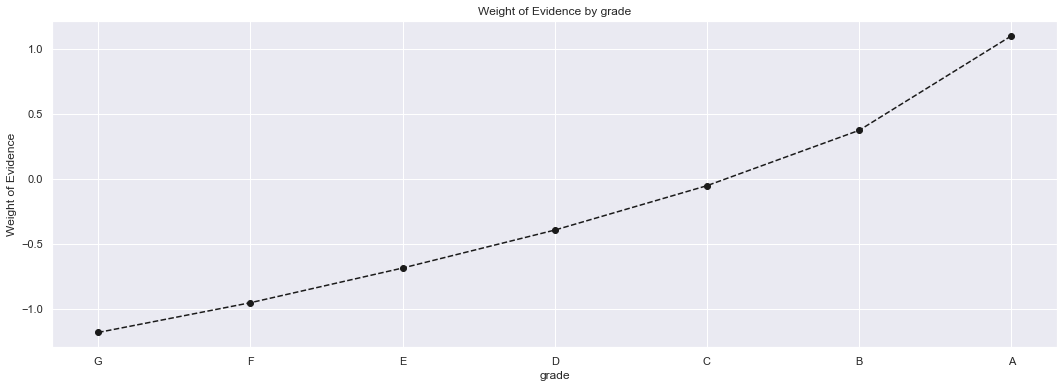

In [46]:
plot_by_woe(df_temp)

In [47]:
df_temp = woe(df_input_train,'home_ownership',df_target_train)
df_temp

home_ownership   count  proportion_of_good  proportion_of_count    n_good  \
0          OTHER     135            0.762963             0.000386     103.0   
1           NONE      41            0.853659             0.000117      35.0   
2           RENT  141419            0.873928             0.404386  123590.0   
3            OWN   31202            0.889815             0.089222   27764.0   
4       MORTGAGE  176915            0.903666             0.505886  159872.0   
5            ANY       1            1.000000             0.000003       1.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
0     32.0     0.000331    0.000834 -0.925270  inf  
1      6.0     0.000112    0.000156 -0.330675  inf  
2  17829.0     0.396930    0.464926 -0.158120  inf  
3   3438.0     0.089169    0.089653 -0.005413  inf  
4  17043.0     0.513455    0.444430  0.144370  inf  
5      0.0     0.000003    0.000000       inf  inf

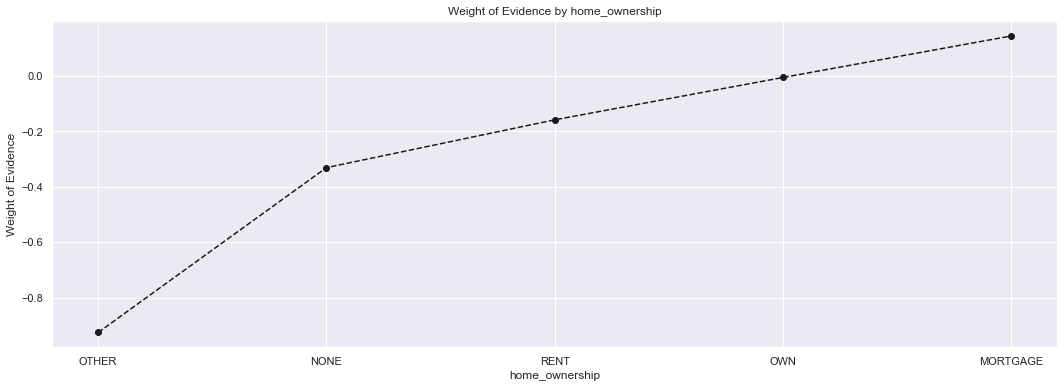

In [48]:
plot_by_woe(df_temp)

In [49]:
df_input_prep['home_ownership_RENT_OTHER_NONE_ANY']=  sum([df_input_prep['home_ownership_RENT'],
                                                          df_input_prep['home_ownership_OTHER'],
                                                          df_input_prep['home_ownership_NONE'],
                                                          df_input_prep['home_ownership_ANY']]
                                                         )

In [50]:
df_input_prep['addr_state'].unique()

array(['TX', 'CO', 'AZ', 'NC', 'NY', 'MI', 'NJ', 'TN', 'MO', 'MA', 'FL',
       'CA', 'NV', 'MD', 'KS', 'KY', 'WA', 'IN', 'VA', 'PA', 'GA', 'WI',
       'CT', 'NH', 'IL', 'OR', 'MN', 'SD', 'OH', 'HI', 'AK', 'UT', 'VT',
       'AL', 'SC', 'DC', 'RI', 'WV', 'LA', 'MS', 'NM', 'AR', 'OK', 'MT',
       'DE', 'WY', 'IA', 'ME', 'ID', 'NE'], dtype=object)

In [51]:
df_temp = woe(df_input_prep,'addr_state',df_target_prep)

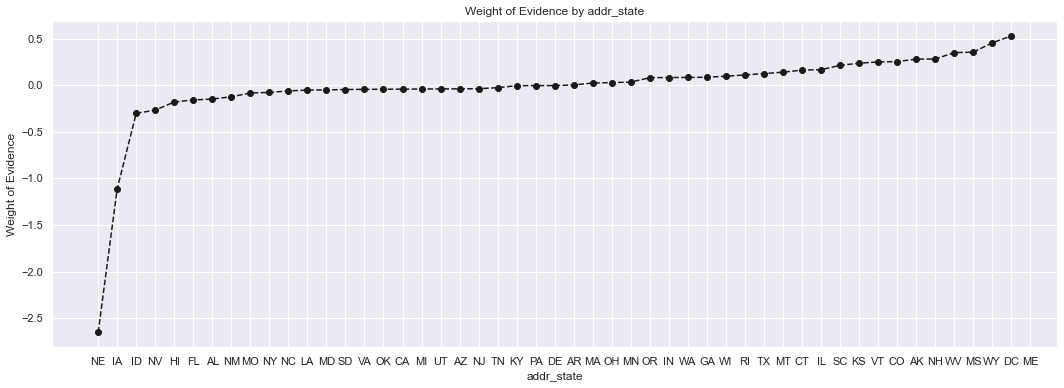

In [52]:
plot_by_woe(df_temp)

In [53]:
if ['addr_state_ND'] in df_input_prep.columns.values:
    pass
else:
    df_input_prep['addr_state_ND'] = 0

In [54]:
#first lets seperate state with high value into its own categories
df_temp.sort_values(by ='count', ascending=False)

#CA, NY, TX and FL is high in count so it should be seperate into its own categories

addr_state  count  proportion_of_good  proportion_of_count   n_good  \
16         CA  53580            0.886133             0.153211  47479.0   
9          NY  30310            0.882481             0.086671  26748.0   
35         TX  27393            0.901909             0.078330  24706.0   
5          FL  23827            0.873883             0.068133  20822.0   
38         IL  13878            0.905534             0.039684  12567.0   
20         NJ  13431            0.886606             0.038406  11908.0   
23         PA  12296            0.889883             0.035160  10942.0   
27         OH  11415            0.893035             0.032641  10194.0   
32         GA  11227            0.898370             0.032103  10086.0   
14         VA  10637            0.885870             0.030416   9423.0   
10         NC   9461            0.884156             0.027054   8365.0   
17         MI   8675            0.886225             0.024806   7688.0   
12         MD   8306            0.885264             0.023751   7353.0   
26         MA   8237            0.892558             0.023554   7352.0   
19         AZ   8039            0.886429             0.022987   7126.0   
31         WA   7820            0.898210             0.022361   7024.0   
42         CO   7333            0.912723             0.020969   6693.0   
28         MN   6094            0.893502             0.017426   5445.0   
8          MO   5631            0.881904             0.016102   4966.0   
37         CT   5326            0.905182             0.015230   4821.0   
30         IN   4936            0.898096             0.014114   4433.0   
3          NV   4877            0.861390             0.013946   4201.0   
21         TN   4513            0.887658             0.012905   4006.0   
29         OR   4507            0.897937             0.012888   4047.0   
6          AL   4398            0.874943             0.012576   3848.0   
33         WI   4393            0.899385             0.012562   3951.0   
39         SC   4207            0.909437             0.012030   3826.0   
11         LA   4117            0.885111             0.011773   3644.0   
22         KY   3350            0.889851             0.009579   2981.0   
40         KS   3158            0.911336             0.009030   2878.0   
15         OK   3114            0.885999             0.008904   2759.0   
25         AR   2595            0.890559             0.007420   2311.0   
18         UT   2561            0.886373             0.007323   2270.0   
7          NM   2001            0.877561             0.005722   1756.0   
4          HI   1859            0.871436             0.005316   1620.0   
45         WV   1777            0.920090             0.005081   1635.0   
44         NH   1680            0.914881             0.004804   1537.0   
34         RI   1519            0.900592             0.004344   1368.0   
48         DC   1078            0.932282             0.003083   1005.0   
36         MT   1033            0.903195             0.002954    933.0   
24         DE    963            0.889927             0.002754    857.0   
43         AK    939            0.914803             0.002685    859.0   
46         MS    930            0.920430             0.002659    856.0   
47         WY    841            0.927467             0.002405    780.0   
13         SD    735            0.885714             0.002102    651.0   
41         VT    685            0.912409             0.001959    625.0   
0          NE     11            0.363636             0.000031      4.0   
1          IA     11            0.727273             0.000031      8.0   
2          ID      7            0.857143             0.000020      6.0   
49         ME      2            1.000000             0.000006      2.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
16  6101.0     0.152487    0.159096 -0.042429  inf  
9   3562.0     0.085906    0.092886 -0.078126  inf  
35  2687.0     0.079347    0.070069  0.124357  inf  
5   3005.0     0

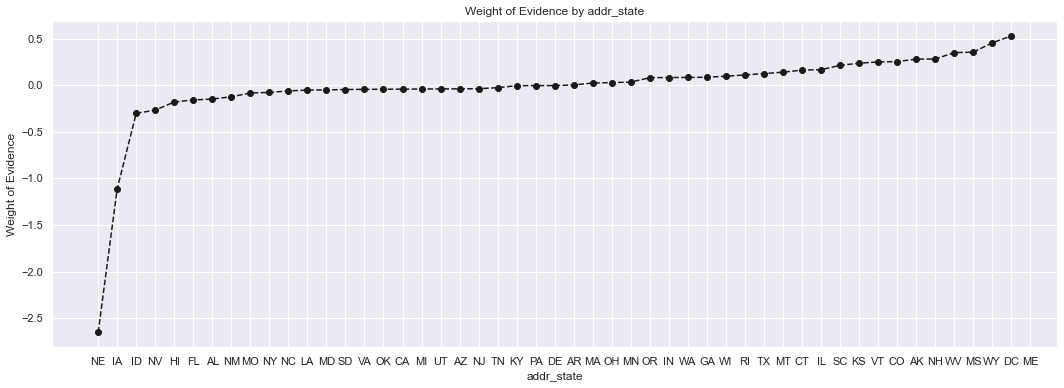

In [55]:
plot_by_woe(df_temp.iloc[:, :])

In [56]:
df_input_prep['addr_state_ND_NE_IA_NV_FL_HI_AL'] = sum([df_input_prep['addr_state_ND'], df_input_prep['addr_state_NE'],
                                                         df_input_prep['addr_state_IA'], df_input_prep['addr_state_NV'],
                                                         df_input_prep['addr_state_FL'], df_input_prep['addr_state_HI'],
                                                         df_input_prep['addr_state_AL']])

df_input_prep['addr_state_NM_VA'] = sum([df_input_prep['addr_state_NM'], df_input_prep['addr_state_VA']])

df_input_prep['addr_state_OK_TN_MO_LA_MD_NC'] = sum([df_input_prep['addr_state_OK'], df_input_prep['addr_state_TN'],
                                              df_input_prep['addr_state_MO'], df_input_prep['addr_state_LA'],
                                              df_input_prep['addr_state_MD'], df_input_prep['addr_state_NC']])

df_input_prep['addr_state_UT_KY_AZ_NJ'] = sum([df_input_prep['addr_state_UT'], df_input_prep['addr_state_KY'],
                                              df_input_prep['addr_state_AZ'], df_input_prep['addr_state_NJ']])

df_input_prep['addr_state_AR_MI_PA_OH_MN'] = sum([df_input_prep['addr_state_AR'], df_input_prep['addr_state_MI'],
                                              df_input_prep['addr_state_PA'], df_input_prep['addr_state_OH'],
                                              df_input_prep['addr_state_MN']])

df_input_prep['addr_state_RI_MA_DE_SD_IN'] = sum([df_input_prep['addr_state_RI'], df_input_prep['addr_state_MA'],
                                              df_input_prep['addr_state_DE'], df_input_prep['addr_state_SD'],
                                              df_input_prep['addr_state_IN']])

df_input_prep['addr_state_GA_WA_OR'] = sum([df_input_prep['addr_state_GA'], df_input_prep['addr_state_WA'],
                                              df_input_prep['addr_state_OR']])

df_input_prep['addr_state_WI_MT'] = sum([df_input_prep['addr_state_WI'], df_input_prep['addr_state_MT']])

df_input_prep['addr_state_IL_CT'] = sum([df_input_prep['addr_state_IL'], df_input_prep['addr_state_CT']])

df_input_prep['addr_state_KS_SC_CO_VT_AK_MS'] = sum([df_input_prep['addr_state_KS'], df_input_prep['addr_state_SC'],
                                              df_input_prep['addr_state_CO'], df_input_prep['addr_state_VT'],
                                              df_input_prep['addr_state_AK'], df_input_prep['addr_state_MS']])

df_input_prep['addr_state_WV_NH_WY_DC_ME_ID'] = sum([df_input_prep['addr_state_WV'], df_input_prep['addr_state_NH'],
                                              df_input_prep['addr_state_WY'], df_input_prep['addr_state_DC'],
                                              df_input_prep['addr_state_ME'], df_input_prep['addr_state_ID']])

In [57]:
df_temp = woe(df_input_prep, 'verification_status', df_target_prep)
df_temp

verification_status   count  proportion_of_good  proportion_of_count  \
0            Verified  125969            0.872572             0.360207   
1     Source Verified  112416            0.894739             0.321452   
2        Not Verified  111328            0.906016             0.318341   

     n_good    n_bad  prop_n_good  prop_n_bad       WoE        IV  
0  109917.0  16052.0     0.353017    0.418588 -0.170371  0.020607  
1  100583.0  11833.0     0.323039    0.308569  0.045828  0.020607  
2  100865.0  10463.0     0.323945    0.272843  0.171674  0.020607

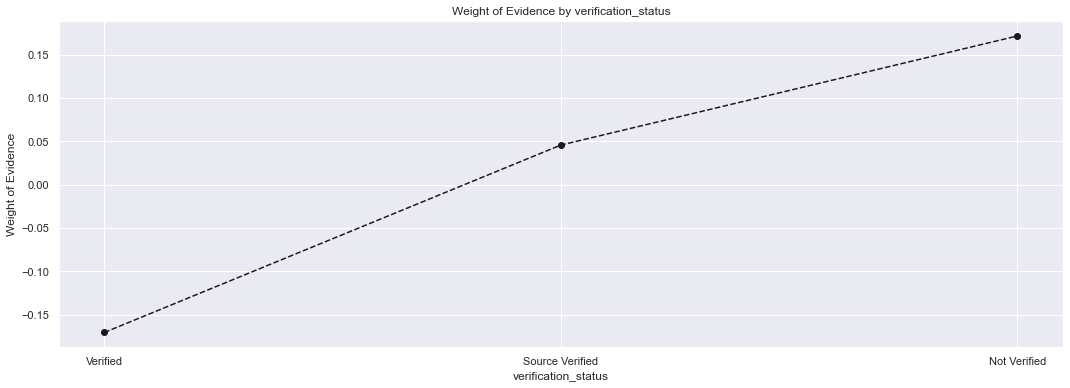

In [58]:
plot_by_woe(df_temp)

In [59]:
df_temp = woe(df_input_prep, 'purpose', df_target_prep)
df_temp

purpose   count  proportion_of_good  proportion_of_count  \
0          educational     322            0.767081             0.000921   
1       small_business    5316            0.784424             0.015201   
2     renewable_energy     259            0.833977             0.000741   
3               moving    2276            0.844464             0.006508   
4                house    1723            0.854904             0.004927   
5                other   17914            0.860779             0.051225   
6              medical    3431            0.863597             0.009811   
7              wedding    1761            0.875639             0.005036   
8             vacation    1877            0.883857             0.005367   
9   debt_consolidation  205444            0.886879             0.587465   
10    home_improvement   19907            0.899684             0.056924   
11      major_purchase    7345            0.906467             0.021003   
12         credit_card   78076            0.912854             0.223257   
13                 car    4062            0.913097             0.011615   

      n_good    n_bad  prop_n_good  prop_n_bad       WoE        IV  
0      247.0     75.0     0.000793    0.001956 -0.902363  0.037017  
1     4170.0   1146.0     0.013393    0.029884 -0.802625  0.037017  
2      216.0     43.0     0.000694    0.001121 -0.480185  0.037017  
3     1922.0    354.0     0.006173    0.009231 -0.402439  0.037017  
4     1473.0    250.0     0.004731    0.006519 -0.320668  0.037017  
5    15420.0   2494.0     0.049524    0.065036 -0.272486  0.037017  
6     2963.0    468.0     0.009516    0.012204 -0.248774  0.037017  
7     1542.0    219.0     0.004952    0.005711 -0.142500  0.037017  
8     1659.0    218.0     0.005328    0.005685 -0.064788  0.037017  
9   182204.0  23240.0     0.585178    0.606029 -0.035011  0.037017  
10   17910.0   1997.0     0.057521    0.052076  0.099450  0.037017  
11    6658.0    687.0     0.021383    0.017915  0.176977  0.037017  
12   71272.0   6804.0     0.228902    0.177428  0.254729  0.037017  
13    3709.0    353.0     0.011912    0.009205  0.257786  0.037017

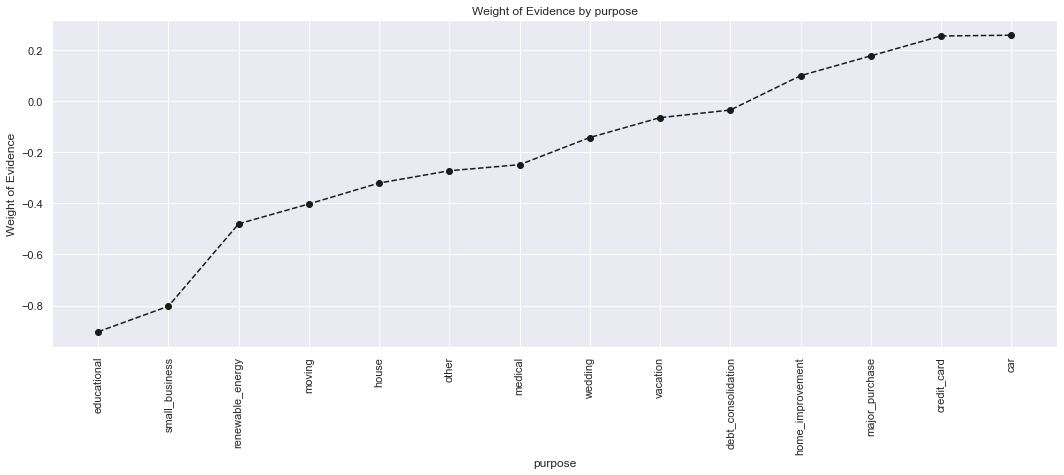

In [60]:
plot_by_woe(df_temp, 90)

In [61]:
df_input_prep['purpose_sm_b_educ'] = sum([ df_input_prep['purpose_small_business'],df_input_prep['purpose_educational']])
df_input_prep['purpose_ren_en_mov_house_other'] = sum([df_input_prep['purpose_renewable_energy'],df_input_prep['purpose_moving'], df_input_prep['purpose_house'],df_input_prep['purpose_other']])
df_input_prep['purpose_med_wed_vac'] = sum([df_input_prep['purpose_medical'],df_input_prep['purpose_wedding'],df_input_prep['purpose_vacation']])
df_input_prep['purpose_major_purch__car__home_impr'] = sum([df_input_prep['purpose_major_purchase'], df_input_prep['purpose_car'],df_input_prep['purpose_home_improvement']])

### Weight of Evidence for Continuous Variable

In [62]:
def woe_cont(df, discrete, dependent_var_df):
    df = pd.concat([df[discrete], dependent_var_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'count', 'proportion_of_good']
    df['proportion_of_count'] = df['count']/df['count'].sum()
    df['n_good'] = df['proportion_of_good']*df['count']
    df['n_bad'] = (1-df['proportion_of_good'])*df['count']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum() 
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop=True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad'])*df['WoE']
    df['IV'] = df.IV.sum() 
    return df

In [63]:
df_temp = woe_cont(df_input_prep, 'term', df_target_prep)
df_temp

term   count  proportion_of_good  proportion_of_count    n_good    n_bad  \
0    36  253463            0.902873             0.724774  228845.0  24618.0   
1    60   96250            0.857351             0.275226   82520.0  13730.0   

   prop_n_good  prop_n_bad       WoE        IV  
0     0.734973    0.641963  0.135304  0.040563  
1     0.265027    0.358037 -0.300806  0.040563

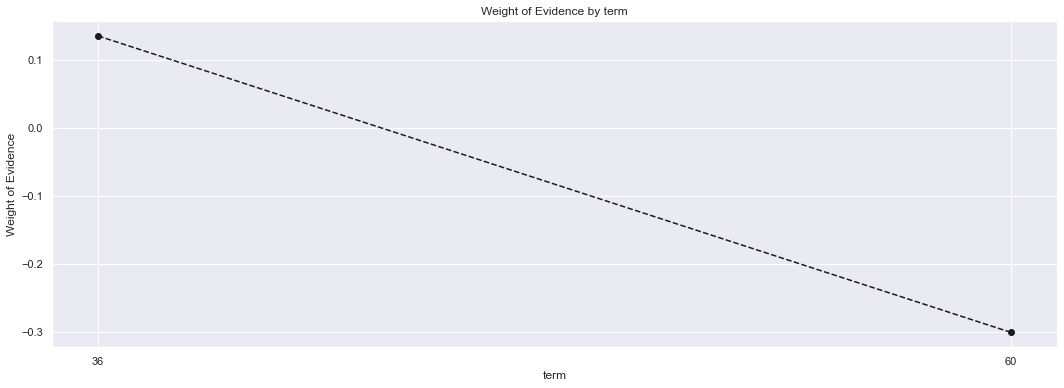

In [64]:
plot_by_woe(df_temp)

In [65]:
df_input_prep['term_36'] = np.where((df_input_prep['term']==36),1,0)
df_input_prep['term_60'] = np.where((df_input_prep['term']==60),1,0)

In [66]:
df_temp = woe_cont(df_input_prep, 'emp_length_int', df_target_prep)
df_temp

emp_length_int   count  proportion_of_good  proportion_of_count    n_good  \
0                0   42918            0.874924             0.122723   37550.0   
1                1   22156            0.886126             0.063355   19633.0   
2                2   31133            0.890952             0.089024   27738.0   
3                3   27581            0.890142             0.078868   24551.0   
4                4   21166            0.890107             0.060524   18840.0   
5                5   23006            0.885682             0.065785   20376.0   
6                6   19552            0.883388             0.055909   17272.0   
7                7   19641            0.887989             0.056163   17441.0   
8                8   16842            0.890452             0.048159   14997.0   
9                9   13437            0.887921             0.038423   11931.0   
10              10  112281            0.899849             0.321066  101036.0   

      n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    5368.0     0.120598    0.139981 -0.149046  0.006655  
1    2523.0     0.063055    0.065792 -0.042500  0.006655  
2    3395.0     0.089085    0.088531  0.006236  0.006655  
3    3030.0     0.078850    0.079013 -0.002074  0.006655  
4    2326.0     0.060508    0.060655 -0.002431  0.006655  
5    2630.0     0.065441    0.068582 -0.046890  0.006655  
6    2280.0     0.055472    0.059456 -0.069352  0.006655  
7    2200.0     0.056015    0.057369 -0.023897  0.006655  
8    1845.0     0.048165    0.048112  0.001107  0.006655  
9    1506.0     0.038318    0.039272 -0.024581  0.006655  
10  11245.0     0.324494    0.293236  0.101290  0.006655

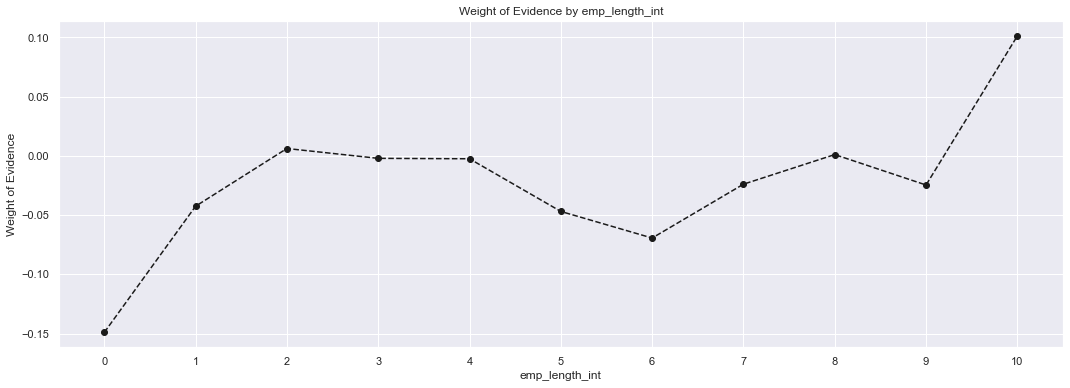

In [67]:
plot_by_woe(df_temp)

In [68]:
df_input_prep['emp_length_int_0'] = np.where(df_input_prep['emp_length_int'].isin([0]),1,0)
df_input_prep['emp_length_int_1-3'] = np.where(df_input_prep['emp_length_int'].isin(range(1,4)),1,0)
df_input_prep['emp_length_int_4'] = np.where(df_input_prep['emp_length_int'].isin([4]),1,0)
df_input_prep['emp_length_int_5-6'] = np.where(df_input_prep['emp_length_int'].isin(range(5,7)),1,0)
df_input_prep['emp_length_int_7-9'] = np.where(df_input_prep['emp_length_int'].isin(range(7,10)),1,0)
df_input_prep['emp_length_int_10'] = np.where(df_input_prep['emp_length_int'].isin([10]),1,0)                                               

In [69]:
df_input_prep.issue_d_in_mnths.unique() 

array([ 57.,  44.,  73.,  40.,  55.,  39.,  41.,  91.,  42.,  68.,  53.,
        74.,  45.,  43.,  72.,  37.,  46.,  63.,  38.,  76.,  51.,  70.,
        99.,  61.,  47., 102.,  71.,  88.,  48.,  49.,  66., 104.,  54.,
        50.,  65.,  56.,  60.,  52.,  85.,  64.,  69.,  59.,  90.,  75.,
        81.,  80.,  79.,  67.,  84.,  98., 107.,  95.,  86.,  58., 118.,
        62., 100.,  92.,  77.,  89.,  83., 119.,  78., 110., 101., 125.,
        87., 105.,  96., 106., 108.,  82., 127.,  97., 121., 120., 112.,
       114.,  94., 117., 111.,  93., 122., 126., 123., 109., 113., 116.,
       103., 115., 124.])

In [70]:
df_input_prep['issue_d_in_mnths_factor'] = pd.cut(df_input_prep['issue_d_in_mnths'],50)

In [71]:
df_input_prep['issue_d_in_mnths_factor']

145391    (56.8, 58.6]
392160    (42.4, 44.2]
2469      (71.2, 73.0]
308958    (38.8, 40.6]
132941    (53.2, 55.0]
              ...     
181923    (60.4, 62.2]
88037     (51.4, 53.2]
86188     (51.4, 53.2]
351680    (40.6, 42.4]
336356    (40.6, 42.4]
Name: issue_d_in_mnths_factor, Length: 349713, dtype: category
Categories (50, interval[float64]): [(36.91, 38.8] < (38.8, 40.6] < (40.6, 42.4] < (42.4, 44.2] ... (119.8, 121.6] < (121.6, 123.4] < (123.4, 125.2] < (125.2, 127.0]]

In [72]:
df_temp = woe_cont(df_input_prep, 'issue_d_in_mnths_factor', df_target_prep)

In [73]:
df_temp

issue_d_in_mnths_factor  count  proportion_of_good  proportion_of_count  \
0            (36.91, 38.8]  26609            0.943177             0.076088   
1             (38.8, 40.6]  36934            0.928440             0.105612   
2             (40.6, 42.4]  35837            0.917320             0.102475   
3             (42.4, 44.2]  27310            0.908934             0.078093   
4             (44.2, 46.0]  26750            0.900486             0.076491   
5             (46.0, 47.8]  11397            0.897780             0.032590   
6             (47.8, 49.6]  23071            0.895973             0.065971   
7             (49.6, 51.4]  21564            0.886014             0.061662   
8             (51.4, 53.2]  19288            0.879873             0.055154   
9             (53.2, 55.0]  17060            0.869109             0.048783   
10            (55.0, 56.8]   7797            0.861742             0.022295   
11            (56.8, 58.6]  13324            0.864380             0.038100   
12            (58.6, 60.4]  10860            0.859945             0.031054   
13            (60.4, 62.2]   9300            0.851398             0.026593   
14            (62.2, 64.0]   9191            0.850832             0.026282   
15            (64.0, 65.8]   4066            0.842597             0.011627   
16            (65.8, 67.6]   6352            0.821631             0.018163   
17            (67.6, 69.4]   4952            0.844305             0.014160   
18            (69.4, 71.2]   4092            0.840909             0.011701   
19            (71.2, 73.0]   3636            0.820132             0.010397   
20            (73.0, 74.8]   1693            0.851742             0.004841   
21            (74.8, 76.6]   3136            0.850446             0.008967   
22            (76.6, 78.4]   2817            0.863330             0.008055   
23            (78.4, 80.2]   2653            0.841312             0.007586   
24            (80.2, 82.0]   2278            0.851185             0.006514   
25            (82.0, 83.8]    967            0.869700             0.002765   
26            (83.8, 85.6]   2065            0.866828             0.005905   
27            (85.6, 87.4]   1860            0.854839             0.005319   
28            (87.4, 89.2]   1799            0.838243             0.005144   
29            (89.2, 91.0]   1741            0.843194             0.004978   
30            (91.0, 92.8]    753            0.856574             0.002153   
31            (92.8, 94.6]   1315            0.895057             0.003760   
32            (94.6, 96.4]   1006            0.878728             0.002877   
33            (96.4, 98.2]    993            0.876133             0.002839   
34           (98.2, 100.0]    827            0.857316             0.002365   
35          (100.0, 101.8]    327            0.899083             0.000935   
36          (101.8, 103.6]    624            0.847756             0.001784   
37          (103.6, 105.4]    543            0.848987             0.001553   
38          (105.4, 107.2]    468            0.865385             0.001338   
39          (107.2, 109.0]    397            0.851385             0.001135   
40          (109.0, 110.8]    155            0.812903             0.000443   
41          (110.8, 112.6]    128            0.820312             0.000366   
42          (112.6, 114.4]    173            0.826590             0.000495   
43          (114.4, 116.2]    185            0.794595             0.000529   
44          (116.2, 118.0]    497            0.770624             0.001421   
45          (118.0, 119.8]    234            0.807692             0.000669   
46          (119.8, 121.6]    355            0.757746             0.001015   
47          (121.6, 123.4]    167            0.652695             0.000478   
48          (123.4, 125.2]     95            0.715789             0.000272   
49          (125.2, 127.0]     72            0.875000             0.000206   

     n_good   n_bad  pro

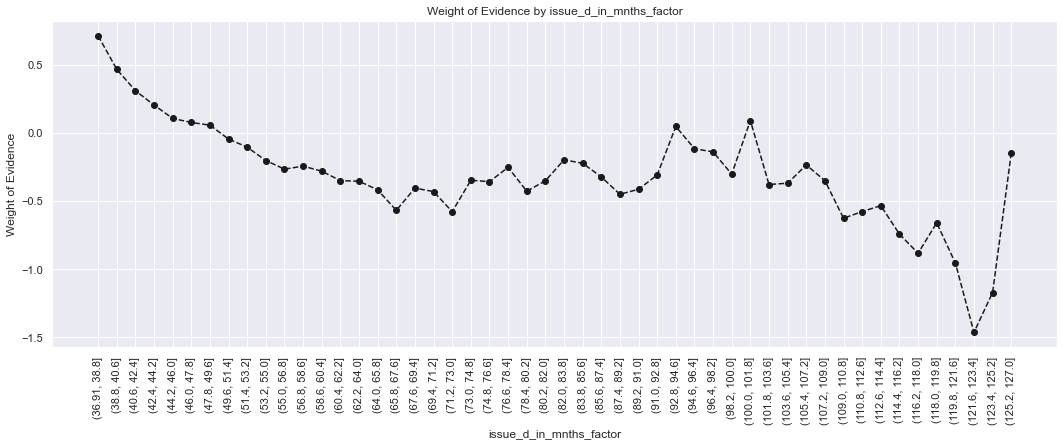

In [74]:
plot_by_woe(df_temp, 90)

In [75]:
df_input_prep['issue_d_in_mnths_<39'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(39)), 1, 0)
df_input_prep['issue_d_in_mnths_39-40'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(39, 41)), 1, 0)
df_input_prep['issue_d_in_mnths_41-42'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(41, 43)), 1, 0)
df_input_prep['issue_d_in_mnths_43-48'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(43, 49)), 1, 0)
df_input_prep['issue_d_in_mnths_49-54'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(49, 55)), 1, 0)
df_input_prep['issue_d_in_mnths_55-66'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(55, 67)), 1, 0)
df_input_prep['issue_d_in_mnths_67-84'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(67, 85)), 1, 0)
df_input_prep['issue_d_in_mnths_>84'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(85, int(df_input_prep['issue_d_in_mnths'].max()))), 1, 0)

In [76]:
df_input_prep['int_rate_factor'] = pd.cut(df_input_prep['int_rate'],50)

In [77]:
df_temp = woe_cont(df_input_prep,'int_rate_factor',df_target_prep)
df_temp

int_rate_factor  count  proportion_of_good  proportion_of_count   n_good  \
0     (5.399, 5.833]    740            0.962162             0.002116    712.0   
1     (5.833, 6.246]   7857            0.980909             0.022467   7707.0   
2     (6.246, 6.658]   7355            0.971040             0.021032   7142.0   
3     (6.658, 7.071]   1685            0.965579             0.004818   1627.0   
4     (7.071, 7.484]   2922            0.976728             0.008355   2854.0   
5     (7.484, 7.897]  11887            0.962564             0.033991  11442.0   
6      (7.897, 8.31]   9163            0.948270             0.026201   8689.0   
7      (8.31, 8.722]   6142            0.965809             0.017563   5932.0   
8     (8.722, 9.135]   8934            0.936982             0.025547   8371.0   
9     (9.135, 9.548]   6198            0.967409             0.017723   5996.0   
10    (9.548, 9.961]   7148            0.931869             0.020440   6661.0   
11   (9.961, 10.374]  10360            0.935039             0.029624   9687.0   
12  (10.374, 10.786]   5477            0.915100             0.015661   5012.0   
13  (10.786, 11.199]  16667            0.930461             0.047659  15508.0   
14  (11.199, 11.612]   4517            0.918530             0.012916   4149.0   
15  (11.612, 12.025]  14488            0.933255             0.041428  13521.0   
16  (12.025, 12.438]  11554            0.895188             0.033039  10343.0   
17   (12.438, 12.85]  10366            0.922246             0.029641   9560.0   
18   (12.85, 13.263]  20165            0.902752             0.057662  18204.0   
19  (13.263, 13.676]  14356            0.906868             0.041051  13019.0   
20  (13.676, 14.089]  10314            0.894512             0.029493   9226.0   
21  (14.089, 14.502]  21985            0.887833             0.062866  19519.0   
22  (14.502, 14.914]   4134            0.863570             0.011821   3570.0   
23  (14.914, 15.327]  17789            0.883130             0.050867  15710.0   
24   (15.327, 15.74]  11630            0.889854             0.033256  10349.0   
25   (15.74, 16.153]   7025            0.839858             0.020088   5900.0   
26  (16.153, 16.566]  12106            0.855774             0.034617  10360.0   
27  (16.566, 16.978]   3954            0.843450             0.011306   3335.0   
28  (16.978, 17.391]  10642            0.851062             0.030431   9057.0   
29  (17.391, 17.804]  11514            0.839500             0.032924   9666.0   
30  (17.804, 18.217]   1187            0.816344             0.003394    969.0   
31   (18.217, 18.63]  10344            0.830530             0.029579   8591.0   
32   (18.63, 19.042]   6420            0.819315             0.018358   5260.0   
33  (19.042, 19.455]   4165            0.805042             0.011910   3353.0   
34  (19.455, 19.868]   6271            0.820124             0.017932   5143.0   
35  (19.868, 20.281]   4617            0.832142             0.013202   3842.0   
36  (20.281, 20.694]   3052            0.795216             0.008727   2427.0   
37  (20.694, 21.106]   3711            0.793317             0.010612   2944.0   
38  (21.106, 21.519]   2567            0.773276             0.007340   1985.0   
39  (21.519, 21.932]    906            0.771523             0.002591    699.0   
40  (21.932, 22.345]   3213            0.792095             0.009188   2545.0   
41  (22.345, 22.758]   2141            0.755722             0.006122   1618.0   
42   (22.758, 23.17]   1408            0.753551             0.004026   1061.0   
43   (23.17, 23.583]   2499            0.777511             0.007146   1943.0   
44  (23.583, 23.996]   1480            0.729054             0.004232   1079.0   
45  (23.996, 24.409]   1431            0.783368             0.004092   1121.0   
46  (24.409, 24.822]   1542            0.765888             0.004409   1181.0   
47  (24.822, 25.234]   1262            0.774168             0.003609    977.0   
48  (25.234, 25.647]    724         

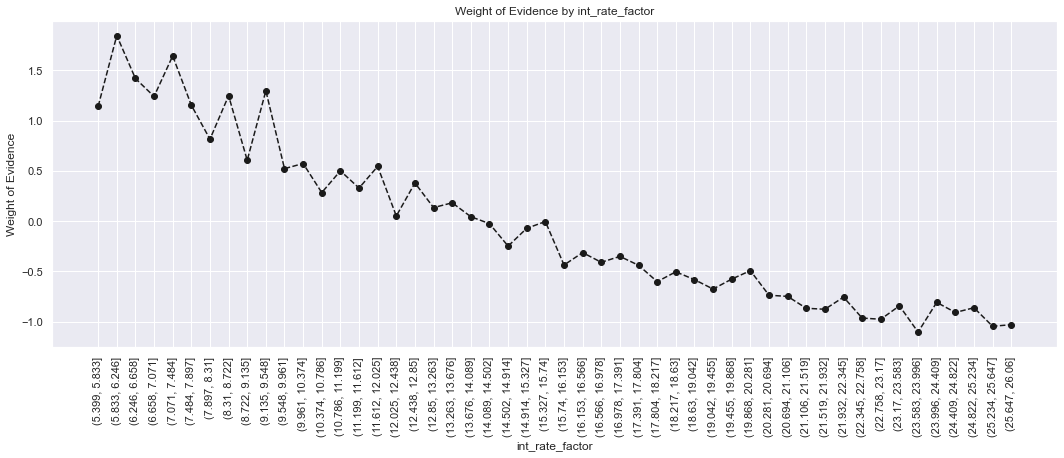

In [78]:
plot_by_woe(df_temp, 90)

In [79]:
df_input_prep['int_rate_<9.548'] = np.where((df_input_prep['int_rate']<=9.548),1,0)
df_input_prep['int_rate_9.548-12.025'] =np.where((df_input_prep['int_rate']>9.548)&(df_input_prep['int_rate']<=12.025),1,0)
df_input_prep['int_rate_12.025-15.74'] =np.where((df_input_prep['int_rate']>12.025)&(df_input_prep['int_rate']<=15.74),1,0)
df_input_prep['int_rate_15.74-20.281'] =np.where((df_input_prep['int_rate']>15.74)&(df_input_prep['int_rate']<=20.281),1,0)
df_input_prep['int_rate_>20.281'] = np.where((df_input_prep['int_rate']>=20.281),1,0)

In [80]:
df_input_prep['funded_amnt_factor'] = pd.cut(df_input_prep['funded_amnt'],50)

In [81]:
df_temp = woe_cont(df_input_prep, 'funded_amnt_factor',df_target_prep)
df_temp

funded_amnt_factor  count  proportion_of_good  proportion_of_count  \
0      (465.5, 1190.0]   1141            0.903593             0.003263   
1     (1190.0, 1880.0]   2862            0.903913             0.008184   
2     (1880.0, 2570.0]   5660            0.895760             0.016185   
3     (2570.0, 3260.0]   6912            0.886285             0.019765   
4     (3260.0, 3950.0]   4569            0.891005             0.013065   
5     (3950.0, 4640.0]   8448            0.890033             0.024157   
6     (4640.0, 5330.0]  14951            0.893318             0.042752   
7     (5330.0, 6020.0]  16035            0.906642             0.045852   
8     (6020.0, 6710.0]   6472            0.883807             0.018507   
9     (6710.0, 7400.0]  10945            0.897031             0.031297   
10    (7400.0, 8090.0]  16495            0.897060             0.047167   
11    (8090.0, 8780.0]   5983            0.879826             0.017108   
12    (8780.0, 9470.0]   8652            0.881646             0.024740   
13   (9470.0, 10160.0]  31464            0.894228             0.089971   
14  (10160.0, 10850.0]   6325            0.872885             0.018086   
15  (10850.0, 11540.0]   8025            0.883988             0.022947   
16  (11540.0, 12230.0]  21927            0.903224             0.062700   
17  (12230.0, 12920.0]   4539            0.873100             0.012979   
18  (12920.0, 13610.0]   6864            0.895833             0.019628   
19  (13610.0, 14300.0]   7699            0.892064             0.022015   
20  (14300.0, 14990.0]   4815            0.876843             0.013768   
21  (14990.0, 15680.0]  20345            0.900074             0.058176   
22  (15680.0, 16370.0]  10914            0.882353             0.031208   
23  (16370.0, 17060.0]   6124            0.880307             0.017512   
24  (17060.0, 17750.0]   3272            0.869193             0.009356   
25  (17750.0, 18440.0]  10692            0.885148             0.030574   
26  (18440.0, 19130.0]   3678            0.864600             0.010517   
27  (19130.0, 19820.0]   3780            0.858730             0.010809   
28  (19820.0, 20510.0]  19093            0.897764             0.054596   
29  (20510.0, 21200.0]   6173            0.898105             0.017652   
30  (21200.0, 21890.0]   1906            0.853095             0.005450   
31  (21890.0, 22580.0]   3834            0.886802             0.010963   
32  (22580.0, 23270.0]   2288            0.884178             0.006543   
33  (23270.0, 23960.0]   1729            0.842105             0.004944   
34  (23960.0, 24650.0]   9177            0.900948             0.026242   
35  (24650.0, 25340.0]   9406            0.893472             0.026896   
36  (25340.0, 26030.0]   1747            0.863194             0.004996   
37  (26030.0, 26720.0]   1155            0.823377             0.003303   
38  (26720.0, 27410.0]   1460            0.878767             0.004175   
39  (27410.0, 28100.0]   6043            0.904021             0.017280   
40  (28100.0, 28790.0]    758            0.852243             0.002167   
41  (28790.0, 29480.0]   1075            0.861395             0.003074   
42  (29480.0, 30170.0]   6851            0.883959             0.019590   
43  (30170.0, 30860.0]    527            0.815939             0.001507   
44  (30860.0, 31550.0]    834            0.872902             0.002385   
45  (31550.0, 32240.0]   1299            0.879908             0.003714   
46  (32240.0, 32930.0]    583            0.873070             0.001667   
47  (32930.0, 33620.0]   1042            0.893474             0.002980   
48  (33620.0, 34310.0]    471            0.889597             0.001347   
49  (34310.0, 35000.0]  12674            0.880543             0.036241   

     n_good   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    1031.0   110.0     0.003311    0.002868  0.143541  0.014759  
1    2587.0   275.0     0.008309    0.007171  0.147220  0.014759  
2    5070.0   590.0     0.01

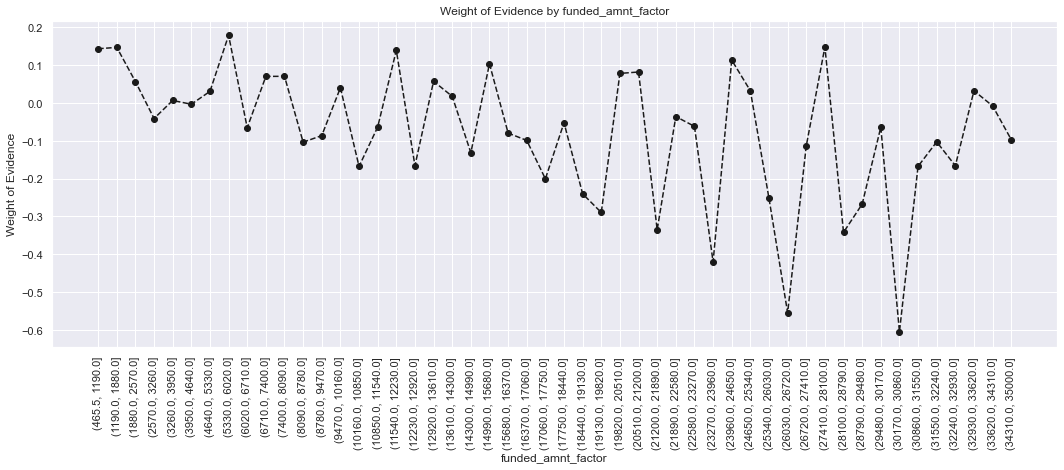

In [82]:
plot_by_woe(df_temp, 90)

Because of the distribution of the weight of evidence and the low Information Value. lets not put this into our pd model

In [83]:
df_input_prep['earliest_cr_line_in_mnths_factor'] = pd.cut(df_input_prep['earliest_cr_line_in_mnths'], 50)
df_temp = woe_cont(df_input_prep, 'earliest_cr_line_in_mnths_factor', df_target_prep)
df_temp

earliest_cr_line_in_mnths_factor  count  proportion_of_good  \
0                   (-0.588, 11.76]     23            0.913043   
1                    (11.76, 23.52]      0                 NaN   
2                    (23.52, 35.28]      0                 NaN   
3                    (35.28, 47.04]      0                 NaN   
4                     (47.04, 58.8]      0                 NaN   
5                     (58.8, 70.56]      0                 NaN   
6                    (70.56, 82.32]    564            0.907801   
7                    (82.32, 94.08]   1974            0.891084   
8                   (94.08, 105.84]   2392            0.860786   
9                   (105.84, 117.6]   4474            0.869915   
10                  (117.6, 129.36]   8281            0.859437   
11                 (129.36, 141.12]  11660            0.864408   
12                 (141.12, 152.88]  11671            0.879188   
13                 (152.88, 164.64]  14938            0.880774   
14                  (164.64, 176.4]  18053            0.882679   
15                  (176.4, 188.16]  20479            0.887104   
16                 (188.16, 199.92]  22428            0.884564   
17                 (199.92, 211.68]  26589            0.884915   
18                 (211.68, 223.44]  25868            0.887506   
19                  (223.44, 235.2]  22350            0.888725   
20                  (235.2, 246.96]  17239            0.887058   
21                 (246.96, 258.72]  16881            0.892660   
22                 (258.72, 270.48]  16814            0.889854   
23                 (270.48, 282.24]  15195            0.902205   
24                  (282.24, 294.0]  13344            0.903028   
25                  (294.0, 305.76]   8954            0.907304   
26                 (305.76, 317.52]   7827            0.903156   
27                 (317.52, 329.28]   8013            0.899538   
28                 (329.28, 341.04]   7874            0.903988   
29                  (341.04, 352.8]   6262            0.900830   
30                  (352.8, 364.56]   5756            0.909312   
31                 (364.56, 376.32]   5166            0.907859   
32                 (376.32, 388.08]   4342            0.912022   
33                 (388.08, 399.84]   3634            0.907540   
34                  (399.84, 411.6]   3498            0.907947   
35                  (411.6, 423.36]   2902            0.914542   
36                 (423.36, 435.12]   2139            0.908836   
37                 (435.12, 446.88]   1531            0.923579   
38                 (446.88, 458.64]   1503            0.910845   
39                  (458.64, 470.4]   1529            0.910399   
40                  (470.4, 482.16]   1452            0.913223   
41                 (482.16, 493.92]   1055            0.905213   
42                 (493.92, 505.68]    917            0.917121   
43                 (505.68, 517.44]    729            0.917695   
44                  (517.44, 529.2]    575            0.900870   
45                  (529.2, 540.96]    493            0.904665   
46                 (540.96, 552.72]    511            0.902153   
47                 (552.72, 564.48]    331            0.903323   
48                 (564.48, 576.24]    334            0.877246   
49                  (576.24, 588.0]   1169            0.886228   

    proportion_of_count   n_good   n_bad  prop_n_good  prop_n_bad       WoE  \
0              0.000066     21.0     2.0     0.000067    0.000052  0.257112   
1              0.000000      NaN     NaN          NaN         NaN       NaN   
2              0.000000      NaN     NaN          NaN         NaN       NaN   
3              0.000000      NaN     NaN          NaN         NaN       NaN   
4              0.000000      NaN     NaN          NaN         NaN       NaN   
5              0.000000      NaN     NaN          NaN         NaN       NaN   
6              0.001613    512.0    52.0     0.001644    0.001356  0.192817   
7   

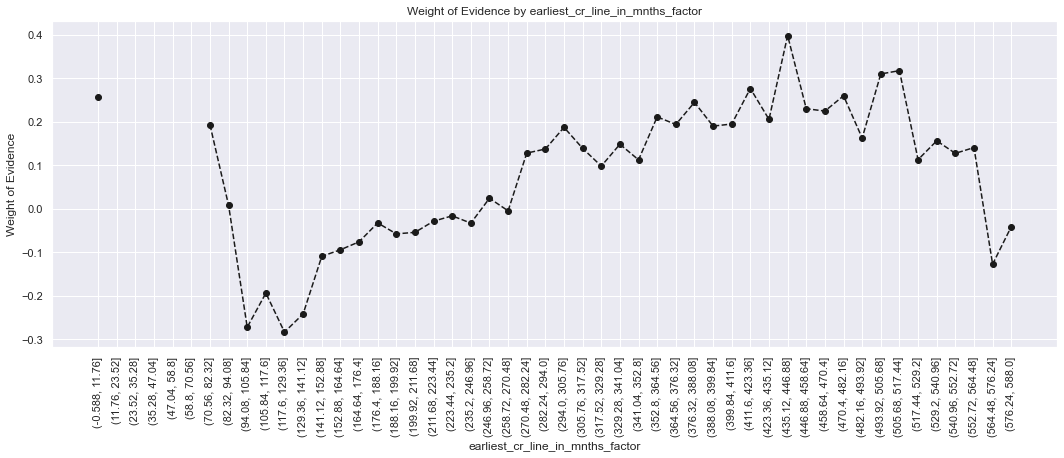

In [84]:
plot_by_woe(df_temp, 90)

In [85]:
df_input_prep['earliest_cr_line_in_mnths_<140'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_141-164'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140, 165)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_165-247'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(165, 248)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_248-270'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(248, 271)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_271-352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(271, 353)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_>352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(353, int(df_input_prep['earliest_cr_line_in_mnths'].max()))), 1, 0)

In [86]:
df_temp = woe_cont(df_input_prep, 'delinq_2yrs', df_target_prep)
df_temp

delinq_2yrs   count  proportion_of_good  proportion_of_count    n_good  \
0           0.0  287116            0.890212             0.821005  255594.0   
1           1.0   42270            0.893068             0.120871   37750.0   
2           2.0   12219            0.886570             0.034940   10833.0   
3           3.0    4317            0.883484             0.012344    3814.0   
4           4.0    1756            0.895786             0.005021    1573.0   
5           5.0     934            0.891863             0.002671     833.0   
6           6.0     465            0.896774             0.001330     417.0   
7           7.0     253            0.865613             0.000723     219.0   
8           8.0     136            0.889706             0.000389     121.0   
9           9.0      81            0.901235             0.000232      73.0   
10         10.0      54            0.851852             0.000154      46.0   
11         11.0      32            0.906250             0.000092      29.0   
12         12.0      31            0.709677             0.000089      22.0   
13         13.0      18            0.777778             0.000051      14.0   
14         14.0       6            1.000000             0.000017       6.0   
15         15.0       5            0.800000             0.000014       4.0   
16         16.0       4            1.000000             0.000011       4.0   
17         17.0       2            0.500000             0.000006       1.0   
18         18.0       5            0.800000             0.000014       4.0   
19         19.0       3            1.000000             0.000009       3.0   
20         21.0       2            0.500000             0.000006       1.0   
21         22.0       2            1.000000             0.000006       2.0   
22         24.0       1            1.000000             0.000003       1.0   
23         29.0       1            1.000000             0.000003       1.0   

      n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   31522.0     0.820882    0.821999 -0.001359  inf  
1    4520.0     0.121240    0.117868  0.028210  inf  
2    1386.0     0.034792    0.036143 -0.038088  inf  
3     503.0     0.012249    0.013117 -0.068420  inf  
4     183.0     0.005052    0.004772  0.056990  inf  
5     101.0     0.002675    0.002634  0.015650  inf  
6      48.0     0.001339    0.001252  0.067622  inf  
7      34.0     0.000703    0.000887 -0.231552  inf  
8      15.0     0.000389    0.000391 -0.006523  inf  
9       8.0     0.000234    0.000209  0.116754  inf  
10      8.0     0.000148    0.000209 -0.345064  inf  
11      3.0     0.000093    0.000078  0.174420  inf  
12      9.0     0.000071    0.000235 -1.200446  inf  
13      4.0     0.000045    0.000104 -0.841501  inf  
14      0.0     0.000019    0.000000       inf  inf  
15      1.0     0.000013    0.000026 -0.707969  inf  
16      0.0     0.000013    0.000000       inf  inf  
17      1.0     0.000003    0.000026 -2.094263  inf  
18      1.0     0.000013    0.000026 -0.707969  inf  
19      0.0     0.000010    0.000000       inf  inf  
20      1.0     0.000003    0.000026 -2.094263  inf  
21      0.0     0.000006    0.000000       inf  inf  
22      0.0     0.000003    0.000000       inf  inf  
23      0.0     0.000003    0.000000       inf  inf

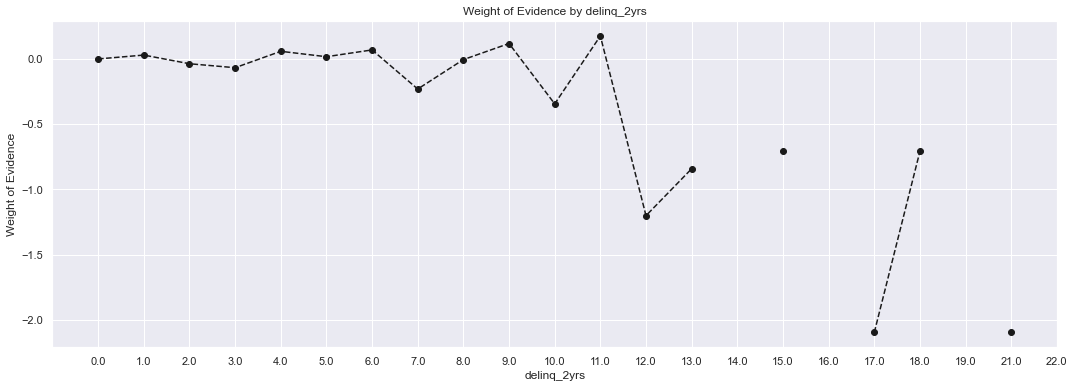

In [87]:
plot_by_woe(df_temp)

In [88]:
df_input_prep['delinq_2yrs_0'] = np.where((df_input_prep['delinq_2yrs'] == 0), 1, 0)
df_input_prep['delinq_2yrs_1-6'] = np.where((df_input_prep['delinq_2yrs'] >= 1) & (df_input_prep['delinq_2yrs'] <= 6), 1, 0)
df_input_prep['delinq_2yrs_>6'] = np.where((df_input_prep['delinq_2yrs'] >6), 1, 0)

In [89]:
df_temp = woe_cont(df_input_prep, 'inq_last_6mths', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


inq_last_6mths   count  proportion_of_good  proportion_of_count    n_good  \
0              0.0  181309            0.908609             0.518451  164739.0   
1              1.0   97401            0.883820             0.278517   86085.0   
2              2.0   43429            0.862442             0.124185   37455.0   
3              3.0   18755            0.841322             0.053630   15779.0   
4              4.0    5470            0.846435             0.015641    4630.0   
5              5.0    2117            0.830420             0.006054    1758.0   
6              6.0     880            0.784091             0.002516     690.0   
7              7.0     145            0.655172             0.000415      95.0   
8              8.0      95            0.652632             0.000272      62.0   
9              9.0      38            0.631579             0.000109      24.0   
10            10.0      19            0.842105             0.000054      16.0   
11            11.0      11            0.818182             0.000031       9.0   
12            12.0      11            0.454545             0.000031       5.0   
13            13.0       5            0.600000             0.000014       3.0   
14            14.0       5            0.000000             0.000014       0.0   
15            15.0       7            0.428571             0.000020       3.0   
16            16.0       3            1.000000             0.000009       3.0   
17            17.0       1            1.000000             0.000003       1.0   
18            18.0       4            0.500000             0.000011       2.0   
19            19.0       2            1.000000             0.000006       2.0   
20            20.0       1            0.000000             0.000003       0.0   
21            24.0       2            1.000000             0.000006       2.0   
22            28.0       1            1.000000             0.000003       1.0   
23            31.0       1            1.000000             0.000003       1.0   
24            32.0       1            0.000000             0.000003       0.0   

      n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   16570.0     0.529086    0.432096  0.202505  inf  
1   11316.0     0.276476    0.295087 -0.065146  inf  
2    5974.0     0.120293    0.155784 -0.258540  inf  
3    2976.0     0.050677    0.077605 -0.426164  inf  
4     840.0     0.014870    0.021905 -0.387353  inf  
5     359.0     0.005646    0.009362 -0.505654  inf  
6     190.0     0.002216    0.004955 -0.804596  inf  
7      50.0     0.000305    0.001304 -1.452410  inf  
8      33.0     0.000199    0.000861 -1.463637  inf  
9      14.0     0.000077    0.000365 -1.555267  inf  
10      3.0     0.000051    0.000078 -0.420287  inf  
11      2.0     0.000029    0.000052 -0.590186  inf  
12      6.0     0.000016    0.000156 -2.276585  inf  
13      2.0     0.000010    0.000052 -1.688798  inf  
14      5.0     0.000000    0.000130      -inf  inf  
15      4.0     0.000010    0.000104 -2.381946  inf  
16      0.0     0.000010    0.000000       inf  inf  
17      0.0     0.000003    0.000000       inf  inf  
18      2.0     0.000006    0.000052 -2.094263  inf  
19      0.0     0.000006    0.000000       inf  inf  
20      1.0     0.000000    0.000026      -inf  inf  
21      0.0     0.000006    0.000000       inf  inf  
22      0.0     0.000003    0.000000       inf  inf  
23      0.0     0.000003    0.000000       inf  inf  
24      1.0     0.000000    0.000026      -inf  inf

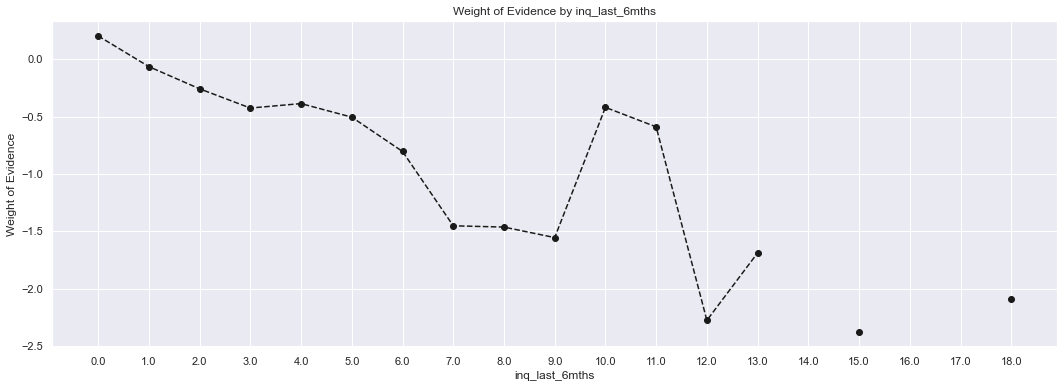

In [90]:
plot_by_woe(df_temp)

In [91]:
df_input_prep['inq_last_6mths_0'] = np.where((df_input_prep['inq_last_6mths'] == 0), 1, 0)
df_input_prep['inq_last_6mths_1-2'] = np.where((df_input_prep['inq_last_6mths'] >= 1) & (df_input_prep['inq_last_6mths'] <= 2), 1, 0)
df_input_prep['inq_last_6mths_3-6'] = np.where((df_input_prep['inq_last_6mths'] >= 3) & (df_input_prep['inq_last_6mths'] <= 6), 1, 0)
df_input_prep['inq_last_6mths_>6'] = np.where((df_input_prep['inq_last_6mths'] > 6), 1, 0)

In [92]:
df_temp = woe_cont(df_input_prep, 'open_acc', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


open_acc  count  proportion_of_good  proportion_of_count   n_good   n_bad  \
0        0.0     28            0.821429             0.000080     23.0     5.0   
1        1.0     98            0.857143             0.000280     84.0    14.0   
2        2.0   1369            0.845142             0.003915   1157.0   212.0   
3        3.0   4152            0.869461             0.011873   3610.0   542.0   
4        4.0   9549            0.891926             0.027305   8517.0  1032.0   
5        5.0  16178            0.891148             0.046261  14417.0  1761.0   
6        6.0  23126            0.889086             0.066129  20561.0  2565.0   
7        7.0  28194            0.890580             0.080620  25109.0  3085.0   
8        8.0  31466            0.891534             0.089977  28053.0  3413.0   
9        9.0  33024            0.888596             0.094432  29345.0  3679.0   
10      10.0  31775            0.890763             0.090860  28304.0  3471.0   
11      11.0  29393            0.888001             0.084049  26101.0  3292.0   
12      12.0  25996            0.887983             0.074335  23084.0  2912.0   
13      13.0  22268            0.894692             0.063675  19923.0  2345.0   
14      14.0  18536            0.890807             0.053003  16512.0  2024.0   
15      15.0  15209            0.891709             0.043490  13562.0  1647.0   
16      16.0  12566            0.894318             0.035932  11238.0  1328.0   
17      17.0   9935            0.890991             0.028409   8852.0  1083.0   
18      18.0   8200            0.896707             0.023448   7353.0   847.0   
19      19.0   6484            0.888803             0.018541   5763.0   721.0   
20      20.0   5010            0.892814             0.014326   4473.0   537.0   
21      21.0   3921            0.895435             0.011212   3511.0   410.0   
22      22.0   3062            0.891901             0.008756   2731.0   331.0   
23      23.0   2405            0.903119             0.006877   2172.0   233.0   
24      24.0   1844            0.883948             0.005273   1630.0   214.0   
25      25.0   1437            0.885177             0.004109   1272.0   165.0   
26      26.0    978            0.893661             0.002797    874.0   104.0   
27      27.0    799            0.897372             0.002285    717.0    82.0   
28      28.0    577            0.901213             0.001650    520.0    57.0   
29      29.0    460            0.886957             0.001315    408.0    52.0   
30      30.0    359            0.894150             0.001027    321.0    38.0   
31      31.0    256            0.878906             0.000732    225.0    31.0   
32      32.0    213            0.906103             0.000609    193.0    20.0   
33      33.0    173            0.867052             0.000495    150.0    23.0   
34      34.0    141            0.879433             0.000403    124.0    17.0   
35      35.0    118            0.940678             0.000337    111.0     7.0   
36      36.0     87            0.793103             0.000249     69.0    18.0   
37      37.0     74            0.878378             0.000212     65.0     9.0   
38      38.0     53            0.886792             0.000152     47.0     6.0   
39      39.0     54            0.944444             0.000154     51.0     3.0   
40      40.0     28            0.821429             0.000080     23.0     5.0   
41      41.0     25            0.880000             0.000071     22.0     3.0   
42      42.0     20            1.000000             0.000057     20.0     0.0   
43      43.0     15            0.933333             0.000043     14.0     1.0   
44      44.0      9            0.888889             0.000026      8.0     1.0   
45      45.0     10            0.900000             0.000029      9.0     1.0   
46      46.0      5            1.000000             0.000014      5.0     0.0   
47      47.0      4            0.750000             0.000011      3.0     1.0   
48      48.0      3            1.00

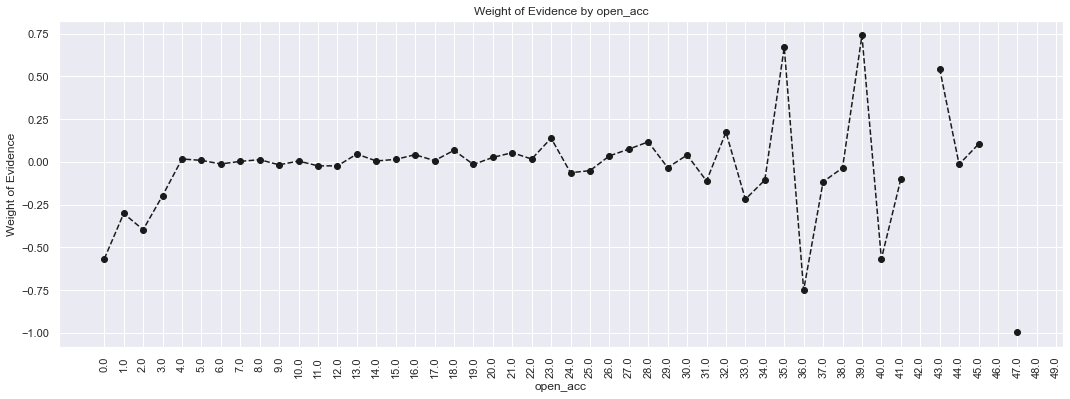

In [93]:
plot_by_woe(df_temp, 90)

In [94]:
df_input_prep['open_acc_0'] = np.where((df_input_prep['open_acc'] == 0), 1, 0)
df_input_prep['open_acc_1-3'] = np.where((df_input_prep['open_acc'] >= 1) & (df_input_prep['open_acc'] <= 3), 1, 0)
df_input_prep['open_acc_4-12'] = np.where((df_input_prep['open_acc'] >= 4) & (df_input_prep['open_acc'] <= 12), 1, 0)
df_input_prep['open_acc_13-17'] = np.where((df_input_prep['open_acc'] >= 13) & (df_input_prep['open_acc'] <= 17), 1, 0)
df_input_prep['open_acc_18-22'] = np.where((df_input_prep['open_acc'] >= 18) & (df_input_prep['open_acc'] <= 22), 1, 0)
df_input_prep['open_acc_23-25'] = np.where((df_input_prep['open_acc'] >= 23) & (df_input_prep['open_acc'] <= 25), 1, 0)
df_input_prep['open_acc_26-30'] = np.where((df_input_prep['open_acc'] >= 26) & (df_input_prep['open_acc'] <= 30), 1, 0)
df_input_prep['open_acc_>=31'] = np.where((df_input_prep['open_acc'] >= 31), 1, 0)

In [95]:
df_temp = woe_cont(df_input_prep, 'pub_rec', df_target_prep)
df_temp

pub_rec   count  proportion_of_good  proportion_of_count    n_good  \
0       0.0  303639            0.889276             0.868252  270019.0   
1       1.0   39825            0.895744             0.113879   35673.0   
2       2.0    4219            0.904954             0.012064    3818.0   
3       3.0    1213            0.914262             0.003469    1109.0   
4       4.0     391            0.902813             0.001118     353.0   
5       5.0     207            0.898551             0.000592     186.0   
6       6.0     110            0.945455             0.000315     104.0   
7       7.0      43            0.953488             0.000123      41.0   
8       8.0      22            0.954545             0.000063      21.0   
9       9.0      12            0.750000             0.000034       9.0   
10     10.0      13            1.000000             0.000037      13.0   
11     11.0       8            1.000000             0.000023       8.0   
12     12.0       2            1.000000             0.000006       2.0   
13     16.0       1            1.000000             0.000003       1.0   
14     17.0       1            1.000000             0.000003       1.0   
15     18.0       2            1.000000             0.000006       2.0   
16     19.0       1            1.000000             0.000003       1.0   
17     21.0       1            1.000000             0.000003       1.0   
18     34.0       1            1.000000             0.000003       1.0   
19     40.0       1            1.000000             0.000003       1.0   
20     63.0       1            1.000000             0.000003       1.0   

      n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   33620.0     0.867211    0.876708 -0.010892  inf  
1    4152.0     0.114570    0.108272  0.056540  inf  
2     401.0     0.012262    0.010457  0.159257  inf  
3     104.0     0.003562    0.002712  0.272560  inf  
4      38.0     0.001134    0.000991  0.134618  inf  
5      21.0     0.000597    0.000548  0.086961  inf  
6       6.0     0.000334    0.000156  0.758368  inf  
7       2.0     0.000132    0.000052  0.926161  inf  
8       1.0     0.000067    0.000026  0.950259  inf  
9       3.0     0.000029    0.000078 -0.995651  inf  
10      0.0     0.000042    0.000000       inf  inf  
11      0.0     0.000026    0.000000       inf  inf  
12      0.0     0.000006    0.000000       inf  inf  
13      0.0     0.000003    0.000000       inf  inf  
14      0.0     0.000003    0.000000       inf  inf  
15      0.0     0.000006    0.000000       inf  inf  
16      0.0     0.000003    0.000000       inf  inf  
17      0.0     0.000003    0.000000       inf  inf  
18      0.0     0.000003    0.000000       inf  inf  
19      0.0     0.000003    0.000000       inf  inf  
20      0.0     0.000003    0.000000       inf  inf

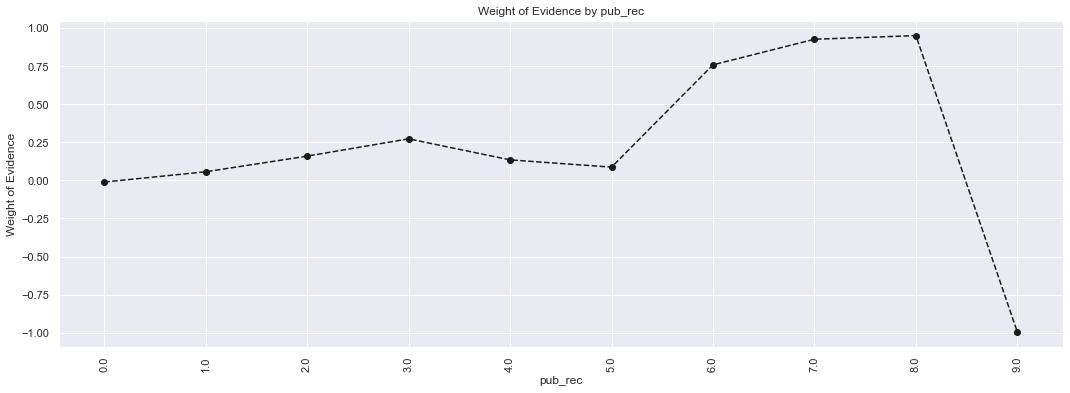

In [96]:
plot_by_woe(df_temp, 90)

In [97]:
df_input_prep['pub_rec_0-2'] = np.where((df_input_prep['pub_rec'] >= 0) & (df_input_prep['pub_rec'] <= 2), 1, 0)
df_input_prep['pub_rec_3-4'] = np.where((df_input_prep['pub_rec'] >= 3) & (df_input_prep['pub_rec'] <= 4), 1, 0)
df_input_prep['pub_rec_>=5'] = np.where((df_input_prep['pub_rec'] >= 5), 1, 0)

In [98]:
df_input_prep['total_acc_factor'] = pd.cut(df_input_prep['total_acc'], 50)
df_temp = woe_cont(df_input_prep, 'total_acc_factor', df_target_prep)
df_temp

total_acc_factor  count  proportion_of_good  proportion_of_count   n_good  \
0     (-0.121, 2.42]     80            0.812500             0.000229     65.0   
1       (2.42, 4.84]   1522            0.829829             0.004352   1263.0   
2       (4.84, 7.26]   8171            0.864398             0.023365   7063.0   
3       (7.26, 9.68]  10457            0.871474             0.029902   9113.0   
4       (9.68, 12.1]  23701            0.881440             0.067773  20891.0   
5      (12.1, 14.52]  20351            0.880596             0.058193  17921.0   
6     (14.52, 16.94]  22821            0.885062             0.065256  20198.0   
7     (16.94, 19.36]  37112            0.888203             0.106121  32963.0   
8     (19.36, 21.78]  25493            0.888597             0.072897  22653.0   
9      (21.78, 24.2]  37698            0.892382             0.107797  33641.0   
10     (24.2, 26.62]  23240            0.894019             0.066454  20777.0   
11    (26.62, 29.04]  30994            0.896044             0.088627  27772.0   
12    (29.04, 31.46]  17951            0.897220             0.051331  16106.0   
13    (31.46, 33.88]  15759            0.893585             0.045063  14082.0   
14     (33.88, 36.3]  19359            0.898807             0.055357  17400.0   
15     (36.3, 38.72]  10338            0.904140             0.029561   9347.0   
16    (38.72, 41.14]  12718            0.899906             0.036367  11445.0   
17    (41.14, 43.56]   6593            0.897315             0.018853   5916.0   
18    (43.56, 45.98]   5452            0.894901             0.015590   4879.0   
19     (45.98, 48.4]   6128            0.894093             0.017523   5479.0   
20     (48.4, 50.82]   3028            0.897952             0.008659   2719.0   
21    (50.82, 53.24]   3400            0.906765             0.009722   3083.0   
22    (53.24, 55.66]   1643            0.897748             0.004698   1475.0   
23    (55.66, 58.08]   1814            0.899118             0.005187   1631.0   
24     (58.08, 60.5]    926            0.888769             0.002648    823.0   
25     (60.5, 62.92]    966            0.897516             0.002762    867.0   
26    (62.92, 65.34]   1281            0.893052             0.003663   1144.0   
27    (65.34, 67.76]    154            0.915584             0.000440    141.0   
28    (67.76, 70.18]    178            0.910112             0.000509    162.0   
29     (70.18, 72.6]     65            0.938462             0.000186     61.0   
30     (72.6, 75.02]    107            0.906542             0.000306     97.0   
31    (75.02, 77.44]     41            0.878049             0.000117     36.0   
32    (77.44, 79.86]     32            0.812500             0.000092     26.0   
33    (79.86, 82.28]     36            0.888889             0.000103     32.0   
34     (82.28, 84.7]     23            0.869565             0.000066     20.0   
35     (84.7, 87.12]     22            0.954545             0.000063     21.0   
36    (87.12, 89.54]     15            0.866667             0.000043     13.0   
37    (89.54, 91.96]     10            0.900000             0.000029      9.0   
38    (91.96, 94.38]     12            0.750000             0.000034      9.0   
39     (94.38, 96.8]      5            1.000000             0.000014      5.0   
40     (96.8, 99.22]      5            1.000000             0.000014      5.0   
41   (99.22, 101.64]      1            1.000000             0.000003      1.0   
42  (101.64, 104.06]      2            1.000000             0.000006      2.0   
43  (104.06, 106.48]      5            1.000000             0.000014      5.0   
44   (106.48, 108.9]      0                 NaN             0.000000      NaN   
45   (108.9, 111.32]      0                 NaN             0.000000      NaN   
46  (111.32, 113.74]      0                 NaN             0.000000      NaN   
47  (113.74, 116.16]      1            1.000000             0.000003      1.0   
48  (116.16, 118.58]      2        

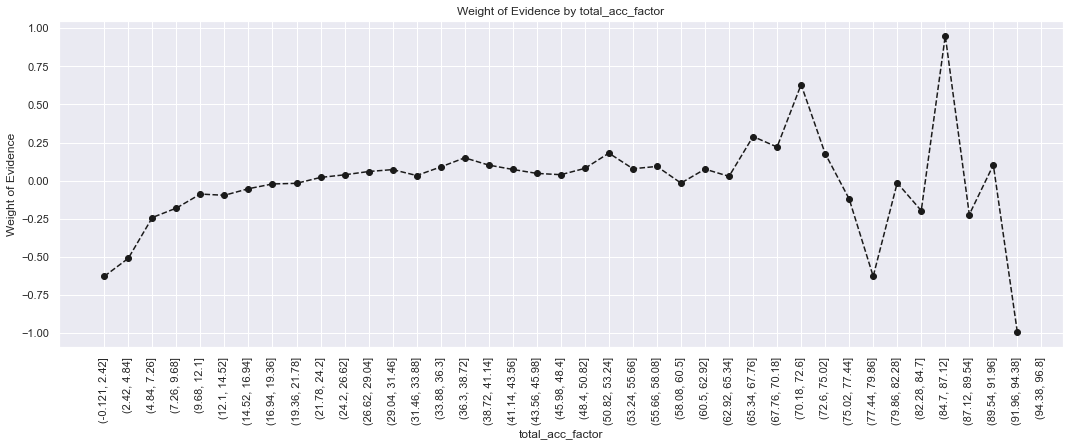

In [99]:
plot_by_woe(df_temp, 90)

In [100]:
df_input_prep['total_acc_<=27'] = np.where((df_input_prep['total_acc'] <= 27), 1, 0)
df_input_prep['total_acc_28-51'] = np.where((df_input_prep['total_acc'] >= 28) & (df_input_prep['total_acc'] <= 51), 1, 0)
df_input_prep['total_acc_>=52'] = np.where((df_input_prep['total_acc'] >= 52), 1, 0)

In [101]:
df_temp = woe_cont(df_input_prep, 'acc_now_delinq', df_target_prep)
df_temp

acc_now_delinq   count  proportion_of_good  proportion_of_count    n_good  \
0             0.0  348445            0.890333             0.996374  310232.0   
1             1.0    1188            0.894781             0.003397    1063.0   
2             2.0      69            0.884058             0.000197      61.0   
3             3.0       8            0.750000             0.000023       6.0   
4             4.0       2            1.000000             0.000006       2.0   
5             5.0       1            1.000000             0.000003       1.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
0  38213.0     0.996361    0.996480 -0.000119  inf  
1    125.0     0.003414    0.003260  0.046273  inf  
2      8.0     0.000196    0.000209 -0.062831  inf  
3      2.0     0.000019    0.000052 -0.995651  inf  
4      0.0     0.000006    0.000000       inf  inf  
5      0.0     0.000003    0.000000       inf  inf

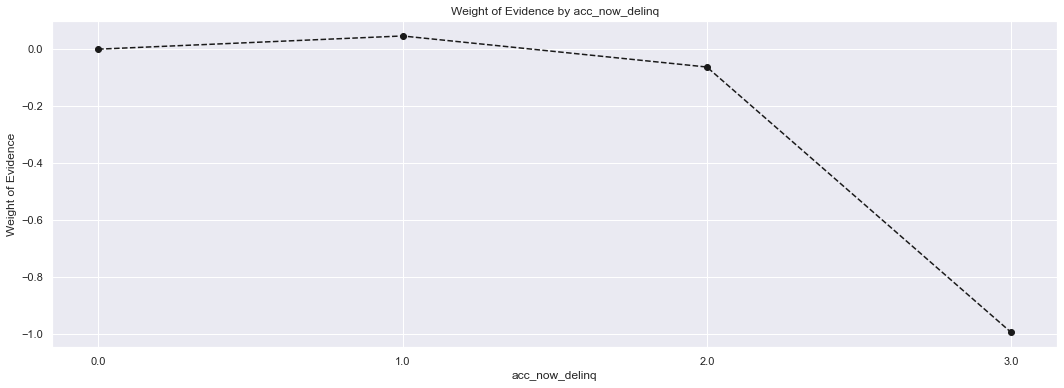

In [102]:
plot_by_woe(df_temp)

In [103]:
df_input_prep['acc_now_delinq_0'] = np.where((df_input_prep['acc_now_delinq'] == 0), 1, 0)
df_input_prep['acc_now_delinq_>=1'] = np.where((df_input_prep['acc_now_delinq'] >= 1), 1, 0)

In [104]:
df_input_prep['total_rev_hi_lim_factor'] = pd.cut(df_input_prep['total_rev_hi_lim'], 2000)
df_temp = woe_cont(df_input_prep, 'total_rev_hi_lim_factor', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


total_rev_hi_lim_factor  count  proportion_of_good  \
0          (-2013.133, 1006.566]    798            0.853383   
1           (1006.566, 2013.133]   2513            0.851174   
2             (2013.133, 3019.7]   4314            0.851646   
3             (3019.7, 4026.266]   5491            0.873976   
4           (4026.266, 5032.832]   8084            0.864300   
...                          ...    ...                 ...   
1995  (2008100.168, 2009106.734]      0                 NaN   
1996  (2009106.734, 2010113.301]      0                 NaN   
1997  (2010113.301, 2011119.867]      0                 NaN   
1998  (2011119.867, 2012126.434]      0                 NaN   
1999    (2012126.434, 2013133.0]      1            1.000000   

      proportion_of_count  n_good   n_bad  prop_n_good  prop_n_bad       WoE  \
0                0.002282   681.0   117.0     0.002187    0.003051 -0.332875   
1                0.007186  2139.0   374.0     0.006870    0.009753 -0.350426   
2                0.012336  3674.0   640.0     0.011800    0.016689 -0.346695   
3                0.015701  4799.0   692.0     0.015413    0.018045 -0.157687   
4                0.023116  6987.0  1097.0     0.022440    0.028606 -0.242791   
...                   ...     ...     ...          ...         ...       ...   
1995             0.000000     NaN     NaN          NaN         NaN       NaN   
1996             0.000000     NaN     NaN          NaN         NaN       NaN   
1997             0.000000     NaN     NaN          NaN         NaN       NaN   
1998             0.000000     NaN     NaN          NaN         NaN       NaN   
1999             0.000003     1.0     0.0     0.000003    0.000000       inf   

       IV  
0     inf  
1     inf  
2     inf  
3     inf  
4     inf  
...   ...  
1995  inf  
1996  inf  
1997  inf  
1998  inf  
1999  inf  

[2000 rows x 10 columns]

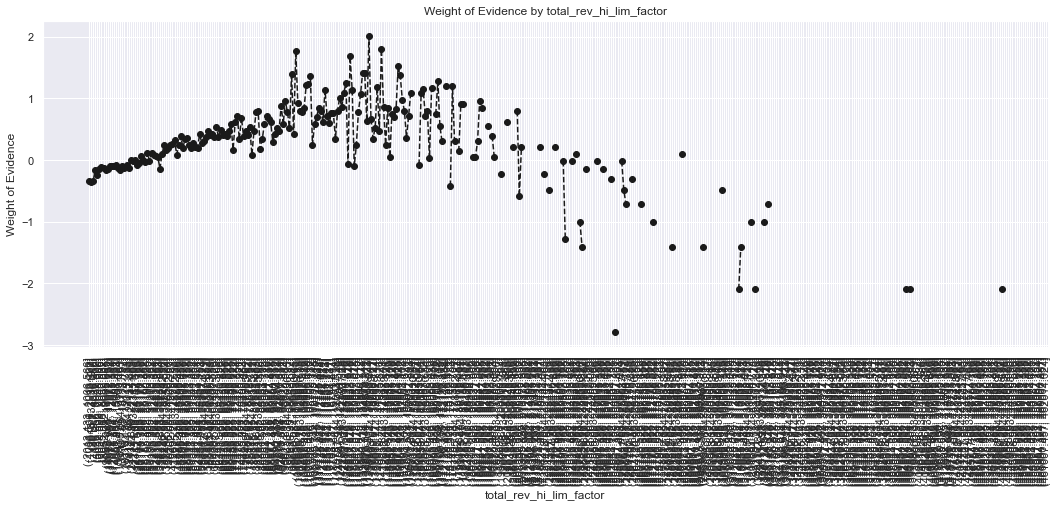

In [105]:
plot_by_woe(df_temp, 90)

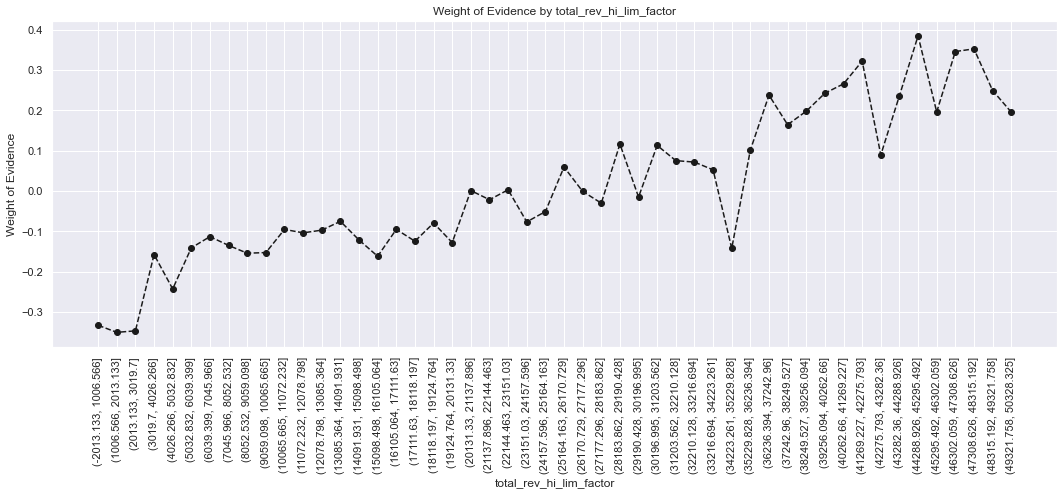

In [106]:
plot_by_woe(df_temp.iloc[:50,:], 90)

In [107]:
df_input_prep['total_rev_hi_lim_<=5K'] = np.where((df_input_prep['total_rev_hi_lim'] <= 5000), 1, 0)
df_input_prep['total_rev_hi_lim_5K-10K'] = np.where((df_input_prep['total_rev_hi_lim'] > 5000) & (df_input_prep['total_rev_hi_lim'] <= 10000), 1, 0)
df_input_prep['total_rev_hi_lim_10K-20K'] = np.where((df_input_prep['total_rev_hi_lim'] > 10000) & (df_input_prep['total_rev_hi_lim'] <= 20000), 1, 0)
df_input_prep['total_rev_hi_lim_20K-30K'] = np.where((df_input_prep['total_rev_hi_lim'] > 20000) & (df_input_prep['total_rev_hi_lim'] <= 30000), 1, 0)
df_input_prep['total_rev_hi_lim_30K-40K'] = np.where((df_input_prep['total_rev_hi_lim'] > 30000) & (df_input_prep['total_rev_hi_lim'] <= 40000), 1, 0)
df_input_prep['total_rev_hi_lim_40K-55K'] = np.where((df_input_prep['total_rev_hi_lim'] > 40000) & (df_input_prep['total_rev_hi_lim'] <= 55000), 1, 0)
df_input_prep['total_rev_hi_lim_55K-95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 55000) & (df_input_prep['total_rev_hi_lim'] <= 95000), 1, 0)
df_input_prep['total_rev_hi_lim_>95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 95000), 1, 0)

In [108]:
df_input_prep['installment_factor'] = pd.cut(df_input_prep['installment'], 50)
df_temp = woe_cont(df_input_prep, 'installment_factor', df_target_prep)
df_temp

installment_factor  count  proportion_of_good  proportion_of_count  \
0       (14.296, 43.576]   1710            0.900585             0.004890   
1       (43.576, 71.462]   4578            0.901485             0.013091   
2       (71.462, 99.348]   6447            0.891577             0.018435   
3      (99.348, 127.234]   8702            0.889681             0.024883   
4      (127.234, 155.12]   9532            0.894880             0.027257   
5      (155.12, 183.006]  15734            0.893733             0.044991   
6     (183.006, 210.892]  15967            0.905743             0.045657   
7     (210.892, 238.778]  14033            0.900591             0.040127   
8     (238.778, 266.664]  17757            0.901109             0.050776   
9      (266.664, 294.55]  18764            0.890162             0.053655   
10     (294.55, 322.436]  19133            0.897402             0.054711   
11    (322.436, 350.322]  23946            0.889835             0.068473   
12    (350.322, 378.208]  18123            0.886112             0.051822   
13    (378.208, 406.094]  16572            0.893978             0.047387   
14     (406.094, 433.98]  12508            0.880476             0.035766   
15     (433.98, 461.866]  11923            0.880735             0.034094   
16    (461.866, 489.752]  14736            0.893051             0.042137   
17    (489.752, 517.638]  14574            0.888843             0.041674   
18    (517.638, 545.524]  10129            0.864350             0.028964   
19     (545.524, 573.41]   9858            0.878474             0.028189   
20     (573.41, 601.296]   8846            0.879833             0.025295   
21    (601.296, 629.182]   8766            0.903833             0.025066   
22    (629.182, 657.068]   7862            0.897863             0.022481   
23    (657.068, 684.954]   8541            0.889123             0.024423   
24     (684.954, 712.84]   5776            0.876558             0.016516   
25     (712.84, 740.726]   4511            0.886721             0.012899   
26    (740.726, 768.612]   4910            0.895316             0.014040   
27    (768.612, 796.498]   4603            0.897024             0.013162   
28    (796.498, 824.384]   3765            0.891102             0.010766   
29     (824.384, 852.27]   3438            0.886853             0.009831   
30     (852.27, 880.156]   3965            0.889533             0.011338   
31    (880.156, 908.042]   3043            0.876438             0.008701   
32    (908.042, 935.928]   2065            0.870702             0.005905   
33    (935.928, 963.814]   2321            0.870745             0.006637   
34      (963.814, 991.7]   1664            0.843149             0.004758   
35     (991.7, 1019.586]   1584            0.857955             0.004529   
36  (1019.586, 1047.472]   1170            0.870940             0.003346   
37  (1047.472, 1075.358]    822            0.886861             0.002350   
38  (1075.358, 1103.244]    993            0.916415             0.002839   
39   (1103.244, 1131.13]    791            0.919090             0.002262   
40   (1131.13, 1159.016]    931            0.917293             0.002662   
41  (1159.016, 1186.902]   1094            0.914991             0.003128   
42  (1186.902, 1214.788]   1165            0.911588             0.003331   
43  (1214.788, 1242.674]    937            0.889007             0.002679   
44   (1242.674, 1270.56]    671            0.849478             0.001919   
45   (1270.56, 1298.446]    415            0.816867             0.001187   
46  (1298.446, 1326.332]    168            0.750000             0.000480   
47  (1326.332, 1354.218]    104            0.730769             0.000297   
48  (1354.218, 1382.104]     37            0.621622             0.000106   
49   (1382.104, 1409.99]     29            0.758621             0.000083   

     n_good   n_bad  prop_n_good  prop_n_bad       WoE       IV  
0    1540.0   170.0     0.004946    0.004433  0.109476  0.01334

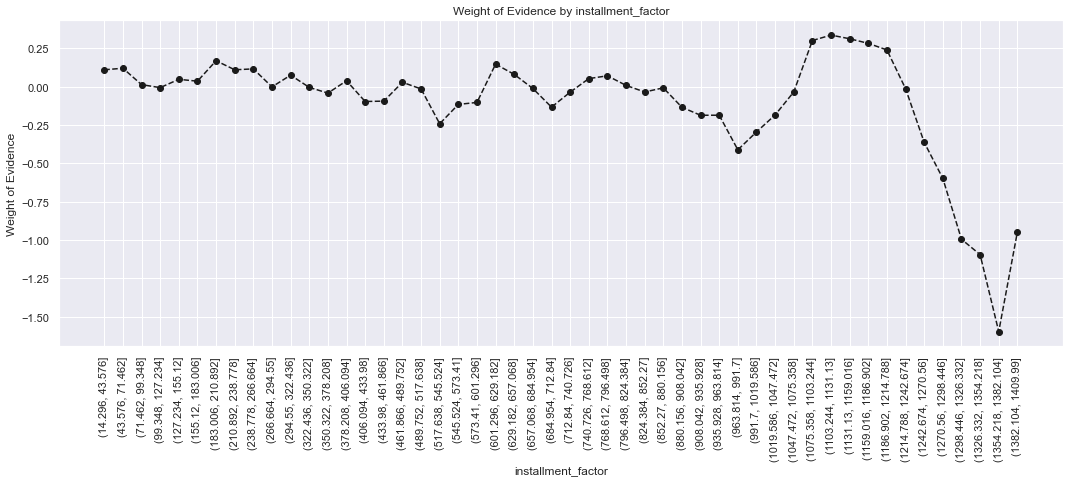

In [109]:
plot_by_woe(df_temp, 90)

In [110]:
df_input_prep['annual_inc_factor'] = pd.cut(df_input_prep['annual_inc'], 100)
df_temp = woe_cont(df_input_prep, 'annual_inc_factor', df_target_prep)
df_temp

annual_inc_factor   count  proportion_of_good  proportion_of_count  \
0      (-5602.104, 76877.04]  229757            0.877122             0.656987   
1      (76877.04, 151858.08]  104631            0.914299             0.299191   
2     (151858.08, 226839.12]   11155            0.924966             0.031898   
3     (226839.12, 301820.16]    2660            0.921053             0.007606   
4      (301820.16, 376801.2]     656            0.922256             0.001876   
..                       ...     ...                 ...                  ...   
95   (7125094.8, 7200075.84]       1            1.000000             0.000003   
96  (7200075.84, 7275056.88]       0                 NaN             0.000000   
97  (7275056.88, 7350037.92]       0                 NaN             0.000000   
98  (7350037.92, 7425018.96]       0                 NaN             0.000000   
99   (7425018.96, 7500000.0]       2            1.000000             0.000006   

      n_good    n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   201525.0  28232.0     0.647231    0.736205 -0.128806  inf  
1    95664.0   8967.0     0.307241    0.233832  0.273027  inf  
2    10318.0    837.0     0.033138    0.021826  0.417558  inf  
3     2450.0    210.0     0.007869    0.005476  0.362472  inf  
4      605.0     51.0     0.001943    0.001330  0.379139  inf  
..       ...      ...          ...         ...       ...  ...  
95       1.0      0.0     0.000003    0.000000       inf  inf  
96       NaN      NaN          NaN         NaN       NaN  inf  
97       NaN      NaN          NaN         NaN       NaN  inf  
98       NaN      NaN          NaN         NaN       NaN  inf  
99       2.0      0.0     0.000006    0.000000       inf  inf  

[100 rows x 10 columns]

In [111]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['annual_inc'] <= 150000, : ]

In [112]:
df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)
df_temp = woe_cont(df_input_prep_temp, 'annual_inc_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-112-83cf6fca08f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)


annual_inc_factor  count  proportion_of_good  proportion_of_count  \
0      (1747.896, 4858.08]     17            0.705882             0.000051   
1       (4858.08, 7820.16]     40            0.850000             0.000120   
2      (7820.16, 10782.24]    330            0.845455             0.000987   
3     (10782.24, 13744.32]    662            0.820242             0.001980   
4      (13744.32, 16706.4]   1297            0.850424             0.003880   
5      (16706.4, 19668.48]   1802            0.839623             0.005391   
6     (19668.48, 22630.56]   3359            0.845490             0.010049   
7     (22630.56, 25592.64]   6023            0.850241             0.018019   
8     (25592.64, 28554.72]   5356            0.852128             0.016023   
9      (28554.72, 31516.8]   9739            0.860150             0.029136   
10     (31516.8, 34478.88]   8115            0.855083             0.024277   
11    (34478.88, 37440.96]  13328            0.856242             0.039873   
12    (37440.96, 40403.04]  16917            0.868357             0.050610   
13    (40403.04, 43365.12]  11874            0.870894             0.035523   
14     (43365.12, 46327.2]  15564            0.875161             0.046562   
15     (46327.2, 49289.28]  10987            0.876945             0.032869   
16    (49289.28, 52251.36]  21332            0.882899             0.063818   
17    (52251.36, 55213.44]  15743            0.882360             0.047098   
18    (55213.44, 58175.52]   9587            0.889329             0.028681   
19     (58175.52, 61137.6]  17793            0.877536             0.053231   
20     (61137.6, 64099.68]   8843            0.892683             0.026455   
21    (64099.68, 67061.76]  14851            0.889166             0.044429   
22    (67061.76, 70023.84]  15077            0.896796             0.045105   
23    (70023.84, 72985.92]   6618            0.896646             0.019799   
24     (72985.92, 75948.0]  12811            0.901335             0.038326   
25     (75948.0, 78910.08]   5889            0.902530             0.017618   
26    (78910.08, 81872.16]  11687            0.903397             0.034964   
27    (81872.16, 84834.24]   5744            0.914868             0.017184   
28    (84834.24, 87796.32]   9374            0.908044             0.028044   
29     (87796.32, 90758.4]   9747            0.909921             0.029160   
30     (90758.4, 93720.48]   4232            0.914934             0.012661   
31    (93720.48, 96682.56]   6644            0.913305             0.019877   
32    (96682.56, 99644.64]   3586            0.916341             0.010728   
33   (99644.64, 102606.72]   8748            0.911065             0.026171   
34   (102606.72, 105568.8]   4440            0.919144             0.013283   
35   (105568.8, 108530.88]   2448            0.921160             0.007324   
36  (108530.88, 111492.96]   5287            0.915831             0.015817   
37  (111492.96, 114455.04]   1647            0.934426             0.004927   
38  (114455.04, 117417.12]   3009            0.926886             0.009002   
39   (117417.12, 120379.2]   5808            0.915978             0.017376   
40   (120379.2, 123341.28]    986            0.934077             0.002950   
41  (123341.28, 126303.36]   3315            0.924887             0.009917   
42  (126303.36, 129265.44]    893            0.914894             0.002672   
43  (129265.44, 132227.52]   2982            0.925218             0.008921   
44   (132227.52, 135189.6]   1732            0.937644             0.005182   
45   (135189.6, 138151.68]    693            0.932179             0.002073   
46  (138151.68, 141113.76]   2257            0.917590             0.006752   
47  (141113.76, 144075.84]    623            0.911717             0.001864   
48  (144075.84, 147037.92]   1159            0.923210             0.003467   
49   (147037.92, 150000.0]   3267            0.922559             0.009774   

     n_good   n_bad  prop_n_go

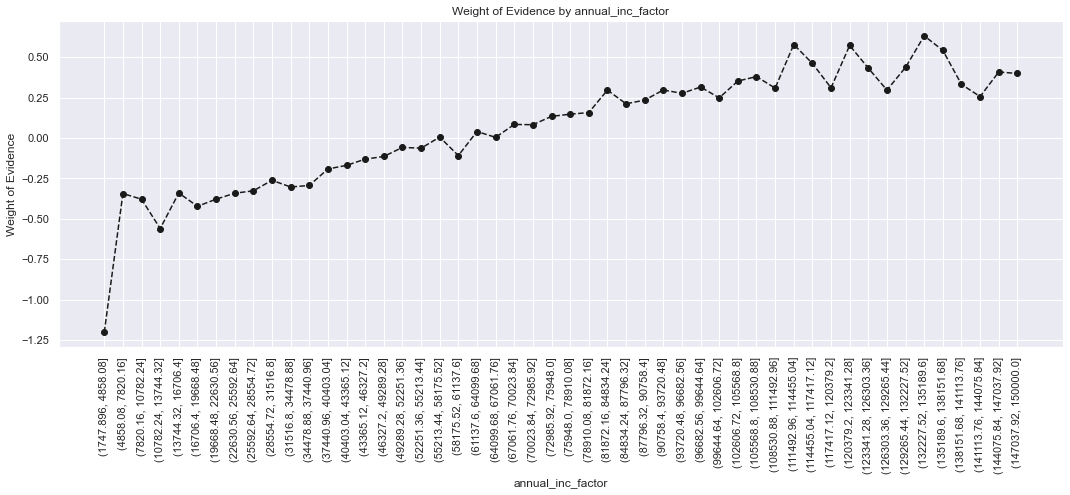

In [113]:
plot_by_woe(df_temp,90)

In [114]:
df_input_prep['annual_inc_<20K'] = np.where((df_input_prep['annual_inc'] <= 20000), 1, 0)
df_input_prep['annual_inc_20K-30K'] = np.where((df_input_prep['annual_inc'] > 20000) & (df_input_prep['annual_inc'] <= 30000), 1, 0)
df_input_prep['annual_inc_30K-40K'] = np.where((df_input_prep['annual_inc'] > 30000) & (df_input_prep['annual_inc'] <= 40000), 1, 0)
df_input_prep['annual_inc_40K-50K'] = np.where((df_input_prep['annual_inc'] > 40000) & (df_input_prep['annual_inc'] <= 50000), 1, 0)
df_input_prep['annual_inc_50K-60K'] = np.where((df_input_prep['annual_inc'] > 50000) & (df_input_prep['annual_inc'] <= 60000), 1, 0)
df_input_prep['annual_inc_60K-70K'] = np.where((df_input_prep['annual_inc'] > 60000) & (df_input_prep['annual_inc'] <= 70000), 1, 0)
df_input_prep['annual_inc_70K-80K'] = np.where((df_input_prep['annual_inc'] > 70000) & (df_input_prep['annual_inc'] <= 80000), 1, 0)
df_input_prep['annual_inc_80K-90K'] = np.where((df_input_prep['annual_inc'] > 80000) & (df_input_prep['annual_inc'] <= 90000), 1, 0)
df_input_prep['annual_inc_90K-100K'] = np.where((df_input_prep['annual_inc'] > 90000) & (df_input_prep['annual_inc'] <= 100000), 1, 0)
df_input_prep['annual_inc_100K-125K'] = np.where((df_input_prep['annual_inc'] > 100000) & (df_input_prep['annual_inc'] <= 125000), 1, 0)
df_input_prep['annual_inc_125K-150K'] = np.where((df_input_prep['annual_inc'] > 125000) & (df_input_prep['annual_inc'] <= 150000), 1, 0)
df_input_prep['annual_inc_>150K'] = np.where((df_input_prep['annual_inc'] > 150000), 1, 0)

In [115]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_delinq'])]
df_input_prep_temp['mths_since_last_delinq_factor'] = pd.cut(df_input_prep_temp['mths_since_last_delinq'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_delinq_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-115-66ad2c51f00c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['mths_since_last_delinq_factor'] = pd.cut(df_input_prep_temp['mths_since_last_delinq'], 50)


mths_since_last_delinq_factor  count  proportion_of_good  \
0                 (-0.188, 3.76]   4964            0.868453   
1                   (3.76, 7.52]  10346            0.886140   
2                  (7.52, 11.28]  12503            0.892426   
3                 (11.28, 15.04]  12535            0.889350   
4                  (15.04, 18.8]   8745            0.892510   
5                  (18.8, 22.56]  10967            0.893225   
6                 (22.56, 26.32]  10190            0.893131   
7                 (26.32, 30.08]   9939            0.895764   
8                 (30.08, 33.84]   7103            0.900465   
9                  (33.84, 37.6]   9110            0.897585   
10                 (37.6, 41.36]   8841            0.891867   
11                (41.36, 45.12]   8659            0.893983   
12                (45.12, 48.88]   6102            0.897575   
13                (48.88, 52.64]   6119            0.887236   
14                 (52.64, 56.4]   5622            0.895055   
15                 (56.4, 60.16]   5490            0.898907   
16                (60.16, 63.92]   3772            0.884411   
17                (63.92, 67.68]   5010            0.894611   
18                (67.68, 71.44]   4790            0.889979   
19                 (71.44, 75.2]   4597            0.887535   
20                 (75.2, 78.96]   3162            0.893738   
21                (78.96, 82.72]   3336            0.885492   
22                (82.72, 86.48]     82            0.780488   
23                (86.48, 90.24]     41            0.902439   
24                 (90.24, 94.0]     25            0.960000   
25                 (94.0, 97.76]     23            0.782609   
26               (97.76, 101.52]     12            1.000000   
27              (101.52, 105.28]      9            0.888889   
28              (105.28, 109.04]      9            0.777778   
29               (109.04, 112.8]      1            1.000000   
30               (112.8, 116.56]      5            1.000000   
31              (116.56, 120.32]      2            1.000000   
32              (120.32, 124.08]      4            1.000000   
33              (124.08, 127.84]      2            1.000000   
34               (127.84, 131.6]      6            1.000000   
35               (131.6, 135.36]      5            0.600000   
36              (135.36, 139.12]      1            1.000000   
37              (139.12, 142.88]      2            1.000000   
38              (142.88, 146.64]      2            1.000000   
39               (146.64, 150.4]      3            0.666667   
40               (150.4, 154.16]      2            0.500000   
41              (154.16, 157.92]      1            1.000000   
42              (157.92, 161.68]      1            1.000000   
43              (161.68, 165.44]      0                 NaN   
44               (165.44, 169.2]      0                 NaN   
45               (169.2, 172.96]      0                 NaN   
46              (172.96, 176.72]      0                 NaN   
47              (176.72, 180.48]      1            1.000000   
48              (180.48, 184.24]      0                 NaN   
49               (184.24, 188.0]      1            1.000000   

    proportion_of_count   n_good   n_bad  prop_n_good  prop_n_bad       WoE  \
0              0.030615   4311.0   653.0     0.029812    0.037242 -0.222537   
1              0.063808   9168.0  1178.0     0.063399    0.067184 -0.057984   
2              0.077111  11158.0  1345.0     0.077160    0.076708  0.005878   
3              0.077309  11148.0  1387.0     0.077091    0.079103 -0.025768   
4              0.053934   7805.0   940.0     0.053974    0.053610  0.006755   
5              0.067638   9796.0  1171.0     0.067742    0.066785  0.014231   
6              0.062846   9101.0  1089.0     0.062936    0.062108  0.013240   
7              0.061298   8903.0  1036.0     0.061566    0.059085  0.041136   
8              0.043807   6396.0   707.0     0.044230    0.040322  0.092513   

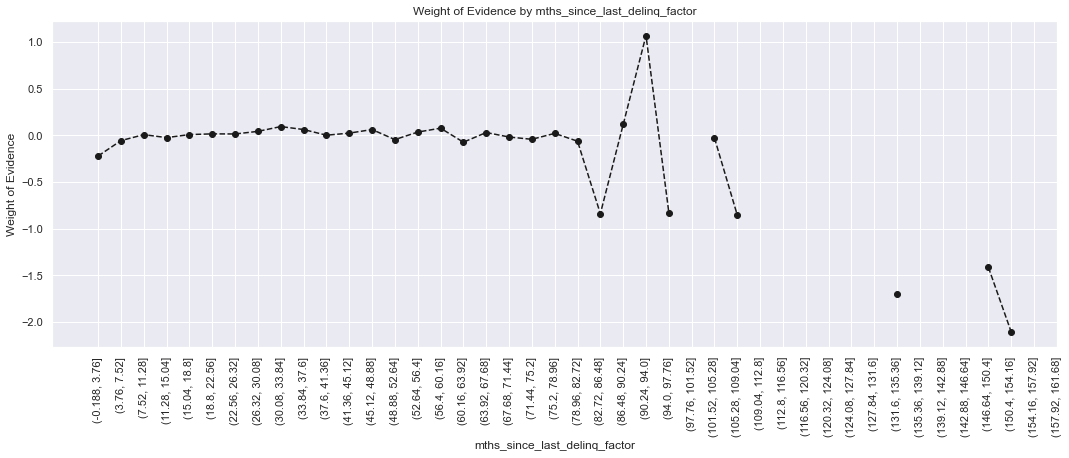

In [116]:
plot_by_woe(df_temp, 90)

In [117]:
df_input_prep['mths_since_last_delinq_Missing'] = np.where((df_input_prep['mths_since_last_delinq'].isnull()), 1, 0)
df_input_prep['mths_since_last_delinq_0-3'] = np.where((df_input_prep['mths_since_last_delinq'] >= 0) & (df_input_prep['mths_since_last_delinq'] <= 3), 1, 0)
df_input_prep['mths_since_last_delinq_4-30'] = np.where((df_input_prep['mths_since_last_delinq'] >= 4) & (df_input_prep['mths_since_last_delinq'] <= 30), 1, 0)
df_input_prep['mths_since_last_delinq_31-56'] = np.where((df_input_prep['mths_since_last_delinq'] >= 31) & (df_input_prep['mths_since_last_delinq'] <= 56), 1, 0)
df_input_prep['mths_since_last_delinq_>=57'] = np.where((df_input_prep['mths_since_last_delinq'] >= 57), 1, 0)

In [118]:
df_input_prep['dti_factor'] = pd.cut(df_input_prep['dti'], 100)
df_temp = woe_cont(df_input_prep, 'dti_factor', df_target_prep)
df_temp

dti_factor  count  proportion_of_good  proportion_of_count  n_good  \
0      (-0.04, 0.4]    693            0.877345             0.001982   608.0   
1        (0.4, 0.8]    760            0.913158             0.002173   694.0   
2        (0.8, 1.2]    888            0.900901             0.002539   800.0   
3        (1.2, 1.6]    950            0.895789             0.002717   851.0   
4        (1.6, 2.0]   1119            0.902592             0.003200  1010.0   
..              ...    ...                 ...                  ...     ...   
95  (37.991, 38.39]    185            0.854054             0.000529   158.0   
96   (38.39, 38.79]    176            0.886364             0.000503   156.0   
97   (38.79, 39.19]    179            0.837989             0.000512   150.0   
98   (39.19, 39.59]    176            0.926136             0.000503   163.0   
99   (39.59, 39.99]    188            0.904255             0.000538   170.0   

    n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    85.0     0.001953    0.002217 -0.126740  0.029028  
1    66.0     0.002229    0.001721  0.258554  0.029028  
2    88.0     0.002569    0.002295  0.113011  0.029028  
3    99.0     0.002733    0.002582  0.057029  0.029028  
4   109.0     0.003244    0.002842  0.132094  0.029028  
..    ...          ...         ...       ...       ...  
95   27.0     0.000507    0.000704 -0.327505  0.029028  
96   20.0     0.000501    0.000522 -0.040140  0.029028  
97   29.0     0.000482    0.000756 -0.450924  0.029028  
98   13.0     0.000524    0.000339  0.434537  0.029028  
99   18.0     0.000546    0.000469  0.151163  0.029028  

[100 rows x 10 columns]

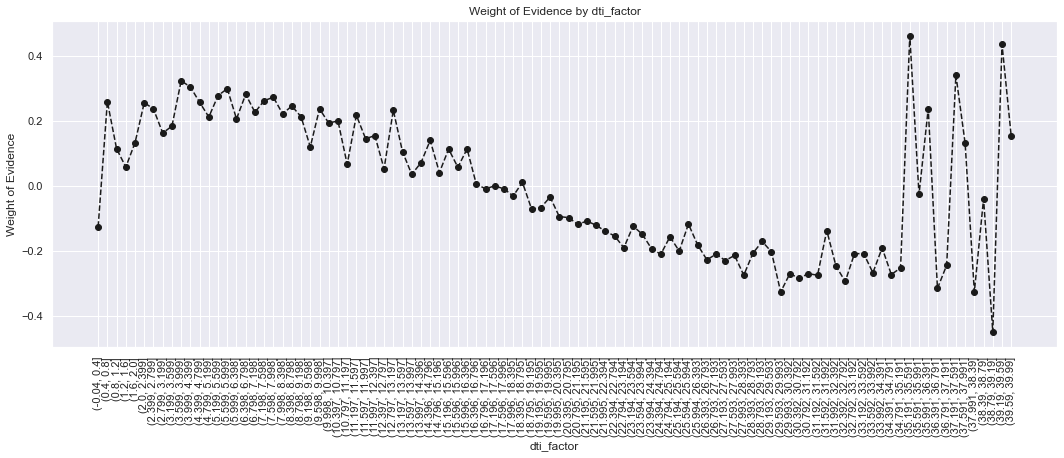

In [119]:
plot_by_woe(df_temp, 90)

In [120]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['dti'] <= 35, : ]

In [121]:
df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)
df_temp = woe_cont(df_input_prep_temp, 'dti_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-121-d89e3acf0a04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)


dti_factor  count  proportion_of_good  proportion_of_count   n_good  \
0   (-0.035, 0.7]   1280            0.892969             0.003689   1143.0   
1      (0.7, 1.4]   1562            0.899488             0.004501   1405.0   
2      (1.4, 2.1]   1880            0.906383             0.005418   1704.0   
3      (2.1, 2.8]   2418            0.909429             0.006968   2199.0   
4      (2.8, 3.5]   2962            0.907157             0.008536   2687.0   
5      (3.5, 4.2]   3644            0.914380             0.010501   3332.0   
6      (4.2, 4.9]   4359            0.915118             0.012561   3989.0   
7      (4.9, 5.6]   4975            0.911759             0.014336   4536.0   
8      (5.6, 6.3]   5561            0.913145             0.016025   5078.0   
9      (6.3, 7.0]   6128            0.911064             0.017659   5583.0   
10     (7.0, 7.7]   6899            0.914480             0.019881   6309.0   
11     (7.7, 8.4]   7596            0.911664             0.021889   6925.0   
12     (8.4, 9.1]   8173            0.910192             0.023552   7439.0   
13     (9.1, 9.8]   8668            0.905861             0.024978   7852.0   
14    (9.8, 10.5]   9298            0.909120             0.026794   8453.0   
15   (10.5, 11.2]   9952            0.900623             0.028678   8963.0   
16   (11.2, 11.9]  10202            0.907959             0.029399   9263.0   
17   (11.9, 12.6]  10785            0.900788             0.031079   9715.0   
18   (12.6, 13.3]  10930            0.904209             0.031497   9883.0   
19   (13.3, 14.0]  11237            0.897215             0.032381  10082.0   
20   (14.0, 14.7]  11510            0.900782             0.033168  10368.0   
21   (14.7, 15.4]  11121            0.895963             0.032047   9964.0   
22   (15.4, 16.1]  11361            0.898424             0.032739  10207.0   
23   (16.1, 16.8]  11273            0.895414             0.032485  10094.0   
24   (16.8, 17.5]  11450            0.889694             0.032995  10187.0   
25   (17.5, 18.2]  11195            0.892095             0.032260   9987.0   
26   (18.2, 18.9]  11067            0.883076             0.031892   9773.0   
27   (18.9, 19.6]  10557            0.886047             0.030422   9354.0   
28   (19.6, 20.3]  10425            0.882398             0.030041   9199.0   
29   (20.3, 21.0]  10310            0.882347             0.029710   9097.0   
30   (21.0, 21.7]   9603            0.878059             0.027673   8432.0   
31   (21.7, 22.4]   9229            0.877126             0.026595   8095.0   
32   (22.4, 23.1]   8830            0.871687             0.025445   7697.0   
33   (23.1, 23.8]   8600            0.876744             0.024782   7540.0   
34   (23.8, 24.5]   8196            0.870791             0.023618   7137.0   
35   (24.5, 25.2]   7505            0.869687             0.021627   6527.0   
36   (25.2, 25.9]   6556            0.874161             0.018892   5731.0   
37   (25.9, 26.6]   6214            0.869166             0.017907   5401.0   
38   (26.6, 27.3]   5756            0.868833             0.016587   5001.0   
39   (27.3, 28.0]   5574            0.866523             0.016062   4830.0   
40   (28.0, 28.7]   5214            0.865171             0.015025   4511.0   
41   (28.7, 29.4]   4836            0.868900             0.013936   4202.0   
42   (29.4, 30.1]   4254            0.858956             0.012259   3654.0   
43   (30.1, 30.8]   3209            0.860704             0.009247   2762.0   
44   (30.8, 31.5]   3053            0.859810             0.008798   2625.0   
45   (31.5, 32.2]   2743            0.873861             0.007904   2397.0   
46   (32.2, 32.9]   2479            0.859621             0.007144   2131.0   
47   (32.9, 33.6]   2292            0.866928             0.006605   1987.0   
48   (33.6, 34.3]   2242            0.865745             0.006461   1941.0   
49   (34.3, 35.0]   1857            0.858912             0.005351   1595.0   

     n_bad  prop_n_good  pro

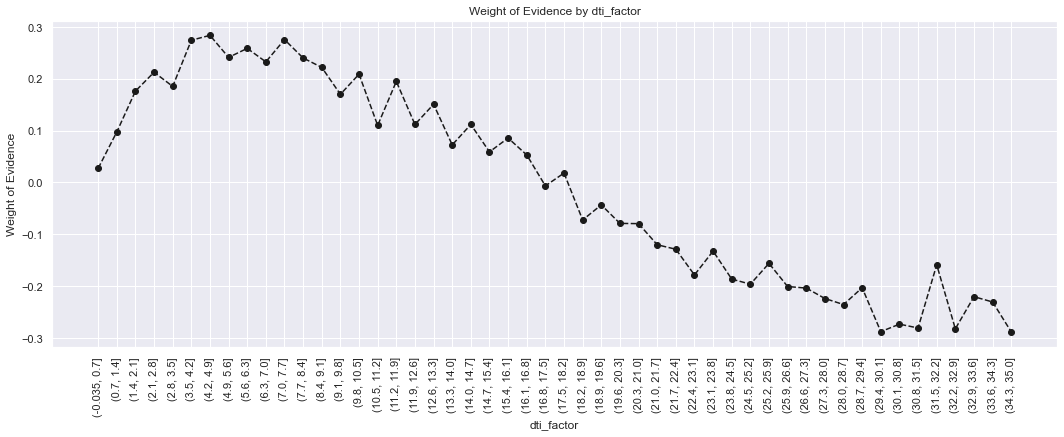

In [122]:
plot_by_woe(df_temp, 90)

In [123]:
df_input_prep['dti_<=1.4'] = np.where((df_input_prep['dti'] <= 1.4), 1, 0)
df_input_prep['dti_1.4-3.5'] = np.where((df_input_prep['dti'] > 1.4) & (df_input_prep['dti'] <= 3.5), 1, 0)
df_input_prep['dti_3.5-7.7'] = np.where((df_input_prep['dti'] > 3.5) & (df_input_prep['dti'] <= 7.7), 1, 0)
df_input_prep['dti_7.7-10.5'] = np.where((df_input_prep['dti'] > 7.7) & (df_input_prep['dti'] <= 10.5), 1, 0)
df_input_prep['dti_10.5-16.1'] = np.where((df_input_prep['dti'] > 10.5) & (df_input_prep['dti'] <= 16.1), 1, 0)
df_input_prep['dti_16.1-20.3'] = np.where((df_input_prep['dti'] > 16.1) & (df_input_prep['dti'] <= 20.3), 1, 0)
df_input_prep['dti_20.3-21.7'] = np.where((df_input_prep['dti'] > 20.3) & (df_input_prep['dti'] <= 21.7), 1, 0)
df_input_prep['dti_21.7-22.4'] = np.where((df_input_prep['dti'] > 21.7) & (df_input_prep['dti'] <= 22.4), 1, 0)
df_input_prep['dti_22.4-35'] = np.where((df_input_prep['dti'] > 22.4) & (df_input_prep['dti'] <= 35), 1, 0)
df_input_prep['dti_>35'] = np.where((df_input_prep['dti'] > 35), 1, 0)

In [124]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_record'])]
df_input_prep_temp['mths_since_last_record_factor'] = pd.cut(df_input_prep_temp['mths_since_last_record'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_record_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-124-1f7c4e8fb8ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['mths_since_last_record_factor'] = pd.cut(df_input_prep_temp['mths_since_last_record'], 50)


mths_since_last_record_factor  count  proportion_of_good  \
0                 (-0.121, 2.42]   1000            0.765000   
1                   (2.42, 4.84]     70            0.885714   
2                   (4.84, 7.26]    173            0.930636   
3                   (7.26, 9.68]    149            0.892617   
4                   (9.68, 12.1]    274            0.894161   
5                  (12.1, 14.52]    184            0.907609   
6                 (14.52, 16.94]    181            0.900552   
7                 (16.94, 19.36]    329            0.914894   
8                 (19.36, 21.78]    261            0.934866   
9                  (21.78, 24.2]    426            0.906103   
10                 (24.2, 26.62]    315            0.904762   
11                (26.62, 29.04]    565            0.904425   
12                (29.04, 31.46]    420            0.914286   
13                (31.46, 33.88]    475            0.917895   
14                 (33.88, 36.3]    749            0.921228   
15                 (36.3, 38.72]    619            0.933764   
16                (38.72, 41.14]    921            0.915309   
17                (41.14, 43.56]    782            0.928389   
18                (43.56, 45.98]    733            0.924966   
19                 (45.98, 48.4]   1264            0.919304   
20                 (48.4, 50.82]    905            0.930387   
21                (50.82, 53.24]   1443            0.918226   
22                (53.24, 55.66]    986            0.912779   
23                (55.66, 58.08]   1531            0.918354   
24                 (58.08, 60.5]   1053            0.907882   
25                 (60.5, 62.92]   1096            0.902372   
26                (62.92, 65.34]   1512            0.908730   
27                (65.34, 67.76]   1004            0.927291   
28                (67.76, 70.18]   1460            0.910274   
29                 (70.18, 72.6]    989            0.904954   
30                 (72.6, 75.02]   1352            0.904586   
31                (75.02, 77.44]    877            0.908780   
32                (77.44, 79.86]    881            0.904654   
33                (79.86, 82.28]   1266            0.888626   
34                 (82.28, 84.7]    666            0.894895   
35                 (84.7, 87.12]   1280            0.854688   
36                (87.12, 89.54]    798            0.877193   
37                (89.54, 91.96]    864            0.862269   
38                (91.96, 94.38]   1392            0.864943   
39                 (94.38, 96.8]   1043            0.857143   
40                 (96.8, 99.22]   1700            0.888824   
41               (99.22, 101.64]   1184            0.873311   
42              (101.64, 104.06]   1975            0.874937   
43              (104.06, 106.48]   1431            0.876310   
44               (106.48, 108.9]   1460            0.886986   
45               (108.9, 111.32]   2219            0.883281   
46              (111.32, 113.74]   1337            0.887809   
47              (113.74, 116.16]   1971            0.884830   
48              (116.16, 118.58]   1150            0.902609   
49               (118.58, 121.0]    325            0.883077   

    proportion_of_count  n_good  n_bad  prop_n_good  prop_n_bad       WoE  \
0              0.021259   765.0  235.0     0.018180    0.047379 -0.957877   
1              0.001488    62.0    8.0     0.001473    0.001613 -0.090474   
2              0.003678   161.0   12.0     0.003826    0.002419  0.458331   
3              0.003168   133.0   16.0     0.003161    0.003226 -0.020406   
4              0.005825   245.0   29.0     0.005822    0.005847 -0.004204   
5              0.003912   167.0   17.0     0.003969    0.003427  0.146614   
6              0.003848   163.0   18.0     0.003874    0.003629  0.065212   
7              0.006994   301.0   28.0     0.007153    0.005645  0.236739   
8              0.005548   244.0   17.0     0.005798    0.003427  0.525788   
9              0.00

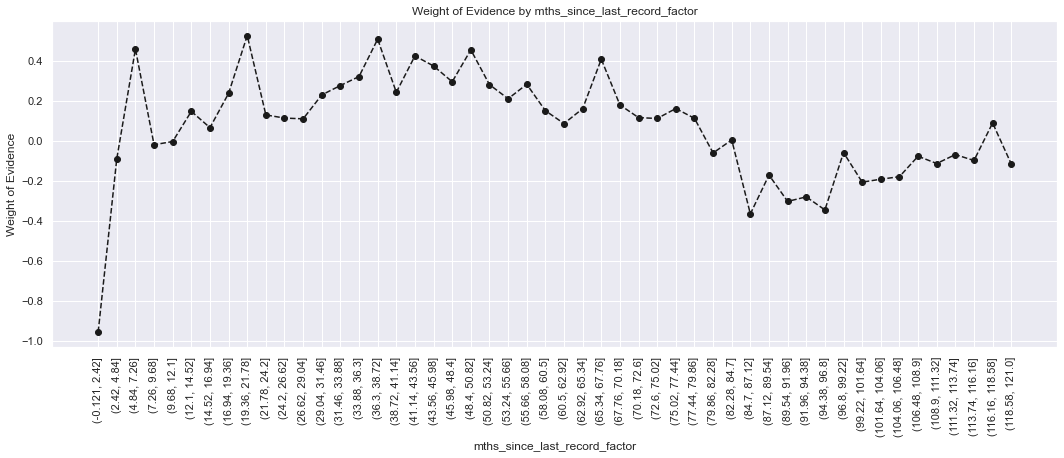

In [125]:
plot_by_woe(df_temp, 90)

In [126]:
df_input_prep['mths_since_last_record_Missing'] = np.where((df_input_prep['mths_since_last_record'].isnull()), 1, 0)
df_input_prep['mths_since_last_record_0-2'] = np.where((df_input_prep['mths_since_last_record'] >= 0) & (df_input_prep['mths_since_last_record'] <= 2), 1, 0)
df_input_prep['mths_since_last_record_3-20'] = np.where((df_input_prep['mths_since_last_record'] >= 3) & (df_input_prep['mths_since_last_record'] <= 20), 1, 0)
df_input_prep['mths_since_last_record_21-31'] = np.where((df_input_prep['mths_since_last_record'] >= 21) & (df_input_prep['mths_since_last_record'] <= 31), 1, 0)
df_input_prep['mths_since_last_record_32-80'] = np.where((df_input_prep['mths_since_last_record'] >= 32) & (df_input_prep['mths_since_last_record'] <= 80), 1, 0)
df_input_prep['mths_since_last_record_81-86'] = np.where((df_input_prep['mths_since_last_record'] >= 81) & (df_input_prep['mths_since_last_record'] <= 86), 1, 0)
df_input_prep['mths_since_last_record_>86'] = np.where((df_input_prep['mths_since_last_record'] > 86), 1, 0)

## Part C : Preparing Test Dataset

In [127]:
df_input_train = df_input_prep.copy()

In [128]:
df_input_prep = df_input_test.copy()
df_target_prep = df_target_test.copy()

### Weight of  Evidence for the Categorical Variables

In [129]:
dfprep = pd.concat([df_input_train['grade'],df_target_train],axis = 1)

In [130]:
dfprep.head()

grade  dependent
145391     D          0
392160     C          1
2469       C          1
308958     B          1
132941     B          1

In [131]:
total = dfprep.groupby(dfprep.columns.values[0], as_index=False)[dfprep.columns.values[1]].count()

In [132]:
mean = dfprep.groupby(dfprep.columns.values[0], as_index=False)[dfprep.columns.values[1]].mean()

In [133]:
dfprep = pd.merge(total, mean, on = 'grade')

In [134]:
dfprep.columns = [dfprep.columns.values[0], 'count', 'proportion_of_good']
dfprep['proportion_of_count'] = dfprep['count']/dfprep['count'].sum()

In [135]:
dfprep['n_good'] = dfprep['proportion_of_good']*dfprep['count']
dfprep['n_bad'] = (1-dfprep['proportion_of_good'])*dfprep['count']

In [136]:
dfprep['prop_n_good'] = dfprep['n_good']/dfprep['n_good'].sum() 
dfprep['prop_n_bad'] = dfprep['n_bad']/dfprep['n_bad'].sum() 

In [137]:
dfprep['WoE'] = np.log(dfprep['prop_n_good']/dfprep['prop_n_bad'])

In [138]:
dfprep

grade   count  proportion_of_good  proportion_of_count   n_good    n_bad  \
0     A   56039            0.960581             0.160243  53830.0   2209.0   
1     B  102821            0.921796             0.294015  94780.0   8041.0   
2     C   94020            0.885056             0.268849  83213.0  10807.0   
3     D   57574            0.845503             0.164632  48679.0   8895.0   
4     E   26828            0.803414             0.076714  21554.0   5274.0   
5     F    9915            0.757842             0.028352   7514.0   2401.0   
6     G    2516            0.713434             0.007194   1795.0    721.0   

   prop_n_good  prop_n_bad       WoE  
0     0.172884    0.057604  1.099028  
1     0.304402    0.209685  0.372741  
2     0.267252    0.281814 -0.053054  
3     0.156341    0.231955 -0.394505  
4     0.069224    0.137530 -0.686491  
5     0.024132    0.062611 -0.953381  
6     0.005765    0.018802 -1.182142

In [139]:
dfprep['IV'] = (dfprep['prop_n_good'] - dfprep['prop_n_bad'])*dfprep['WoE']
dfprep['IV'] = dfprep.IV.sum()
dfprep

grade   count  proportion_of_good  proportion_of_count   n_good    n_bad  \
0     A   56039            0.960581             0.160243  53830.0   2209.0   
1     B  102821            0.921796             0.294015  94780.0   8041.0   
2     C   94020            0.885056             0.268849  83213.0  10807.0   
3     D   57574            0.845503             0.164632  48679.0   8895.0   
4     E   26828            0.803414             0.076714  21554.0   5274.0   
5     F    9915            0.757842             0.028352   7514.0   2401.0   
6     G    2516            0.713434             0.007194   1795.0    721.0   

   prop_n_good  prop_n_bad       WoE       IV  
0     0.172884    0.057604  1.099028  0.29159  
1     0.304402    0.209685  0.372741  0.29159  
2     0.267252    0.281814 -0.053054  0.29159  
3     0.156341    0.231955 -0.394505  0.29159  
4     0.069224    0.137530 -0.686491  0.29159  
5     0.024132    0.062611 -0.953381  0.29159  
6     0.005765    0.018802 -1.182142  0.29159

Lets now use the weight of evidence function to all categorical variable

In [140]:
def woe(df, discrete, dependent_var_df):
    df = pd.concat([df[discrete], dependent_var_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'count', 'proportion_of_good']
    df['proportion_of_count'] = df['count']/df['count'].sum()
    df['n_good'] = df['proportion_of_good']*df['count']
    df['n_bad'] = (1-df['proportion_of_good'])*df['count']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum() 
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop=True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad'])*df['WoE']
    df['IV'] = df.IV.sum()
    return df
    

In [141]:
df_temp = woe(df_input_train, 'grade', df_target_train)
df_temp

grade   count  proportion_of_good  proportion_of_count   n_good    n_bad  \
0     G    2516            0.713434             0.007194   1795.0    721.0   
1     F    9915            0.757842             0.028352   7514.0   2401.0   
2     E   26828            0.803414             0.076714  21554.0   5274.0   
3     D   57574            0.845503             0.164632  48679.0   8895.0   
4     C   94020            0.885056             0.268849  83213.0  10807.0   
5     B  102821            0.921796             0.294015  94780.0   8041.0   
6     A   56039            0.960581             0.160243  53830.0   2209.0   

   prop_n_good  prop_n_bad       WoE       IV  
0     0.005765    0.018802 -1.182142  0.29159  
1     0.024132    0.062611 -0.953381  0.29159  
2     0.069224    0.137530 -0.686491  0.29159  
3     0.156341    0.231955 -0.394505  0.29159  
4     0.267252    0.281814 -0.053054  0.29159  
5     0.304402    0.209685  0.372741  0.29159  
6     0.172884    0.057604  1.099028  0.29159

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # a skin for matplot lib (to make it prettier)

In [143]:
def plot_by_woe(df_WoE, rotation_labels=0):
    x = np.array(df_WoE.iloc[:,0].apply(str)) #matplotlib is good with np than pd
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y, marker = 'o', linestyle='--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_labels)

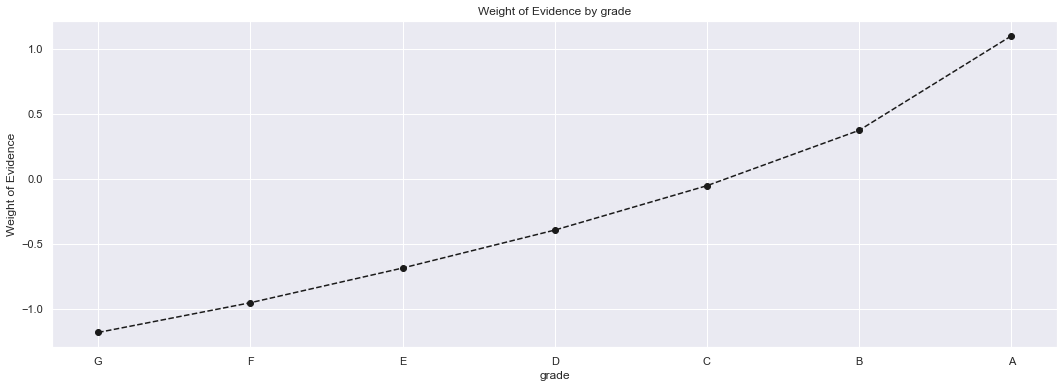

In [144]:
plot_by_woe(df_temp)

In [145]:
df_temp = woe(df_input_train,'home_ownership',df_target_train)
df_temp

home_ownership   count  proportion_of_good  proportion_of_count    n_good  \
0          OTHER     135            0.762963             0.000386     103.0   
1           NONE      41            0.853659             0.000117      35.0   
2           RENT  141419            0.873928             0.404386  123590.0   
3            OWN   31202            0.889815             0.089222   27764.0   
4       MORTGAGE  176915            0.903666             0.505886  159872.0   
5            ANY       1            1.000000             0.000003       1.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
0     32.0     0.000331    0.000834 -0.925270  inf  
1      6.0     0.000112    0.000156 -0.330675  inf  
2  17829.0     0.396930    0.464926 -0.158120  inf  
3   3438.0     0.089169    0.089653 -0.005413  inf  
4  17043.0     0.513455    0.444430  0.144370  inf  
5      0.0     0.000003    0.000000       inf  inf

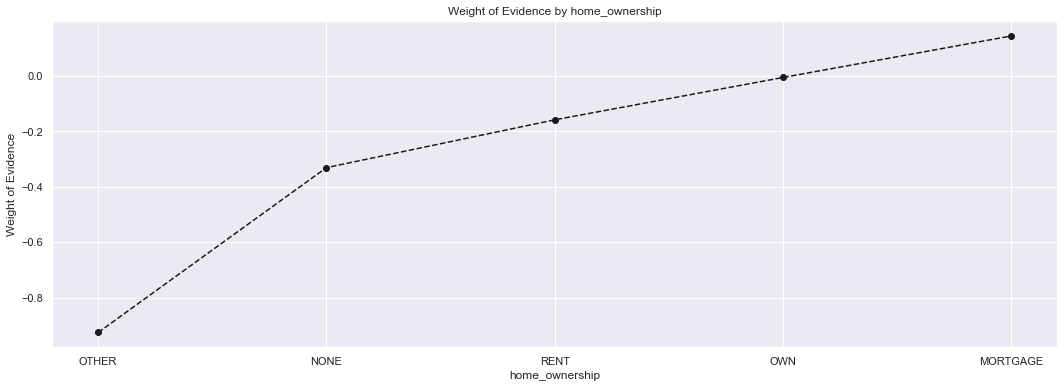

In [146]:
plot_by_woe(df_temp)

In [147]:
df_input_prep['home_ownership_RENT_OTHER_NONE_ANY']=  sum([df_input_prep['home_ownership_RENT'],
                                                          df_input_prep['home_ownership_OTHER'],
                                                          df_input_prep['home_ownership_NONE'],
                                                          df_input_prep['home_ownership_ANY']]
                                                         )

In [148]:
df_input_prep['addr_state'].unique()

array(['MD', 'VA', 'CA', 'MI', 'NV', 'NY', 'PA', 'WV', 'NJ', 'HI', 'AL',
       'MO', 'LA', 'TX', 'RI', 'WA', 'CT', 'MN', 'MA', 'AZ', 'CO', 'KY',
       'FL', 'OR', 'TN', 'OH', 'IL', 'GA', 'WI', 'NC', 'IN', 'WY', 'KS',
       'AK', 'UT', 'SC', 'VT', 'MS', 'OK', 'AR', 'NM', 'DC', 'MT', 'DE',
       'NH', 'SD', 'IA', 'ID', 'NE', 'ME'], dtype=object)

In [149]:
df_temp = woe(df_input_prep,'addr_state',df_target_prep)

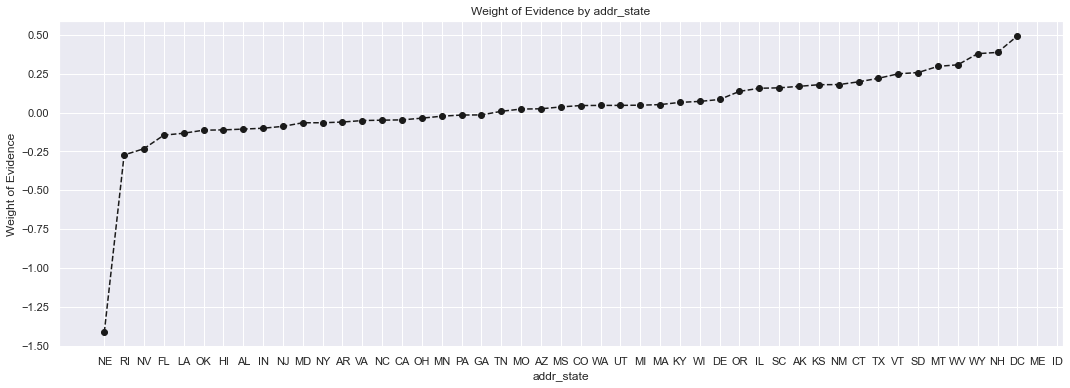

In [150]:
plot_by_woe(df_temp)

In [151]:
if ['addr_state_ND'] in df_input_prep.columns.values:
    pass
else:
    df_input_prep['addr_state_ND'] = 0

In [152]:
#first lets seperate state with high value into its own categories
df_temp.sort_values(by ='count', ascending=False)

#CA, NY, TX and FL is high in count so it should be seperate into its own categories

addr_state  count  proportion_of_good  proportion_of_count   n_good  \
15         CA  17870            0.887185             0.153296  15854.0   
11         NY   9932            0.885320             0.085201   8793.0   
39         TX   9046            0.911342             0.077600   8244.0   
3          FL   7810            0.876953             0.066997   6849.0   
33         IL   4734            0.905999             0.040610   4289.0   
9          NJ   4630            0.882937             0.039718   4088.0   
18         PA   4128            0.890262             0.035412   3675.0   
16         OH   3822            0.888278             0.032787   3395.0   
19         GA   3748            0.890342             0.032152   3337.0   
13         VA   3585            0.886750             0.030754   3179.0   
14         NC   3221            0.886992             0.027631   2857.0   
27         MI   2874            0.896312             0.024654   2576.0   
28         MA   2835            0.896649             0.024320   2542.0   
25         WA   2697            0.896181             0.023136   2417.0   
22         AZ   2673            0.894126             0.022930   2390.0   
10         MD   2668            0.885307             0.022887   2362.0   
24         CO   2406            0.896093             0.020640   2156.0   
17         MN   2064            0.889535             0.017706   1836.0   
38         CT   1878            0.909478             0.016110   1708.0   
21         MO   1877            0.893980             0.016102   1678.0   
2          NV   1642            0.867235             0.014086   1424.0   
8          IN   1589            0.881687             0.013631   1401.0   
30         WI   1518            0.898551             0.013022   1364.0   
20         TN   1471            0.892590             0.012619   1313.0   
7          AL   1455            0.881100             0.012482   1282.0   
32         OR   1442            0.904300             0.012370   1304.0   
34         SC   1376            0.906250             0.011804   1247.0   
4          LA   1372            0.878280             0.011770   1205.0   
29         KY   1088            0.897978             0.009333    977.0   
36         KS   1032            0.907946             0.008853    937.0   
5          OK   1003            0.880359             0.008604    883.0   
12         AR    893            0.885778             0.007661    791.0   
26         UT    867            0.896194             0.007437    777.0   
43         WV    635            0.918110             0.005447    583.0   
6          HI    628            0.880573             0.005387    553.0   
37         NM    587            0.908007             0.005036    533.0   
45         NH    552            0.923913             0.004735    510.0   
1          RI    531            0.862524             0.004555    458.0   
42         MT    363            0.917355             0.003114    333.0   
46         DC    348            0.931034             0.002985    324.0   
35         AK    312            0.907051             0.002676    283.0   
31         DE    309            0.899676             0.002651    278.0   
23         MS    296            0.895270             0.002539    265.0   
44         WY    287            0.923345             0.002462    265.0   
41         SD    245            0.914286             0.002102    224.0   
40         VT    220            0.913636             0.001887    201.0   
48         ID      5            1.000000             0.000043      5.0   
0          NE      3            0.666667             0.000026      2.0   
49         IA      3            1.000000             0.000026      3.0   
47         ME      2            1.000000             0.000017      2.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
15  2016.0     0.152513    0.159746 -0.046340  inf  
11  1139.0     0.084587    0.090254 -0.064841  inf  
39   802.0     0.079306    0.063550  0.221486  inf  
3    961.0     0

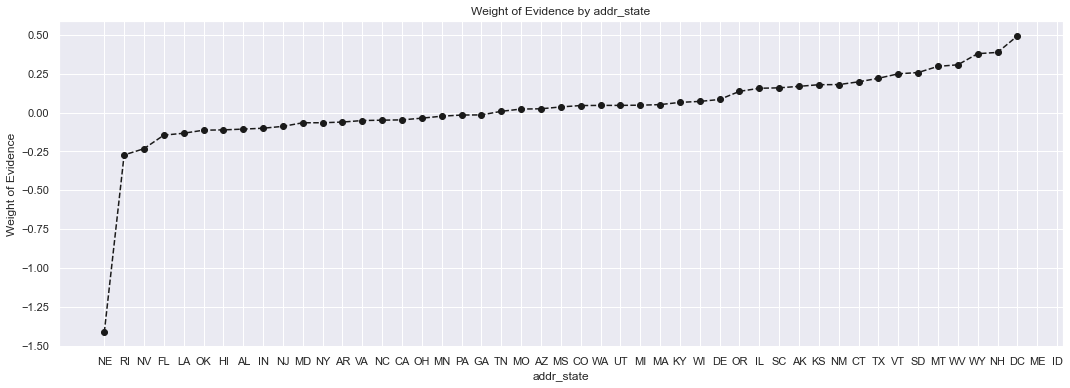

In [153]:
plot_by_woe(df_temp.iloc[:, :])

In [154]:
df_input_prep['addr_state_ND_NE_IA_NV_FL_HI_AL'] = sum([df_input_prep['addr_state_ND'], df_input_prep['addr_state_NE'],
                                                         df_input_prep['addr_state_IA'], df_input_prep['addr_state_NV'],
                                                         df_input_prep['addr_state_FL'], df_input_prep['addr_state_HI'],
                                                         df_input_prep['addr_state_AL']])

df_input_prep['addr_state_NM_VA'] = sum([df_input_prep['addr_state_NM'], df_input_prep['addr_state_VA']])

df_input_prep['addr_state_OK_TN_MO_LA_MD_NC'] = sum([df_input_prep['addr_state_OK'], df_input_prep['addr_state_TN'],
                                              df_input_prep['addr_state_MO'], df_input_prep['addr_state_LA'],
                                              df_input_prep['addr_state_MD'], df_input_prep['addr_state_NC']])

df_input_prep['addr_state_UT_KY_AZ_NJ'] = sum([df_input_prep['addr_state_UT'], df_input_prep['addr_state_KY'],
                                              df_input_prep['addr_state_AZ'], df_input_prep['addr_state_NJ']])

df_input_prep['addr_state_AR_MI_PA_OH_MN'] = sum([df_input_prep['addr_state_AR'], df_input_prep['addr_state_MI'],
                                              df_input_prep['addr_state_PA'], df_input_prep['addr_state_OH'],
                                              df_input_prep['addr_state_MN']])

df_input_prep['addr_state_RI_MA_DE_SD_IN'] = sum([df_input_prep['addr_state_RI'], df_input_prep['addr_state_MA'],
                                              df_input_prep['addr_state_DE'], df_input_prep['addr_state_SD'],
                                              df_input_prep['addr_state_IN']])

df_input_prep['addr_state_GA_WA_OR'] = sum([df_input_prep['addr_state_GA'], df_input_prep['addr_state_WA'],
                                              df_input_prep['addr_state_OR']])

df_input_prep['addr_state_WI_MT'] = sum([df_input_prep['addr_state_WI'], df_input_prep['addr_state_MT']])

df_input_prep['addr_state_IL_CT'] = sum([df_input_prep['addr_state_IL'], df_input_prep['addr_state_CT']])

df_input_prep['addr_state_KS_SC_CO_VT_AK_MS'] = sum([df_input_prep['addr_state_KS'], df_input_prep['addr_state_SC'],
                                              df_input_prep['addr_state_CO'], df_input_prep['addr_state_VT'],
                                              df_input_prep['addr_state_AK'], df_input_prep['addr_state_MS']])

df_input_prep['addr_state_WV_NH_WY_DC_ME_ID'] = sum([df_input_prep['addr_state_WV'], df_input_prep['addr_state_NH'],
                                              df_input_prep['addr_state_WY'], df_input_prep['addr_state_DC'],
                                              df_input_prep['addr_state_ME'], df_input_prep['addr_state_ID']])

In [155]:
df_temp = woe(df_input_prep, 'verification_status', df_target_prep)
df_temp

verification_status  count  proportion_of_good  proportion_of_count  \
0            Verified  42086            0.872808              0.36103   
1     Source Verified  37577            0.899300              0.32235   
2        Not Verified  36909            0.905633              0.31662   

    n_good   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0  36733.0  5353.0     0.353365    0.424168 -0.182628  0.021932  
1  33793.0  3784.0     0.325083    0.299842  0.080826  0.021932  
2  33426.0  3483.0     0.321552    0.275990  0.152794  0.021932

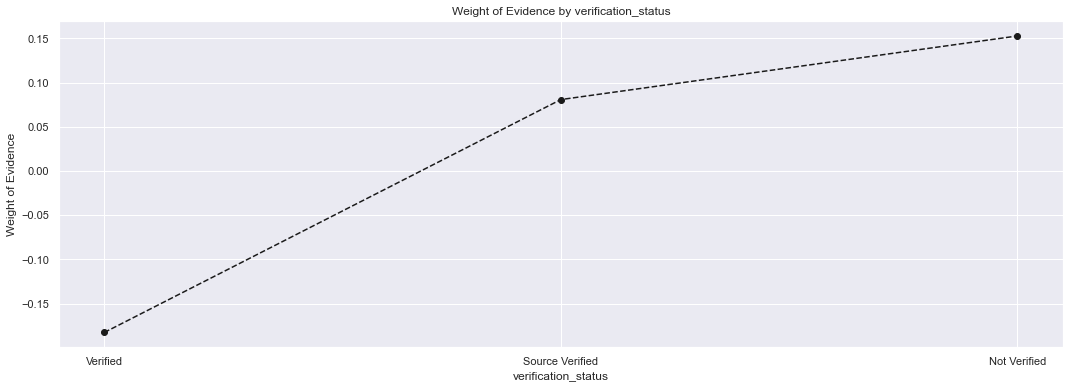

In [156]:
plot_by_woe(df_temp)

In [157]:
df_temp = woe(df_input_prep, 'purpose', df_target_prep)
df_temp

purpose  count  proportion_of_good  proportion_of_count  \
0       small_business   1697            0.783736             0.014558   
1               moving    718            0.856546             0.006159   
2                other   5776            0.865824             0.049549   
3          educational    100            0.870000             0.000858   
4              medical   1171            0.873612             0.010045   
5                house    546            0.875458             0.004684   
6             vacation    610            0.877049             0.005233   
7     renewable_energy     92            0.880435             0.000789   
8   debt_consolidation  68751            0.886125             0.589773   
9              wedding    582            0.886598             0.004993   
10      major_purchase   2483            0.898510             0.021300   
11                 car   1335            0.904120             0.011452   
12    home_improvement   6630            0.908296             0.056875   
13         credit_card  26081            0.916529             0.223733   

     n_good   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    1330.0   367.0     0.012794    0.029081 -0.821074  0.038546  
1     615.0   103.0     0.005916    0.008162 -0.321753  0.038546  
2    5001.0   775.0     0.048109    0.061410 -0.244116  0.038546  
3      87.0    13.0     0.000837    0.001030 -0.207688  0.038546  
4    1023.0   148.0     0.009841    0.011727 -0.175364  0.038546  
5     478.0    68.0     0.004598    0.005388 -0.158543  0.038546  
6     535.0    75.0     0.005147    0.005943 -0.143868  0.038546  
7      81.0    11.0     0.000779    0.000872 -0.112093  0.038546  
8   60922.0  7829.0     0.586059    0.620365 -0.056887  0.038546  
9     516.0    66.0     0.004964    0.005230 -0.052194  0.038546  
10   2231.0   252.0     0.021462    0.019968  0.072130  0.038546  
11   1207.0   128.0     0.011611    0.010143  0.135217  0.038546  
12   6022.0   608.0     0.057931    0.048177  0.184353  0.038546  
13  23904.0  2177.0     0.229952    0.172504  0.287452  0.038546

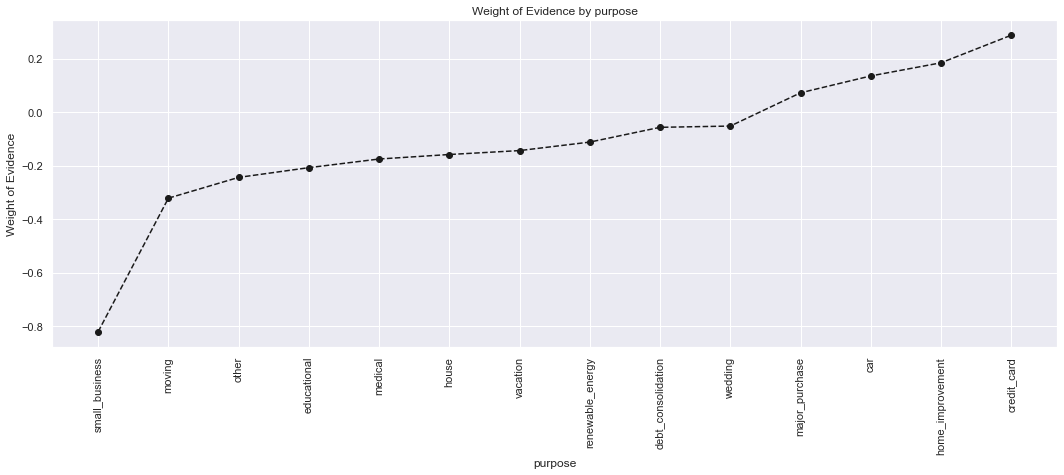

In [158]:
plot_by_woe(df_temp, 90)

In [159]:
df_input_prep['purpose_sm_b_educ'] = sum([ df_input_prep['purpose_small_business'],df_input_prep['purpose_educational']])
df_input_prep['purpose_ren_en_mov_house_other'] = sum([df_input_prep['purpose_renewable_energy'],df_input_prep['purpose_moving'], df_input_prep['purpose_house'],df_input_prep['purpose_other']])
df_input_prep['purpose_med_wed_vac'] = sum([df_input_prep['purpose_medical'],df_input_prep['purpose_wedding'],df_input_prep['purpose_vacation']])
df_input_prep['purpose_major_purch__car__home_impr'] = sum([df_input_prep['purpose_major_purchase'], df_input_prep['purpose_car'],df_input_prep['purpose_home_improvement']])

### Weight of Evidence for Continuous Variable

In [160]:
def woe_cont(df, discrete, dependent_var_df):
    df = pd.concat([df[discrete], dependent_var_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'count', 'proportion_of_good']
    df['proportion_of_count'] = df['count']/df['count'].sum()
    df['n_good'] = df['proportion_of_good']*df['count']
    df['n_bad'] = (1-df['proportion_of_good'])*df['count']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum() 
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop=True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad'])*df['WoE']
    df['IV'] = df.IV.sum() 
    return df

In [161]:
df_temp = woe_cont(df_input_prep, 'term', df_target_prep)
df_temp

term  count  proportion_of_good  proportion_of_count   n_good   n_bad  \
0    36  84490            0.903042             0.724788  76298.0  8192.0   
1    60  32082            0.861979             0.275212  27654.0  4428.0   

   prop_n_good  prop_n_bad       WoE       IV  
0     0.733973    0.649128  0.122842  0.03391  
1     0.266027    0.350872 -0.276824  0.03391

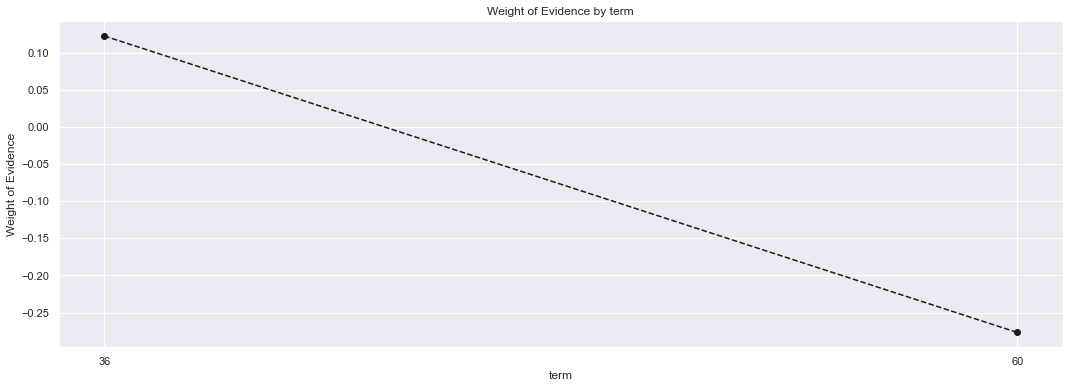

In [162]:
plot_by_woe(df_temp)

In [163]:
df_input_prep['term_36'] = np.where((df_input_prep['term']==36),1,0)
df_input_prep['term_60'] = np.where((df_input_prep['term']==60),1,0)

In [164]:
df_temp = woe_cont(df_input_prep, 'emp_length_int', df_target_prep)
df_temp

emp_length_int  count  proportion_of_good  proportion_of_count   n_good  \
0                0  14355            0.879276             0.123143  12622.0   
1                1   7466            0.894053             0.064046   6675.0   
2                2  10240            0.888086             0.087843   9094.0   
3                3   9015            0.891514             0.077334   8037.0   
4                4   6857            0.891352             0.058822   6112.0   
5                5   7768            0.883110             0.066637   6860.0   
6                6   6560            0.881402             0.056274   5782.0   
7                7   6539            0.890656             0.056094   5824.0   
8                8   5553            0.888349             0.047636   4933.0   
9                9   4451            0.887890             0.038182   3952.0   
10              10  37768            0.901848             0.323989  34061.0   

     n_bad  prop_n_good  prop_n_bad       WoE        IV  
0   1733.0     0.121421    0.137322 -0.123059  0.007086  
1    791.0     0.064212    0.062678  0.024180  0.007086  
2   1146.0     0.087483    0.090808 -0.037309  0.007086  
3    978.0     0.077315    0.077496 -0.002345  0.007086  
4    745.0     0.058796    0.059033 -0.004021  0.007086  
5    908.0     0.065992    0.071949 -0.086428  0.007086  
6    778.0     0.055622    0.061648 -0.102868  0.007086  
7    715.0     0.056026    0.056656 -0.011186  0.007086  
8    620.0     0.047455    0.049128 -0.034663  0.007086  
9    499.0     0.038018    0.039540 -0.039275  0.007086  
10  3707.0     0.327661    0.293740  0.109284  0.007086

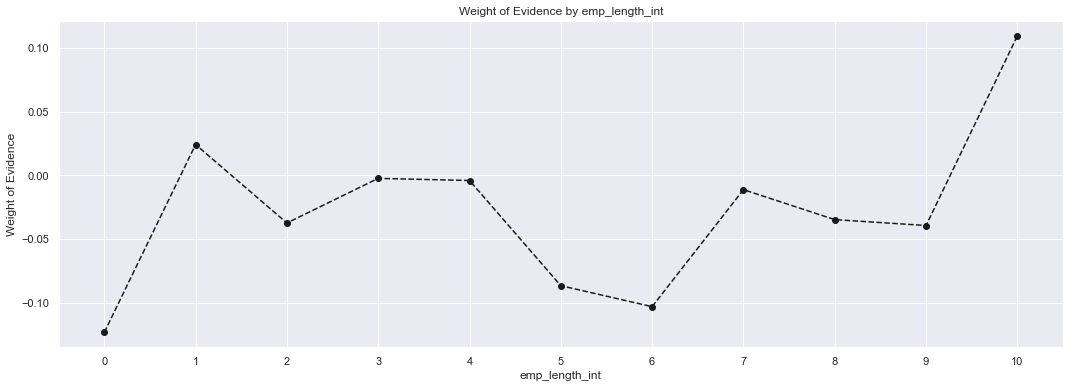

In [165]:
plot_by_woe(df_temp)

In [166]:
df_input_prep['emp_length_int_0'] = np.where(df_input_prep['emp_length_int'].isin([0]),1,0)
df_input_prep['emp_length_int_1-3'] = np.where(df_input_prep['emp_length_int'].isin(range(1,4)),1,0)
df_input_prep['emp_length_int_4'] = np.where(df_input_prep['emp_length_int'].isin([4]),1,0)
df_input_prep['emp_length_int_5-6'] = np.where(df_input_prep['emp_length_int'].isin(range(5,7)),1,0)
df_input_prep['emp_length_int_7-9'] = np.where(df_input_prep['emp_length_int'].isin(range(7,10)),1,0)
df_input_prep['emp_length_int_10'] = np.where(df_input_prep['emp_length_int'].isin([10]),1,0)                                               

In [167]:
df_input_prep.issue_d_in_mnths.unique() 

array([ 50.,  39.,  38.,  58.,  46.,  60.,  37.,  43.,  69.,  53.,  41.,
        59.,  84.,  44.,  51.,  55.,  57.,  88.,  42.,  54.,  48.,  67.,
        65.,  47.,  45.,  98.,  83.,  66.,  73.,  61.,  64.,  52.,  56.,
        85.,  49.,  68.,  74.,  86.,  87.,  91., 114.,  63.,  71.,  40.,
       110.,  75.,  72.,  81.,  77.,  62.,  70., 118., 119.,  97.,  82.,
        78., 107.,  94.,  92.,  96.,  79.,  76.,  80.,  90., 125., 104.,
        95., 120.,  89., 103., 102., 116., 113., 124.,  93., 106., 117.,
       101., 111., 121., 115., 108., 105., 109.,  99., 126., 100., 123.,
       127., 112., 122.])

In [168]:
df_input_prep['issue_d_in_mnths_factor'] = pd.cut(df_input_prep['issue_d_in_mnths'],50)

In [169]:
df_input_prep['issue_d_in_mnths_factor']

56463      (49.6, 51.4]
274696     (38.8, 40.6]
241265    (36.91, 38.8]
163692     (56.8, 58.6]
421889     (44.2, 46.0]
              ...      
109387     (51.4, 53.2]
194891     (62.2, 64.0]
83843      (49.6, 51.4]
223890     (69.4, 71.2]
275200     (38.8, 40.6]
Name: issue_d_in_mnths_factor, Length: 116572, dtype: category
Categories (50, interval[float64]): [(36.91, 38.8] < (38.8, 40.6] < (40.6, 42.4] < (42.4, 44.2] ... (119.8, 121.6] < (121.6, 123.4] < (123.4, 125.2] < (125.2, 127.0]]

In [170]:
df_temp = woe_cont(df_input_prep, 'issue_d_in_mnths_factor', df_target_prep)

In [171]:
df_temp

issue_d_in_mnths_factor  count  proportion_of_good  proportion_of_count  \
0            (36.91, 38.8]   8752            0.942299             0.075078   
1             (38.8, 40.6]  12454            0.929902             0.106835   
2             (40.6, 42.4]  12283            0.919238             0.105368   
3             (42.4, 44.2]   8968            0.908006             0.076931   
4             (44.2, 46.0]   8834            0.906611             0.075781   
5             (46.0, 47.8]   3872            0.900568             0.033216   
6             (47.8, 49.6]   7577            0.900752             0.064998   
7             (49.6, 51.4]   7226            0.893302             0.061987   
8             (51.4, 53.2]   6373            0.881218             0.054670   
9             (53.2, 55.0]   5749            0.865890             0.049317   
10            (55.0, 56.8]   2553            0.849197             0.021901   
11            (56.8, 58.6]   4368            0.857601             0.037470   
12            (58.6, 60.4]   3573            0.851665             0.030651   
13            (60.4, 62.2]   3148            0.852922             0.027005   
14            (62.2, 64.0]   3159            0.855017             0.027099   
15            (64.0, 65.8]   1353            0.844050             0.011607   
16            (65.8, 67.6]   2092            0.827916             0.017946   
17            (67.6, 69.4]   1678            0.840882             0.014395   
18            (69.4, 71.2]   1382            0.858177             0.011855   
19            (71.2, 73.0]   1233            0.840227             0.010577   
20            (73.0, 74.8]    539            0.846011             0.004624   
21            (74.8, 76.6]   1049            0.860820             0.008999   
22            (76.6, 78.4]    992            0.836694             0.008510   
23            (78.4, 80.2]    886            0.846501             0.007600   
24            (80.2, 82.0]    733            0.874488             0.006288   
25            (82.0, 83.8]    331            0.870091             0.002839   
26            (83.8, 85.6]    650            0.889231             0.005576   
27            (85.6, 87.4]    596            0.840604             0.005113   
28            (87.4, 89.2]    565            0.844248             0.004847   
29            (89.2, 91.0]    568            0.855634             0.004873   
30            (91.0, 92.8]    236            0.847458             0.002024   
31            (92.8, 94.6]    425            0.882353             0.003646   
32            (94.6, 96.4]    338            0.866864             0.002899   
33            (96.4, 98.2]    327            0.862385             0.002805   
34           (98.2, 100.0]    284            0.830986             0.002436   
35          (100.0, 101.8]    119            0.857143             0.001021   
36          (101.8, 103.6]    193            0.891192             0.001656   
37          (103.6, 105.4]    149            0.879195             0.001278   
38          (105.4, 107.2]    158            0.879747             0.001355   
39          (107.2, 109.0]    125            0.824000             0.001072   
40          (109.0, 110.8]     54            0.814815             0.000463   
41          (110.8, 112.6]     51            0.843137             0.000437   
42          (112.6, 114.4]     68            0.823529             0.000583   
43          (114.4, 116.2]     54            0.833333             0.000463   
44          (116.2, 118.0]    164            0.768293             0.001407   
45          (118.0, 119.8]     72            0.777778             0.000618   
46          (119.8, 121.6]    122            0.631148             0.001047   
47          (121.6, 123.4]     50            0.800000             0.000429   
48          (123.4, 125.2]     32            0.812500             0.000275   
49          (125.2, 127.0]     15            0.933333             0.000129   

     n_good  n_bad  prop

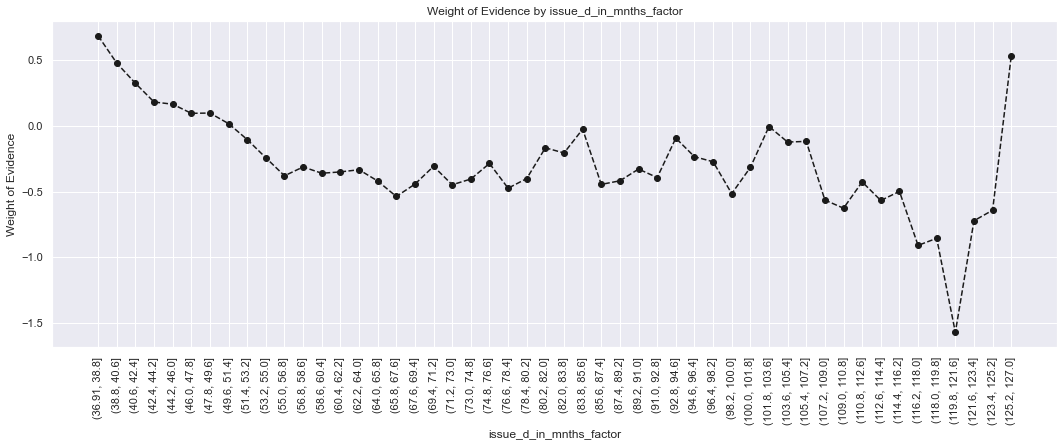

In [172]:
plot_by_woe(df_temp, 90)

In [173]:
df_input_prep['issue_d_in_mnths_<39'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(39)), 1, 0)
df_input_prep['issue_d_in_mnths_39-40'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(39, 41)), 1, 0)
df_input_prep['issue_d_in_mnths_41-42'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(41, 43)), 1, 0)
df_input_prep['issue_d_in_mnths_43-48'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(43, 49)), 1, 0)
df_input_prep['issue_d_in_mnths_49-54'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(49, 55)), 1, 0)
df_input_prep['issue_d_in_mnths_55-66'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(55, 67)), 1, 0)
df_input_prep['issue_d_in_mnths_67-84'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(67, 85)), 1, 0)
df_input_prep['issue_d_in_mnths_>84'] = np.where(df_input_prep['issue_d_in_mnths'].isin(range(85, int(df_input_prep['issue_d_in_mnths'].max()))), 1, 0)

In [174]:
df_input_prep['int_rate_factor'] = pd.cut(df_input_prep['int_rate'],50)

In [175]:
df_temp = woe_cont(df_input_prep,'int_rate_factor',df_target_prep)
df_temp

int_rate_factor  count  proportion_of_good  proportion_of_count  n_good  \
0     (5.399, 5.833]    243            0.967078             0.002085   235.0   
1     (5.833, 6.246]   2688            0.978423             0.023059  2630.0   
2     (6.246, 6.658]   2445            0.973415             0.020974  2380.0   
3     (6.658, 7.071]    608            0.976974             0.005216   594.0   
4     (7.071, 7.484]   1025            0.979512             0.008793  1004.0   
5     (7.484, 7.897]   3939            0.964204             0.033790  3798.0   
6      (7.897, 8.31]   2953            0.953945             0.025332  2817.0   
7      (8.31, 8.722]   2132            0.963884             0.018289  2055.0   
8     (8.722, 9.135]   2989            0.942456             0.025641  2817.0   
9     (9.135, 9.548]   2073            0.963338             0.017783  1997.0   
10    (9.548, 9.961]   2321            0.931495             0.019910  2162.0   
11   (9.961, 10.374]   3347            0.931581             0.028712  3118.0   
12  (10.374, 10.786]   1770            0.912429             0.015184  1615.0   
13  (10.786, 11.199]   5648            0.933251             0.048451  5271.0   
14  (11.199, 11.612]   1572            0.917939             0.013485  1443.0   
15  (11.612, 12.025]   4846            0.931490             0.041571  4514.0   
16  (12.025, 12.438]   3859            0.895051             0.033104  3454.0   
17   (12.438, 12.85]   3453            0.922676             0.029621  3186.0   
18   (12.85, 13.263]   6604            0.904452             0.056652  5973.0   
19  (13.263, 13.676]   4842            0.902520             0.041537  4370.0   
20  (13.676, 14.089]   3369            0.902345             0.028901  3040.0   
21  (14.089, 14.502]   7211            0.886840             0.061859  6395.0   
22  (14.502, 14.914]   1386            0.865079             0.011890  1199.0   
23  (14.914, 15.327]   5954            0.878233             0.051076  5229.0   
24   (15.327, 15.74]   3843            0.879781             0.032967  3381.0   
25   (15.74, 16.153]   2321            0.834985             0.019910  1938.0   
26  (16.153, 16.566]   4115            0.862454             0.035300  3549.0   
27  (16.566, 16.978]   1318            0.847496             0.011306  1117.0   
28  (16.978, 17.391]   3597            0.856547             0.030856  3081.0   
29  (17.391, 17.804]   3766            0.837759             0.032306  3155.0   
30  (17.804, 18.217]    405            0.851852             0.003474   345.0   
31   (18.217, 18.63]   3421            0.843905             0.029347  2887.0   
32   (18.63, 19.042]   2223            0.819163             0.019070  1821.0   
33  (19.042, 19.455]   1395            0.784229             0.011967  1094.0   
34  (19.455, 19.868]   2172            0.828269             0.018632  1799.0   
35  (19.868, 20.281]   1526            0.846658             0.013091  1292.0   
36  (20.281, 20.694]    974            0.811088             0.008355   790.0   
37  (20.694, 21.106]   1261            0.812054             0.010817  1024.0   
38  (21.106, 21.519]    863            0.780997             0.007403   674.0   
39  (21.519, 21.932]    305            0.757377             0.002616   231.0   
40  (21.932, 22.345]   1095            0.789041             0.009393   864.0   
41  (22.345, 22.758]    696            0.765805             0.005971   533.0   
42   (22.758, 23.17]    502            0.762948             0.004306   383.0   
43   (23.17, 23.583]    808            0.795792             0.006931   643.0   
44  (23.583, 23.996]    501            0.730539             0.004298   366.0   
45  (23.996, 24.409]    417            0.776978             0.003577   324.0   
46  (24.409, 24.822]    558            0.772401             0.004787   431.0   
47  (24.822, 25.234]    404            0.779703             0.003466   315.0   
48  (25.234, 25.647]    248            0.741935             0.002127   184.0   
49   

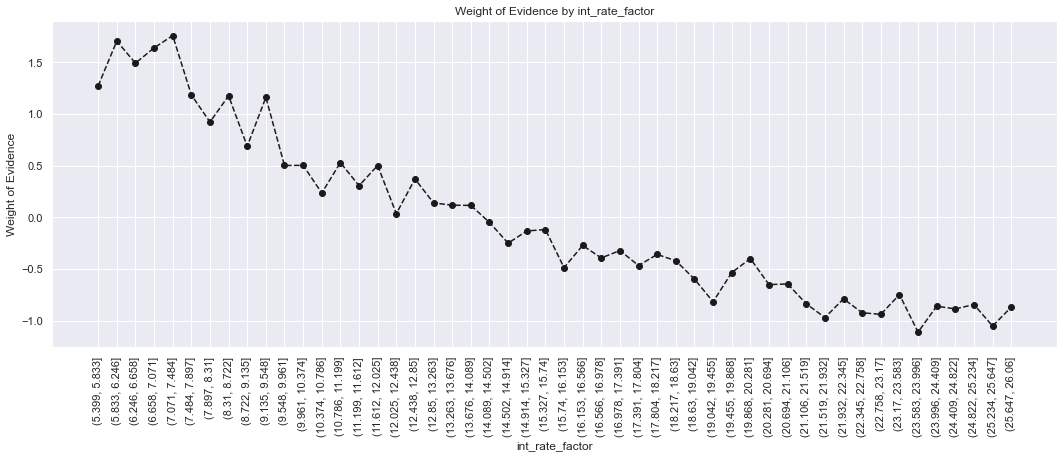

In [176]:
plot_by_woe(df_temp, 90)

In [177]:
df_input_prep['int_rate_<9.548'] = np.where((df_input_prep['int_rate']<=9.548),1,0)
df_input_prep['int_rate_9.548-12.025'] =np.where((df_input_prep['int_rate']>9.548)&(df_input_prep['int_rate']<=12.025),1,0)
df_input_prep['int_rate_12.025-15.74'] =np.where((df_input_prep['int_rate']>12.025)&(df_input_prep['int_rate']<=15.74),1,0)
df_input_prep['int_rate_15.74-20.281'] =np.where((df_input_prep['int_rate']>15.74)&(df_input_prep['int_rate']<=20.281),1,0)
df_input_prep['int_rate_>20.281'] = np.where((df_input_prep['int_rate']>=20.281),1,0)

In [178]:
df_input_prep['funded_amnt_factor'] = pd.cut(df_input_prep['funded_amnt'],50)

In [179]:
df_temp = woe_cont(df_input_prep, 'funded_amnt_factor',df_target_prep)
df_temp

funded_amnt_factor  count  proportion_of_good  proportion_of_count  \
0      (465.5, 1190.0]    402            0.890547             0.003449   
1     (1190.0, 1880.0]    966            0.897516             0.008287   
2     (1880.0, 2570.0]   1871            0.893105             0.016050   
3     (2570.0, 3260.0]   2153            0.901997             0.018469   
4     (3260.0, 3950.0]   1427            0.893483             0.012241   
5     (3950.0, 4640.0]   2873            0.887226             0.024646   
6     (4640.0, 5330.0]   4909            0.893461             0.042111   
7     (5330.0, 6020.0]   5387            0.904771             0.046212   
8     (6020.0, 6710.0]   2160            0.894444             0.018529   
9     (6710.0, 7400.0]   3741            0.897354             0.032092   
10    (7400.0, 8090.0]   5463            0.896577             0.046864   
11    (8090.0, 8780.0]   1950            0.887692             0.016728   
12    (8780.0, 9470.0]   2836            0.883286             0.024328   
13   (9470.0, 10160.0]  10498            0.894837             0.090056   
14  (10160.0, 10850.0]   2072            0.872587             0.017774   
15  (10850.0, 11540.0]   2625            0.877333             0.022518   
16  (11540.0, 12230.0]   7346            0.903213             0.063017   
17  (12230.0, 12920.0]   1491            0.881288             0.012790   
18  (12920.0, 13610.0]   2243            0.895230             0.019241   
19  (13610.0, 14300.0]   2511            0.900438             0.021540   
20  (14300.0, 14990.0]   1623            0.878620             0.013923   
21  (14990.0, 15680.0]   6853            0.900044             0.058788   
22  (15680.0, 16370.0]   3794            0.887981             0.032546   
23  (16370.0, 17060.0]   2039            0.868563             0.017491   
24  (17060.0, 17750.0]   1071            0.845005             0.009187   
25  (17750.0, 18440.0]   3647            0.885385             0.031285   
26  (18440.0, 19130.0]   1230            0.873984             0.010551   
27  (19130.0, 19820.0]   1281            0.868072             0.010989   
28  (19820.0, 20510.0]   6249            0.900944             0.053606   
29  (20510.0, 21200.0]   2174            0.890524             0.018649   
30  (21200.0, 21890.0]    651            0.834101             0.005585   
31  (21890.0, 22580.0]   1308            0.892966             0.011221   
32  (22580.0, 23270.0]    790            0.893671             0.006777   
33  (23270.0, 23960.0]    593            0.846543             0.005087   
34  (23960.0, 24650.0]   3150            0.909206             0.027022   
35  (24650.0, 25340.0]   3168            0.889520             0.027176   
36  (25340.0, 26030.0]    572            0.870629             0.004907   
37  (26030.0, 26720.0]    396            0.861111             0.003397   
38  (26720.0, 27410.0]    460            0.854348             0.003946   
39  (27410.0, 28100.0]   2018            0.907334             0.017311   
40  (28100.0, 28790.0]    241            0.863071             0.002067   
41  (28790.0, 29480.0]    387            0.865633             0.003320   
42  (29480.0, 30170.0]   2219            0.882830             0.019035   
43  (30170.0, 30860.0]    173            0.855491             0.001484   
44  (30860.0, 31550.0]    268            0.873134             0.002299   
45  (31550.0, 32240.0]    394            0.893401             0.003380   
46  (32240.0, 32930.0]    187            0.887701             0.001604   
47  (32930.0, 33620.0]    323            0.907121             0.002771   
48  (33620.0, 34310.0]    163            0.895706             0.001398   
49  (34310.0, 35000.0]   4226            0.889257             0.036252   

    n_good   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    358.0    44.0     0.003444    0.003487 -0.012303  0.015268  
1    867.0    99.0     0.008340    0.007845  0.061273  0.015268  
2   1671.0   200.0     0.016075

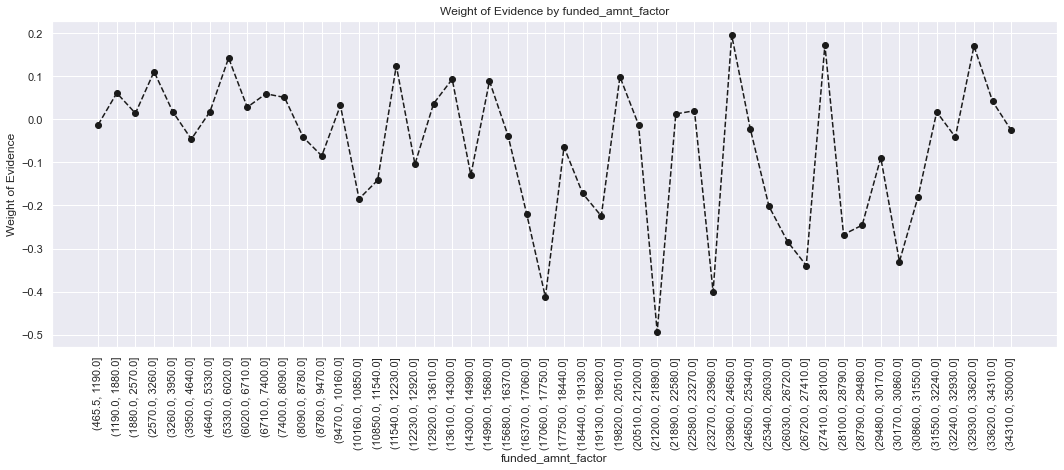

In [180]:
plot_by_woe(df_temp, 90)

Because of the distribution of the weight of evidence and the low Information Value. lets not put this into our pd model

In [181]:
df_input_prep['earliest_cr_line_in_mnths_factor'] = pd.cut(df_input_prep['earliest_cr_line_in_mnths'], 50)
df_temp = woe_cont(df_input_prep, 'earliest_cr_line_in_mnths_factor', df_target_prep)
df_temp

earliest_cr_line_in_mnths_factor  count  proportion_of_good  \
0                   (-0.588, 11.76]      6            0.833333   
1                    (11.76, 23.52]      0                 NaN   
2                    (23.52, 35.28]      0                 NaN   
3                    (35.28, 47.04]      0                 NaN   
4                     (47.04, 58.8]      0                 NaN   
5                     (58.8, 70.56]      0                 NaN   
6                    (70.56, 82.32]    202            0.905941   
7                    (82.32, 94.08]    601            0.888519   
8                   (94.08, 105.84]    877            0.844926   
9                   (105.84, 117.6]   1474            0.869064   
10                  (117.6, 129.36]   2865            0.885166   
11                 (129.36, 141.12]   3917            0.863416   
12                 (141.12, 152.88]   4026            0.876552   
13                 (152.88, 164.64]   4969            0.880056   
14                  (164.64, 176.4]   5939            0.885503   
15                  (176.4, 188.16]   6872            0.887515   
16                 (188.16, 199.92]   7427            0.885418   
17                 (199.92, 211.68]   9004            0.885829   
18                 (211.68, 223.44]   8326            0.882417   
19                  (223.44, 235.2]   7458            0.885090   
20                  (235.2, 246.96]   5696            0.893961   
21                 (246.96, 258.72]   5682            0.895459   
22                 (258.72, 270.48]   5716            0.900280   
23                 (270.48, 282.24]   5041            0.900218   
24                  (282.24, 294.0]   4507            0.895718   
25                  (294.0, 305.76]   3006            0.908184   
26                 (305.76, 317.52]   2659            0.907860   
27                 (317.52, 329.28]   2610            0.908046   
28                 (329.28, 341.04]   2562            0.912568   
29                  (341.04, 352.8]   2059            0.902380   
30                  (352.8, 364.56]   1985            0.914358   
31                 (364.56, 376.32]   1640            0.922561   
32                 (376.32, 388.08]   1450            0.902759   
33                 (388.08, 399.84]   1199            0.909091   
34                  (399.84, 411.6]   1243            0.904264   
35                  (411.6, 423.36]    974            0.903491   
36                 (423.36, 435.12]    668            0.916168   
37                 (435.12, 446.88]    497            0.921529   
38                 (446.88, 458.64]    483            0.906832   
39                  (458.64, 470.4]    459            0.925926   
40                  (470.4, 482.16]    501            0.918164   
41                 (482.16, 493.92]    360            0.902778   
42                 (493.92, 505.68]    288            0.927083   
43                 (505.68, 517.44]    211            0.919431   
44                  (517.44, 529.2]    226            0.920354   
45                  (529.2, 540.96]    175            0.954286   
46                 (540.96, 552.72]    147            0.925170   
47                 (552.72, 564.48]    101            0.900990   
48                 (564.48, 576.24]     93            0.924731   
49                  (576.24, 588.0]    371            0.865229   

    proportion_of_count  n_good   n_bad  prop_n_good  prop_n_bad       WoE  \
0              0.000051     5.0     1.0     0.000048    0.000079 -0.499208   
1              0.000000     NaN     NaN          NaN         NaN       NaN   
2              0.000000     NaN     NaN          NaN         NaN       NaN   
3              0.000000     NaN     NaN          NaN         NaN       NaN   
4              0.000000     NaN     NaN          NaN         NaN       NaN   
5              0.000000     NaN     NaN          NaN         NaN       NaN   
6              0.001733   183.0    19.0     0.001760    0.001506  0.156401   
7           

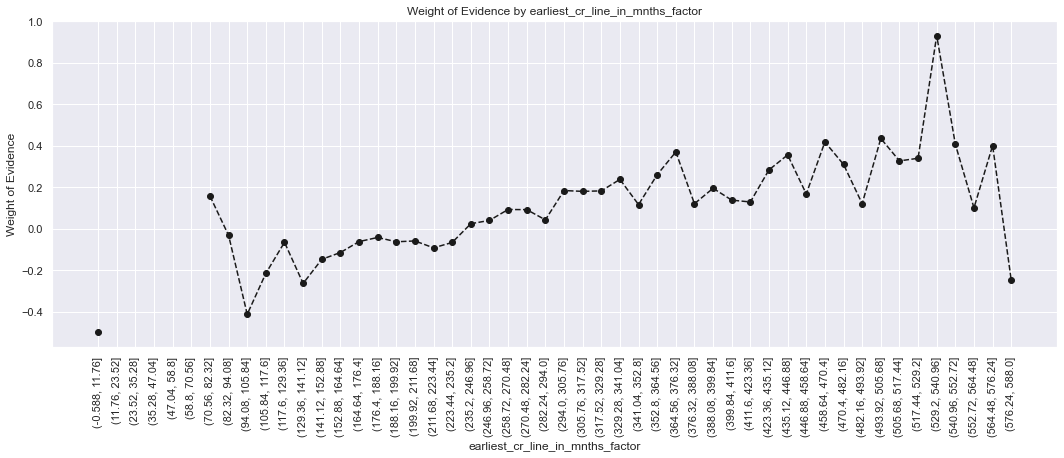

In [182]:
plot_by_woe(df_temp, 90)

In [183]:
df_input_prep['earliest_cr_line_in_mnths_<140'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_141-164'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140, 165)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_165-247'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(165, 248)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_248-270'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(248, 271)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_271-352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(271, 353)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths_>352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(353, int(df_input_prep['earliest_cr_line_in_mnths'].max()))), 1, 0)

In [184]:
df_temp = woe_cont(df_input_prep, 'delinq_2yrs', df_target_prep)
df_temp

delinq_2yrs  count  proportion_of_good  proportion_of_count   n_good  \
0           0.0  95867            0.891715             0.822384  85486.0   
1           1.0  13954            0.891501             0.119703  12440.0   
2           2.0   4091            0.893180             0.035094   3654.0   
3           3.0   1367            0.891002             0.011727   1218.0   
4           4.0    622            0.897106             0.005336    558.0   
5           5.0    302            0.877483             0.002591    265.0   
6           6.0    164            0.884146             0.001407    145.0   
7           7.0     93            0.892473             0.000798     83.0   
8           8.0     41            0.951220             0.000352     39.0   
9           9.0     30            0.900000             0.000257     27.0   
10         10.0     11            0.909091             0.000094     10.0   
11         11.0      9            1.000000             0.000077      9.0   
12         12.0      7            0.714286             0.000060      5.0   
13         13.0      7            1.000000             0.000060      7.0   
14         14.0      2            0.500000             0.000017      1.0   
15         15.0      2            1.000000             0.000017      2.0   
16         16.0      1            1.000000             0.000009      1.0   
17         17.0      1            1.000000             0.000009      1.0   
18         18.0      1            1.000000             0.000009      1.0   

      n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   10381.0     0.822360    0.822583 -0.000271  inf  
1    1514.0     0.119671    0.119968 -0.002484  inf  
2     437.0     0.035151    0.034628  0.014998  inf  
3     149.0     0.011717    0.011807 -0.007627  inf  
4      64.0     0.005368    0.005071  0.056829  inf  
5      37.0     0.002549    0.002932 -0.139834  inf  
6      19.0     0.001395    0.001506 -0.076352  inf  
7      10.0     0.000798    0.000792  0.007609  inf  
8       2.0     0.000375    0.000158  0.861768  inf  
9       3.0     0.000260    0.000238  0.088578  inf  
10      1.0     0.000096    0.000079  0.193939  inf  
11      0.0     0.000087    0.000000       inf  inf  
12      2.0     0.000048    0.000158 -1.192356  inf  
13      0.0     0.000067    0.000000       inf  inf  
14      1.0     0.000010    0.000079 -2.108646  inf  
15      0.0     0.000019    0.000000       inf  inf  
16      0.0     0.000010    0.000000       inf  inf  
17      0.0     0.000010    0.000000       inf  inf  
18      0.0     0.000010    0.000000       inf  inf

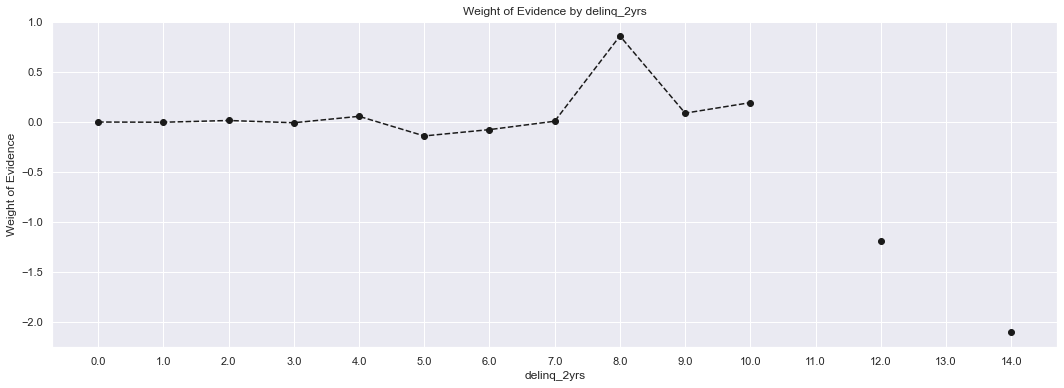

In [185]:
plot_by_woe(df_temp)

In [186]:
df_input_prep['delinq_2yrs_0'] = np.where((df_input_prep['delinq_2yrs'] == 0), 1, 0)
df_input_prep['delinq_2yrs_1-6'] = np.where((df_input_prep['delinq_2yrs'] >= 1) & (df_input_prep['delinq_2yrs'] <= 6), 1, 0)
df_input_prep['delinq_2yrs_>6'] = np.where((df_input_prep['delinq_2yrs'] >6), 1, 0)

In [187]:
df_temp = woe_cont(df_input_prep, 'inq_last_6mths', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


inq_last_6mths  count  proportion_of_good  proportion_of_count   n_good  \
0              0.0  60218            0.909114             0.516573  54745.0   
1              1.0  32747            0.886280             0.280917  29023.0   
2              2.0  14396            0.867116             0.123494  12483.0   
3              3.0   6371            0.840057             0.054653   5352.0   
4              4.0   1771            0.848673             0.015192   1503.0   
5              5.0    651            0.821813             0.005585    535.0   
6              6.0    308            0.782468             0.002642    241.0   
7              7.0     50            0.640000             0.000429     32.0   
8              8.0     27            0.518519             0.000232     14.0   
9              9.0     12            0.666667             0.000103      8.0   
10            10.0      5            1.000000             0.000043      5.0   
11            11.0      4            0.750000             0.000034      3.0   
12            12.0      4            1.000000             0.000034      4.0   
13            13.0      1            1.000000             0.000009      1.0   
14            14.0      1            1.000000             0.000009      1.0   
15            15.0      2            0.500000             0.000017      1.0   
16            17.0      1            0.000000             0.000009      0.0   
17            25.0      1            0.000000             0.000009      0.0   
18            27.0      1            1.000000             0.000009      1.0   
19            33.0      1            0.000000             0.000009      0.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   5473.0     0.526637    0.433677  0.194213  inf  
1   3724.0     0.279196    0.295087 -0.055356  inf  
2   1913.0     0.120084    0.151585 -0.232951  inf  
3   1019.0     0.051485    0.080745 -0.449998  inf  
4    268.0     0.014459    0.021236 -0.384415  inf  
5    116.0     0.005147    0.009192 -0.579970  inf  
6     67.0     0.002318    0.005309 -0.828542  inf  
7     18.0     0.000308    0.001426 -1.533282  inf  
8     13.0     0.000135    0.001030 -2.034538  inf  
9      4.0     0.000077    0.000317 -1.415499  inf  
10     0.0     0.000048    0.000000       inf  inf  
11     1.0     0.000029    0.000079 -1.010034  inf  
12     0.0     0.000038    0.000000       inf  inf  
13     0.0     0.000010    0.000000       inf  inf  
14     0.0     0.000010    0.000000       inf  inf  
15     1.0     0.000010    0.000079 -2.108646  inf  
16     1.0     0.000000    0.000079      -inf  inf  
17     1.0     0.000000    0.000079      -inf  inf  
18     0.0     0.000010    0.000000       inf  inf  
19     1.0     0.000000    0.000079      -inf  inf

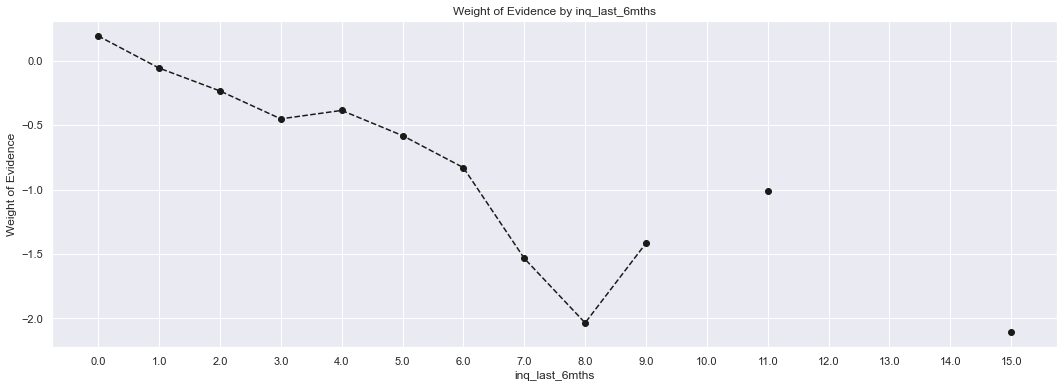

In [188]:
plot_by_woe(df_temp)

In [189]:
df_input_prep['inq_last_6mths_0'] = np.where((df_input_prep['inq_last_6mths'] == 0), 1, 0)
df_input_prep['inq_last_6mths_1-2'] = np.where((df_input_prep['inq_last_6mths'] >= 1) & (df_input_prep['inq_last_6mths'] <= 2), 1, 0)
df_input_prep['inq_last_6mths_3-6'] = np.where((df_input_prep['inq_last_6mths'] >= 3) & (df_input_prep['inq_last_6mths'] <= 6), 1, 0)
df_input_prep['inq_last_6mths_>6'] = np.where((df_input_prep['inq_last_6mths'] > 6), 1, 0)

In [190]:
df_temp = woe_cont(df_input_prep, 'open_acc', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


open_acc  count  proportion_of_good  proportion_of_count  n_good   n_bad  \
0        0.0      8            0.750000             0.000069     6.0     2.0   
1        1.0     44            0.909091             0.000377    40.0     4.0   
2        2.0    421            0.840855             0.003612   354.0    67.0   
3        3.0   1348            0.869436             0.011564  1172.0   176.0   
4        4.0   3039            0.890754             0.026070  2707.0   332.0   
5        5.0   5366            0.891726             0.046032  4785.0   581.0   
6        6.0   7711            0.900921             0.066148  6947.0   764.0   
7        7.0   9408            0.890731             0.080705  8380.0  1028.0   
8        8.0  10427            0.891436             0.089447  9295.0  1132.0   
9        9.0  10995            0.890223             0.094319  9788.0  1207.0   
10      10.0  10737            0.884046             0.092106  9492.0  1245.0   
11      11.0   9719            0.886408             0.083373  8615.0  1104.0   
12      12.0   8589            0.891256             0.073680  7655.0   934.0   
13      13.0   7538            0.895994             0.064664  6754.0   784.0   
14      14.0   6194            0.890055             0.053135  5513.0   681.0   
15      15.0   5025            0.892338             0.043106  4484.0   541.0   
16      16.0   4243            0.896064             0.036398  3802.0   441.0   
17      17.0   3457            0.890657             0.029655  3079.0   378.0   
18      18.0   2665            0.896435             0.022861  2389.0   276.0   
19      19.0   2163            0.904762             0.018555  1957.0   206.0   
20      20.0   1658            0.901689             0.014223  1495.0   163.0   
21      21.0   1358            0.888807             0.011649  1207.0   151.0   
22      22.0   1035            0.894686             0.008879   926.0   109.0   
23      23.0    753            0.896414             0.006460   675.0    78.0   
24      24.0    608            0.912829             0.005216   555.0    53.0   
25      25.0    496            0.897177             0.004255   445.0    51.0   
26      26.0    336            0.928571             0.002882   312.0    24.0   
27      27.0    268            0.921642             0.002299   247.0    21.0   
28      28.0    189            0.915344             0.001621   173.0    16.0   
29      29.0    164            0.896341             0.001407   147.0    17.0   
30      30.0    125            0.880000             0.001072   110.0    15.0   
31      31.0    102            0.960784             0.000875    98.0     4.0   
32      32.0     83            0.927711             0.000712    77.0     6.0   
33      33.0     49            0.897959             0.000420    44.0     5.0   
34      34.0     44            0.909091             0.000377    40.0     4.0   
35      35.0     39            0.871795             0.000335    34.0     5.0   
36      36.0     39            0.974359             0.000335    38.0     1.0   
37      37.0     26            0.884615             0.000223    23.0     3.0   
38      38.0     25            0.880000             0.000214    22.0     3.0   
39      39.0     13            0.846154             0.000112    11.0     2.0   
40      40.0     11            0.909091             0.000094    10.0     1.0   
41      41.0     11            0.909091             0.000094    10.0     1.0   
42      42.0      9            0.888889             0.000077     8.0     1.0   
43      43.0      4            0.750000             0.000034     3.0     1.0   
44      44.0      3            1.000000             0.000026     3.0     0.0   
45      45.0      8            0.875000             0.000069     7.0     1.0   
46      46.0      2            1.000000             0.000017     2.0     0.0   
47      47.0      2            1.000000             0.000017     2.0     0.0   
48      48.0      3            1.000000             0.000026     3.0     0.0   
49  

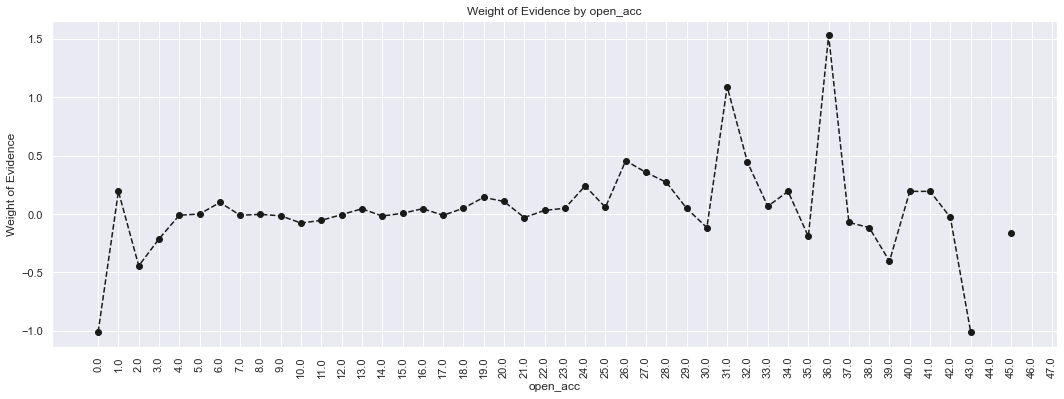

In [191]:
plot_by_woe(df_temp, 90)

In [192]:
df_input_prep['open_acc_0'] = np.where((df_input_prep['open_acc'] == 0), 1, 0)
df_input_prep['open_acc_1-3'] = np.where((df_input_prep['open_acc'] >= 1) & (df_input_prep['open_acc'] <= 3), 1, 0)
df_input_prep['open_acc_4-12'] = np.where((df_input_prep['open_acc'] >= 4) & (df_input_prep['open_acc'] <= 12), 1, 0)
df_input_prep['open_acc_13-17'] = np.where((df_input_prep['open_acc'] >= 13) & (df_input_prep['open_acc'] <= 17), 1, 0)
df_input_prep['open_acc_18-22'] = np.where((df_input_prep['open_acc'] >= 18) & (df_input_prep['open_acc'] <= 22), 1, 0)
df_input_prep['open_acc_23-25'] = np.where((df_input_prep['open_acc'] >= 23) & (df_input_prep['open_acc'] <= 25), 1, 0)
df_input_prep['open_acc_26-30'] = np.where((df_input_prep['open_acc'] >= 26) & (df_input_prep['open_acc'] <= 30), 1, 0)
df_input_prep['open_acc_>=31'] = np.where((df_input_prep['open_acc'] >= 31), 1, 0)

In [193]:
df_temp = woe_cont(df_input_prep, 'pub_rec', df_target_prep)
df_temp

pub_rec   count  proportion_of_good  proportion_of_count   n_good  \
0       0.0  101283            0.891324             0.868845  90276.0   
1       1.0   13226            0.892636             0.113458  11806.0   
2       2.0    1405            0.898932             0.012053   1263.0   
3       3.0     398            0.922111             0.003414    367.0   
4       4.0     129            0.930233             0.001107    120.0   
5       5.0      69            0.942029             0.000592     65.0   
6       6.0      26            0.846154             0.000223     22.0   
7       7.0      19            0.842105             0.000163     16.0   
8       8.0       7            1.000000             0.000060      7.0   
9       9.0       4            1.000000             0.000034      4.0   
10     13.0       2            1.000000             0.000017      2.0   
11     14.0       1            1.000000             0.000009      1.0   
12     15.0       1            1.000000             0.000009      1.0   
13     49.0       1            1.000000             0.000009      1.0   
14     54.0       1            1.000000             0.000009      1.0   

      n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   11007.0     0.868439    0.872187 -0.004306  inf  
1    1420.0     0.113572    0.112520  0.009305  inf  
2     142.0     0.012150    0.011252  0.076772  inf  
3      31.0     0.003530    0.002456  0.362728  inf  
4       9.0     0.001154    0.000713  0.481621  inf  
5       4.0     0.000625    0.000317  0.679447  inf  
6       4.0     0.000212    0.000317 -0.403898  inf  
7       3.0     0.000154    0.000238 -0.434670  inf  
8       0.0     0.000067    0.000000       inf  inf  
9       0.0     0.000038    0.000000       inf  inf  
10      0.0     0.000019    0.000000       inf  inf  
11      0.0     0.000010    0.000000       inf  inf  
12      0.0     0.000010    0.000000       inf  inf  
13      0.0     0.000010    0.000000       inf  inf  
14      0.0     0.000010    0.000000       inf  inf

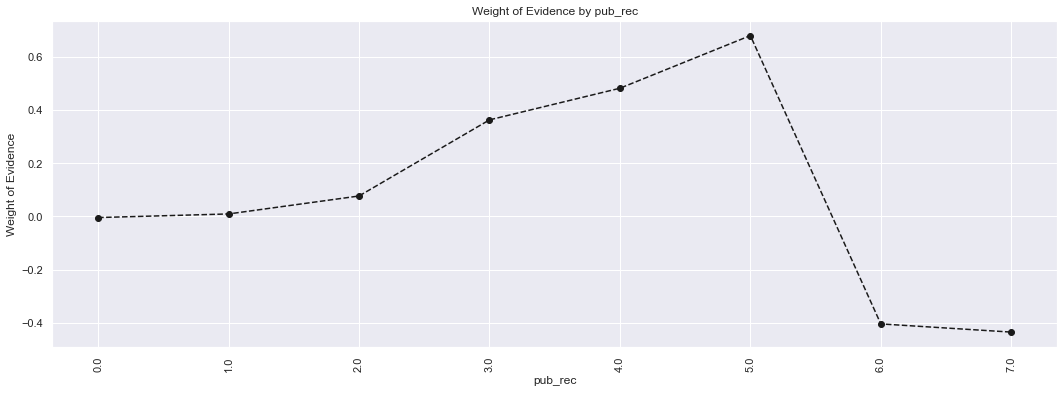

In [194]:
plot_by_woe(df_temp, 90)

In [195]:
df_input_prep['pub_rec_0-2'] = np.where((df_input_prep['pub_rec'] >= 0) & (df_input_prep['pub_rec'] <= 2), 1, 0)
df_input_prep['pub_rec_3-4'] = np.where((df_input_prep['pub_rec'] >= 3) & (df_input_prep['pub_rec'] <= 4), 1, 0)
df_input_prep['pub_rec_>=5'] = np.where((df_input_prep['pub_rec'] >= 5), 1, 0)

In [196]:
df_input_prep['total_acc_factor'] = pd.cut(df_input_prep['total_acc'], 50)
df_temp = woe_cont(df_input_prep, 'total_acc_factor', df_target_prep)
df_temp

total_acc_factor  count  proportion_of_good  proportion_of_count   n_good  \
0     (-0.156, 3.12]    149            0.812081             0.001278    121.0   
1       (3.12, 6.24]   1796            0.879176             0.015407   1579.0   
2       (6.24, 9.36]   4674            0.879119             0.040095   4109.0   
3      (9.36, 12.48]   7756            0.875580             0.066534   6791.0   
4      (12.48, 15.6]  10389            0.884397             0.089121   9188.0   
5      (15.6, 18.72]  12366            0.886705             0.106080  10965.0   
6     (18.72, 21.84]  12831            0.888239             0.110069  11397.0   
7     (21.84, 24.96]  12436            0.889836             0.106681  11066.0   
8     (24.96, 28.08]  14861            0.897719             0.127483  13341.0   
9      (28.08, 31.2]   9339            0.896027             0.080114   8368.0   
10     (31.2, 34.32]   7650            0.903922             0.065625   6915.0   
11    (34.32, 37.44]   5942            0.900707             0.050973   5352.0   
12    (37.44, 40.56]   4567            0.896650             0.039178   4095.0   
13    (40.56, 43.68]   3457            0.901649             0.029655   3117.0   
14     (43.68, 46.8]   2470            0.903644             0.021189   2232.0   
15     (46.8, 49.92]   1708            0.899883             0.014652   1537.0   
16    (49.92, 53.04]   1700            0.911176             0.014583   1549.0   
17    (53.04, 56.16]    791            0.911504             0.006786    721.0   
18    (56.16, 59.28]    545            0.886239             0.004675    483.0   
19     (59.28, 62.4]    457            0.890591             0.003920    407.0   
20     (62.4, 65.52]    435            0.882759             0.003732    384.0   
21    (65.52, 68.64]     72            0.902778             0.000618     65.0   
22    (68.64, 71.76]     57            0.929825             0.000489     53.0   
23    (71.76, 74.88]     31            0.967742             0.000266     30.0   
24     (74.88, 78.0]     32            0.937500             0.000275     30.0   
25     (78.0, 81.12]     17            0.941176             0.000146     16.0   
26    (81.12, 84.24]      9            0.888889             0.000077      8.0   
27    (84.24, 87.36]     14            0.928571             0.000120     13.0   
28    (87.36, 90.48]      9            1.000000             0.000077      9.0   
29     (90.48, 93.6]      4            1.000000             0.000034      4.0   
30     (93.6, 96.72]      1            1.000000             0.000009      1.0   
31    (96.72, 99.84]      2            0.500000             0.000017      1.0   
32   (99.84, 102.96]      1            1.000000             0.000009      1.0   
33  (102.96, 106.08]      0                 NaN             0.000000      NaN   
34   (106.08, 109.2]      0                 NaN             0.000000      NaN   
35   (109.2, 112.32]      0                 NaN             0.000000      NaN   
36  (112.32, 115.44]      0                 NaN             0.000000      NaN   
37  (115.44, 118.56]      0                 NaN             0.000000      NaN   
38  (118.56, 121.68]      1            1.000000             0.000009      1.0   
39   (121.68, 124.8]      1            1.000000             0.000009      1.0   
40   (124.8, 127.92]      0                 NaN             0.000000      NaN   
41  (127.92, 131.04]      0                 NaN             0.000000      NaN   
42  (131.04, 134.16]      0                 NaN             0.000000      NaN   
43  (134.16, 137.28]      0                 NaN             0.000000      NaN   
44   (137.28, 140.4]      0                 NaN             0.000000      NaN   
45   (140.4, 143.52]      0                 NaN             0.000000      NaN   
46  (143.52, 146.64]      0                 NaN             0.000000      NaN   
47  (146.64, 149.76]      0                 NaN             0.000000      NaN   
48  (149.76, 152.88]      1        

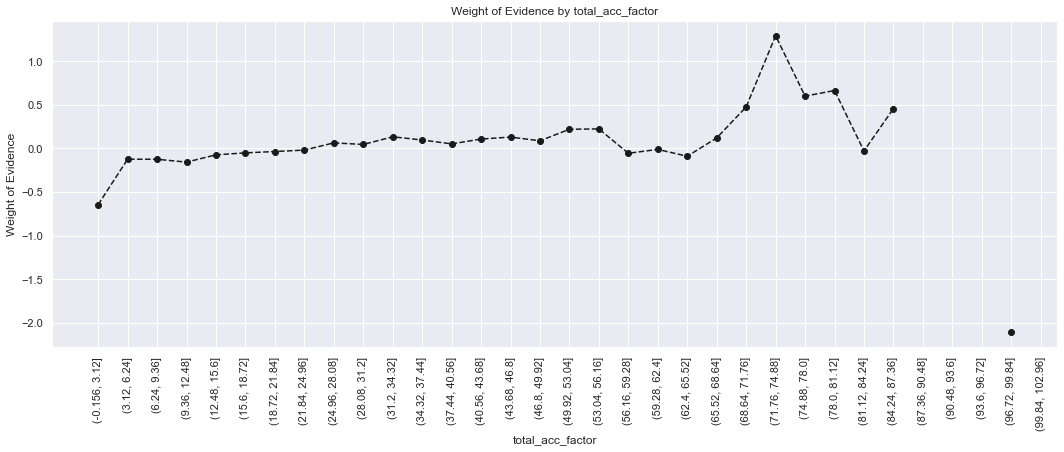

In [197]:
plot_by_woe(df_temp, 90)

In [198]:
df_input_prep['total_acc_<=27'] = np.where((df_input_prep['total_acc'] <= 27), 1, 0)
df_input_prep['total_acc_28-51'] = np.where((df_input_prep['total_acc'] >= 28) & (df_input_prep['total_acc'] <= 51), 1, 0)
df_input_prep['total_acc_>=52'] = np.where((df_input_prep['total_acc'] >= 52), 1, 0)

In [199]:
df_temp = woe_cont(df_input_prep, 'acc_now_delinq', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


acc_now_delinq   count  proportion_of_good  proportion_of_count    n_good  \
0             0.0  116108            0.891739             0.996020  103538.0   
1             1.0     435            0.889655             0.003732     387.0   
2             2.0      23            0.956522             0.000197      22.0   
3             3.0       3            1.000000             0.000026       3.0   
4             4.0       2            1.000000             0.000017       2.0   
5             5.0       1            0.000000             0.000009       0.0   

     n_bad  prop_n_good  prop_n_bad       WoE   IV  
0  12570.0     0.996017    0.996038 -0.000021  inf  
1     48.0     0.003723    0.003803 -0.021423  inf  
2      1.0     0.000212    0.000079  0.982396  inf  
3      0.0     0.000029    0.000000       inf  inf  
4      0.0     0.000019    0.000000       inf  inf  
5      1.0     0.000000    0.000079      -inf  inf

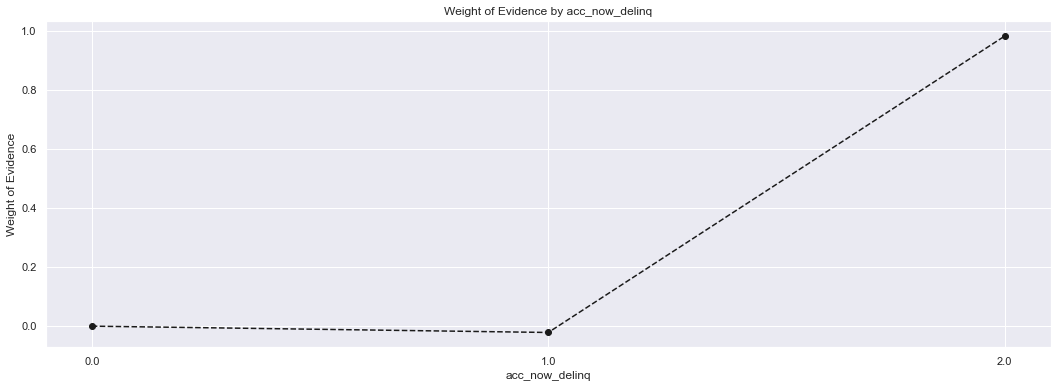

In [200]:
plot_by_woe(df_temp)

In [201]:
df_input_prep['acc_now_delinq_0'] = np.where((df_input_prep['acc_now_delinq'] == 0), 1, 0)
df_input_prep['acc_now_delinq_>=1'] = np.where((df_input_prep['acc_now_delinq'] >= 1), 1, 0)

In [202]:
df_input_prep['total_rev_hi_lim_factor'] = pd.cut(df_input_prep['total_rev_hi_lim'], 2000)
df_temp = woe_cont(df_input_prep, 'total_rev_hi_lim_factor', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


total_rev_hi_lim_factor  count  proportion_of_good  \
0            (-9999.999, 5000.0]   6051            0.867295   
1             (5000.0, 9999.999]  16439            0.877669   
2          (9999.999, 14999.998]  18494            0.880015   
3         (14999.998, 19999.998]  16131            0.878619   
4         (19999.998, 24999.997]  12995            0.886649   
...                          ...    ...                 ...   
1995  (9974999.002, 9979999.002]      0                 NaN   
1996  (9979999.002, 9984999.002]      0                 NaN   
1997  (9984999.002, 9989999.001]      0                 NaN   
1998    (9989999.001, 9994999.0]      0                 NaN   
1999      (9994999.0, 9999999.0]      2            1.000000   

      proportion_of_count   n_good   n_bad  prop_n_good  prop_n_bad       WoE  \
0                0.051908   5248.0   803.0     0.050485    0.063629 -0.231399   
1                0.141020  14428.0  2011.0     0.138795    0.159350 -0.138108   
2                0.158649  16275.0  2219.0     0.156563    0.175832 -0.116073   
3                0.138378  14173.0  1958.0     0.136342    0.155151 -0.129231   
4                0.111476  11522.0  1473.0     0.110840    0.116719 -0.051689   
...                   ...      ...     ...          ...         ...       ...   
1995             0.000000      NaN     NaN          NaN         NaN       NaN   
1996             0.000000      NaN     NaN          NaN         NaN       NaN   
1997             0.000000      NaN     NaN          NaN         NaN       NaN   
1998             0.000000      NaN     NaN          NaN         NaN       NaN   
1999             0.000017      2.0     0.0     0.000019    0.000000       inf   

       IV  
0     inf  
1     inf  
2     inf  
3     inf  
4     inf  
...   ...  
1995  inf  
1996  inf  
1997  inf  
1998  inf  
1999  inf  

[2000 rows x 10 columns]

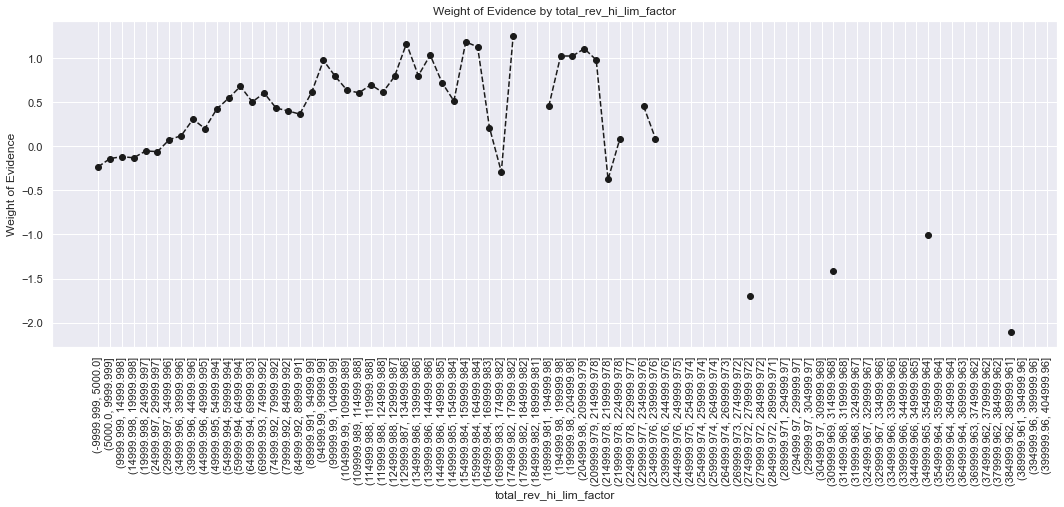

In [203]:
plot_by_woe(df_temp, 90)

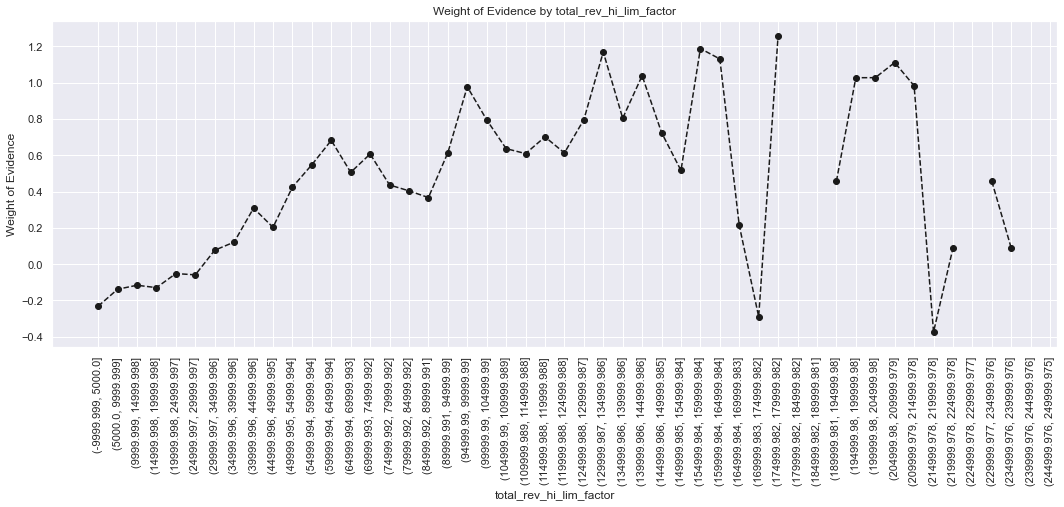

In [204]:
plot_by_woe(df_temp.iloc[:50,:], 90)

In [205]:
df_input_prep['total_rev_hi_lim_<=5K'] = np.where((df_input_prep['total_rev_hi_lim'] <= 5000), 1, 0)
df_input_prep['total_rev_hi_lim_5K-10K'] = np.where((df_input_prep['total_rev_hi_lim'] > 5000) & (df_input_prep['total_rev_hi_lim'] <= 10000), 1, 0)
df_input_prep['total_rev_hi_lim_10K-20K'] = np.where((df_input_prep['total_rev_hi_lim'] > 10000) & (df_input_prep['total_rev_hi_lim'] <= 20000), 1, 0)
df_input_prep['total_rev_hi_lim_20K-30K'] = np.where((df_input_prep['total_rev_hi_lim'] > 20000) & (df_input_prep['total_rev_hi_lim'] <= 30000), 1, 0)
df_input_prep['total_rev_hi_lim_30K-40K'] = np.where((df_input_prep['total_rev_hi_lim'] > 30000) & (df_input_prep['total_rev_hi_lim'] <= 40000), 1, 0)
df_input_prep['total_rev_hi_lim_40K-55K'] = np.where((df_input_prep['total_rev_hi_lim'] > 40000) & (df_input_prep['total_rev_hi_lim'] <= 55000), 1, 0)
df_input_prep['total_rev_hi_lim_55K-95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 55000) & (df_input_prep['total_rev_hi_lim'] <= 95000), 1, 0)
df_input_prep['total_rev_hi_lim_>95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 95000), 1, 0)

In [206]:
df_input_prep['installment_factor'] = pd.cut(df_input_prep['installment'], 50)
df_temp = woe_cont(df_input_prep, 'installment_factor', df_target_prep)
df_temp

installment_factor  count  proportion_of_good  proportion_of_count  \
0       (14.276, 43.556]    588            0.894558             0.005044   
1       (43.556, 71.443]   1516            0.890501             0.013005   
2       (71.443, 99.329]   2104            0.900190             0.018049   
3      (99.329, 127.216]   2740            0.897080             0.023505   
4     (127.216, 155.102]   3119            0.893235             0.026756   
5     (155.102, 182.988]   5261            0.897928             0.045131   
6     (182.988, 210.875]   5333            0.902494             0.045749   
7     (210.875, 238.761]   4766            0.900755             0.040885   
8     (238.761, 266.648]   5777            0.900814             0.049557   
9     (266.648, 294.534]   6310            0.892076             0.054130   
10     (294.534, 322.42]   6439            0.900916             0.055236   
11     (322.42, 350.307]   8003            0.890291             0.068653   
12    (350.307, 378.193]   5905            0.883827             0.050655   
13     (378.193, 406.08]   5582            0.895557             0.047885   
14     (406.08, 433.966]   4280            0.879206             0.036716   
15    (433.966, 461.852]   3869            0.887309             0.033190   
16    (461.852, 489.739]   4925            0.893198             0.042249   
17    (489.739, 517.625]   4917            0.897498             0.042180   
18    (517.625, 545.512]   3272            0.863386             0.028068   
19    (545.512, 573.398]   3319            0.878578             0.028472   
20    (573.398, 601.284]   3009            0.873380             0.025812   
21    (601.284, 629.171]   2906            0.909498             0.024929   
22    (629.171, 657.057]   2606            0.897160             0.022355   
23    (657.057, 684.944]   2939            0.900306             0.025212   
24     (684.944, 712.83]   1948            0.881417             0.016711   
25     (712.83, 740.716]   1570            0.882803             0.013468   
26    (740.716, 768.603]   1694            0.893152             0.014532   
27    (768.603, 796.489]   1547            0.909502             0.013271   
28    (796.489, 824.376]   1287            0.885004             0.011040   
29    (824.376, 852.262]   1171            0.886422             0.010045   
30    (852.262, 880.148]   1301            0.898540             0.011160   
31    (880.148, 908.035]    956            0.855649             0.008201   
32    (908.035, 935.921]    688            0.863372             0.005902   
33    (935.921, 963.808]    738            0.883469             0.006331   
34    (963.808, 991.694]    563            0.818828             0.004830   
35    (991.694, 1019.58]    472            0.853814             0.004049   
36   (1019.58, 1047.467]    404            0.873762             0.003466   
37  (1047.467, 1075.353]    276            0.884058             0.002368   
38   (1075.353, 1103.24]    311            0.945338             0.002668   
39   (1103.24, 1131.126]    249            0.931727             0.002136   
40  (1131.126, 1159.012]    287            0.930314             0.002462   
41  (1159.012, 1186.899]    381            0.910761             0.003268   
42  (1186.899, 1214.785]    406            0.876847             0.003483   
43  (1214.785, 1242.672]    327            0.899083             0.002805   
44  (1242.672, 1270.558]    226            0.893805             0.001939   
45  (1270.558, 1298.444]    146            0.856164             0.001252   
46  (1298.444, 1326.331]     68            0.794118             0.000583   
47  (1326.331, 1354.217]     43            0.837209             0.000369   
48  (1354.217, 1382.104]     14            0.857143             0.000120   
49   (1382.104, 1409.99]     14            1.000000             0.000120   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE   IV  
0    526.0   62.0     0.005060    0.004913  0.029520  inf  
1   1350.

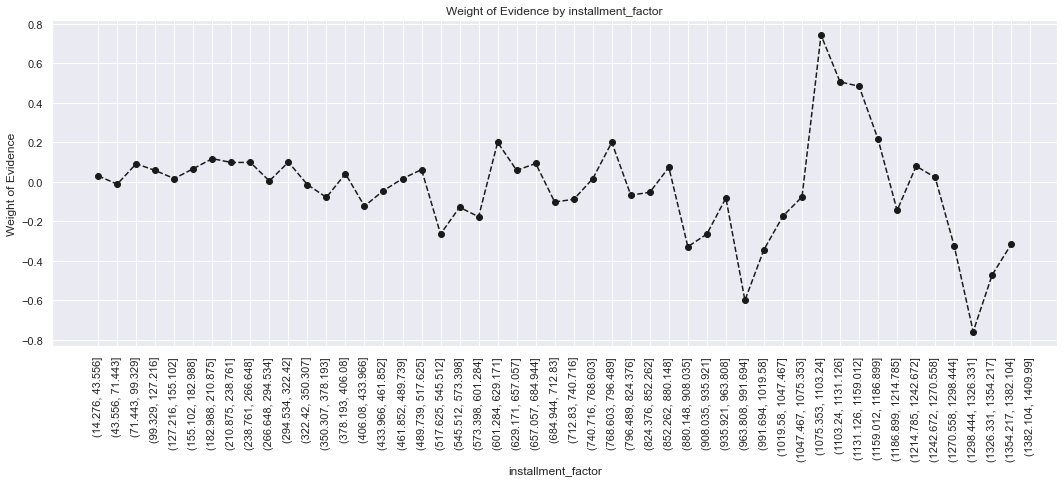

In [207]:
plot_by_woe(df_temp, 90)

In [208]:
df_input_prep['annual_inc_factor'] = pd.cut(df_input_prep['annual_inc'], 100)
df_temp = woe_cont(df_input_prep, 'annual_inc_factor', df_target_prep)
df_temp

annual_inc_factor  count  proportion_of_good  proportion_of_count  \
0       (-2796.7, 64267.0]  59841            0.872729             0.513339   
1      (64267.0, 125234.0]  46836            0.907400             0.401777   
2     (125234.0, 186201.0]   7223            0.929669             0.061962   
3     (186201.0, 247168.0]   1518            0.942029             0.013022   
4     (247168.0, 308135.0]    659            0.937785             0.005653   
..                     ...    ...                 ...                  ...   
95  (5795165.0, 5856132.0]      0                 NaN             0.000000   
96  (5856132.0, 5917099.0]      0                 NaN             0.000000   
97  (5917099.0, 5978066.0]      0                 NaN             0.000000   
98  (5978066.0, 6039033.0]      0                 NaN             0.000000   
99  (6039033.0, 6100000.0]      1            1.000000             0.000009   

     n_good   n_bad  prop_n_good  prop_n_bad       WoE   IV  
0   52225.0  7616.0     0.502395    0.603487 -0.183336  inf  
1   42499.0  4337.0     0.408833    0.343661  0.173651  inf  
2    6715.0   508.0     0.064597    0.040254  0.472971  inf  
3    1430.0    88.0     0.013756    0.006973  0.679447  inf  
4     618.0    41.0     0.005945    0.003249  0.604270  inf  
..      ...     ...          ...         ...       ...  ...  
95      NaN     NaN          NaN         NaN       NaN  inf  
96      NaN     NaN          NaN         NaN       NaN  inf  
97      NaN     NaN          NaN         NaN       NaN  inf  
98      NaN     NaN          NaN         NaN       NaN  inf  
99      1.0     0.0     0.000010    0.000000       inf  inf  

[100 rows x 10 columns]

In [209]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['annual_inc'] <= 150000, : ]

In [210]:
df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)
df_temp = woe_cont(df_input_prep_temp, 'annual_inc_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-210-83cf6fca08f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)


annual_inc_factor  count  proportion_of_good  proportion_of_count  \
0       (3153.3, 6234.0]      7            1.000000             0.000063   
1       (6234.0, 9168.0]     40            0.875000             0.000359   
2      (9168.0, 12102.0]    187            0.812834             0.001678   
3     (12102.0, 15036.0]    353            0.815864             0.003168   
4     (15036.0, 17970.0]    321            0.853583             0.002881   
5     (17970.0, 20904.0]    930            0.865591             0.008347   
6     (20904.0, 23838.0]    958            0.828810             0.008599   
7     (23838.0, 26772.0]   2212            0.863020             0.019854   
8     (26772.0, 29706.0]   1787            0.855624             0.016040   
9     (29706.0, 32640.0]   3814            0.861563             0.034233   
10    (32640.0, 35574.0]   3882            0.870685             0.034844   
11    (35574.0, 38508.0]   3646            0.858475             0.032725   
12    (38508.0, 41442.0]   5255            0.863559             0.047167   
13    (41442.0, 44376.0]   3990            0.866416             0.035813   
14    (44376.0, 47310.0]   5227            0.874498             0.046916   
15    (47310.0, 50244.0]   7015            0.877120             0.062964   
16    (50244.0, 53178.0]   3692            0.889491             0.033138   
17    (53178.0, 56112.0]   5375            0.879256             0.048244   
18    (56112.0, 59046.0]   2842            0.883181             0.025509   
19    (59046.0, 61980.0]   5569            0.883462             0.049986   
20    (61980.0, 64914.0]   2882            0.904233             0.025868   
21    (64914.0, 67848.0]   5006            0.893328             0.044932   
22    (67848.0, 70782.0]   4928            0.893872             0.044232   
23    (70782.0, 73716.0]   2586            0.911060             0.023211   
24    (73716.0, 76650.0]   4124            0.895732             0.037016   
25    (76650.0, 79584.0]   1721            0.904126             0.015447   
26    (79584.0, 82518.0]   4207            0.900404             0.037761   
27    (82518.0, 85452.0]   3254            0.910572             0.029207   
28    (85452.0, 88386.0]   1531            0.911822             0.013742   
29    (88386.0, 91320.0]   3085            0.913128             0.027690   
30    (91320.0, 94254.0]   1470            0.912925             0.013194   
31    (94254.0, 97188.0]   2120            0.913679             0.019028   
32   (97188.0, 100122.0]   3065            0.919086             0.027511   
33  (100122.0, 103056.0]    946            0.914376             0.008491   
34  (103056.0, 105990.0]   1206            0.932007             0.010825   
35  (105990.0, 108924.0]    835            0.914970             0.007495   
36  (108924.0, 111858.0]   1708            0.916862             0.015330   
37  (111858.0, 114792.0]    564            0.923759             0.005062   
38  (114792.0, 117726.0]    989            0.929221             0.008877   
39  (117726.0, 120660.0]   1994            0.910732             0.017898   
40  (120660.0, 123594.0]    336            0.955357             0.003016   
41  (123594.0, 126528.0]   1151            0.920070             0.010331   
42  (126528.0, 129462.0]    300            0.930000             0.002693   
43  (129462.0, 132396.0]   1024            0.933594             0.009191   
44  (132396.0, 135330.0]    604            0.948675             0.005421   
45  (135330.0, 138264.0]    257            0.937743             0.002307   
46  (138264.0, 141198.0]    729            0.917695             0.006543   
47  (141198.0, 144132.0]    238            0.945378             0.002136   
48  (144132.0, 147066.0]    387            0.925065             0.003474   
49  (147066.0, 150000.0]   1063            0.912512             0.009541   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE   IV  
0      7.0    0.0     0.000071    0.000000       inf  inf  
1     35.0

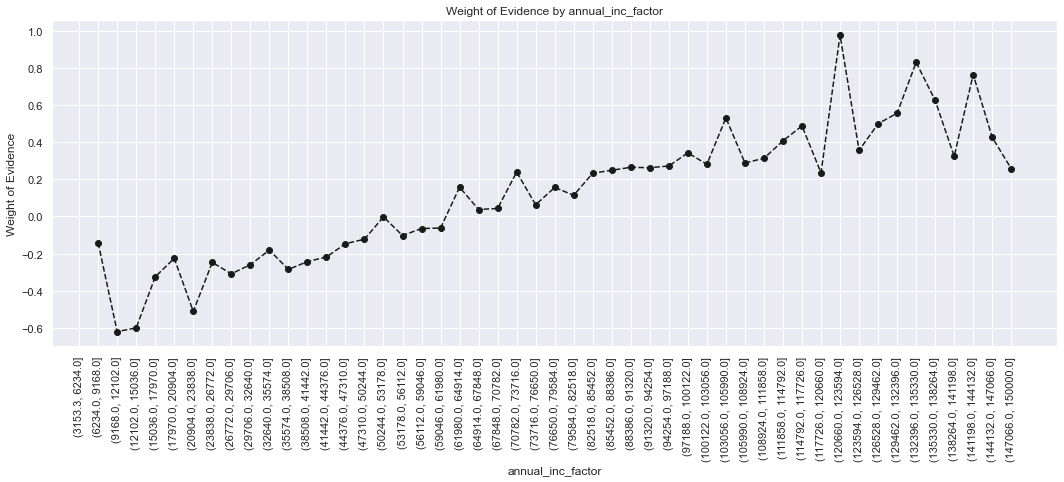

In [211]:
plot_by_woe(df_temp,90)

In [212]:
df_input_prep['annual_inc_<20K'] = np.where((df_input_prep['annual_inc'] <= 20000), 1, 0)
df_input_prep['annual_inc_20K-30K'] = np.where((df_input_prep['annual_inc'] > 20000) & (df_input_prep['annual_inc'] <= 30000), 1, 0)
df_input_prep['annual_inc_30K-40K'] = np.where((df_input_prep['annual_inc'] > 30000) & (df_input_prep['annual_inc'] <= 40000), 1, 0)
df_input_prep['annual_inc_40K-50K'] = np.where((df_input_prep['annual_inc'] > 40000) & (df_input_prep['annual_inc'] <= 50000), 1, 0)
df_input_prep['annual_inc_50K-60K'] = np.where((df_input_prep['annual_inc'] > 50000) & (df_input_prep['annual_inc'] <= 60000), 1, 0)
df_input_prep['annual_inc_60K-70K'] = np.where((df_input_prep['annual_inc'] > 60000) & (df_input_prep['annual_inc'] <= 70000), 1, 0)
df_input_prep['annual_inc_70K-80K'] = np.where((df_input_prep['annual_inc'] > 70000) & (df_input_prep['annual_inc'] <= 80000), 1, 0)
df_input_prep['annual_inc_80K-90K'] = np.where((df_input_prep['annual_inc'] > 80000) & (df_input_prep['annual_inc'] <= 90000), 1, 0)
df_input_prep['annual_inc_90K-100K'] = np.where((df_input_prep['annual_inc'] > 90000) & (df_input_prep['annual_inc'] <= 100000), 1, 0)
df_input_prep['annual_inc_100K-125K'] = np.where((df_input_prep['annual_inc'] > 100000) & (df_input_prep['annual_inc'] <= 125000), 1, 0)
df_input_prep['annual_inc_125K-150K'] = np.where((df_input_prep['annual_inc'] > 125000) & (df_input_prep['annual_inc'] <= 150000), 1, 0)
df_input_prep['annual_inc_>150K'] = np.where((df_input_prep['annual_inc'] > 150000), 1, 0)

In [213]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_delinq'])]
df_input_prep_temp['mths_since_last_delinq_factor'] = pd.cut(df_input_prep_temp['mths_since_last_delinq'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_delinq_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-213-66ad2c51f00c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['mths_since_last_delinq_factor'] = pd.cut(df_input_prep_temp['mths_since_last_delinq'], 50)


mths_since_last_delinq_factor  count  proportion_of_good  \
0                   (-0.17, 3.4]   1661            0.878387   
1                     (3.4, 6.8]   2502            0.892086   
2                    (6.8, 10.2]   4173            0.890486   
3                   (10.2, 13.6]   2987            0.885839   
4                   (13.6, 17.0]   3969            0.891660   
5                   (17.0, 20.4]   2853            0.898002   
6                   (20.4, 23.8]   2587            0.889447   
7                   (23.8, 27.2]   3384            0.906324   
8                   (27.2, 30.6]   2439            0.893399   
9                   (30.6, 34.0]   3145            0.898251   
10                  (34.0, 37.4]   2252            0.901421   
11                  (37.4, 40.8]   2141            0.884633   
12                  (40.8, 44.2]   2814            0.894812   
13                  (44.2, 47.6]   2082            0.892891   
14                  (47.6, 51.0]   2187            0.892547   
15                  (51.0, 54.4]   1434            0.894700   
16                  (54.4, 57.8]   1481            0.897367   
17                  (57.8, 61.2]   1763            0.901305   
18                  (61.2, 64.6]   1250            0.895200   
19                  (64.6, 68.0]   1650            0.886061   
20                  (68.0, 71.4]   1214            0.889621   
21                  (71.4, 74.8]   1185            0.885232   
22                  (74.8, 78.2]   1441            0.899375   
23                  (78.2, 81.6]    968            0.885331   
24                  (81.6, 85.0]    188            0.867021   
25                  (85.0, 88.4]      7            0.857143   
26                  (88.4, 91.8]      6            0.833333   
27                  (91.8, 95.2]      3            1.000000   
28                  (95.2, 98.6]      4            0.750000   
29                 (98.6, 102.0]      3            0.666667   
30                (102.0, 105.4]      4            1.000000   
31                (105.4, 108.8]      2            1.000000   
32                (108.8, 112.2]      2            0.500000   
33                (112.2, 115.6]      2            0.500000   
34                (115.6, 119.0]      2            1.000000   
35                (119.0, 122.4]      1            1.000000   
36                (122.4, 125.8]      0                 NaN   
37                (125.8, 129.2]      0                 NaN   
38                (129.2, 132.6]      0                 NaN   
39                (132.6, 136.0]      4            1.000000   
40                (136.0, 139.4]      0                 NaN   
41                (139.4, 142.8]      1            1.000000   
42                (142.8, 146.2]      0                 NaN   
43                (146.2, 149.6]      0                 NaN   
44                (149.6, 153.0]      0                 NaN   
45                (153.0, 156.4]      0                 NaN   
46                (156.4, 159.8]      0                 NaN   
47                (159.8, 163.2]      0                 NaN   
48                (163.2, 166.6]      0                 NaN   
49                (166.6, 170.0]      1            1.000000   

    proportion_of_count  n_good  n_bad  prop_n_good  prop_n_bad       WoE   IV  
0              0.030878  1459.0  202.0     0.030369    0.035130 -0.145637  inf  
1              0.046512  2232.0  270.0     0.046459    0.046957 -0.010644  inf  
2              0.077577  3716.0  457.0     0.077349    0.079478 -0.027156  inf  
3              0.055529  2646.0  341.0     0.055077    0.059304 -0.073954  inf  
4              0.073784  3539.0  430.0     0.073665    0.074783 -0.015062  inf  
5              0.053038  2562.0  291.0     0.053328    0.050609  0.052344  inf  
6              0.048093  2301.0  286.0     0.047896    0.049739 -0.037768  inf  
7              0.062909  3067.0  317.0     0.063840    0.055130  0.146678  inf  
8              0.045341  2179.0  260.0     0.045356    0.045

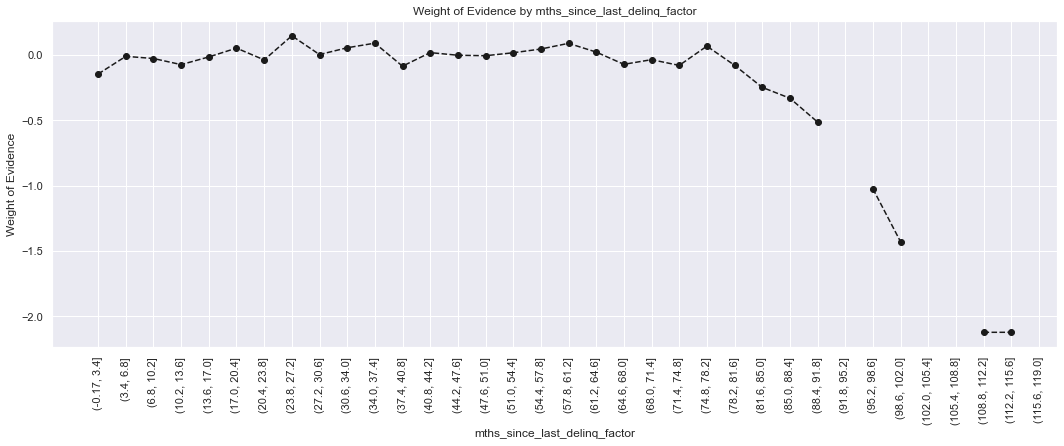

In [214]:
plot_by_woe(df_temp, 90)

In [215]:
df_input_prep['mths_since_last_delinq_Missing'] = np.where((df_input_prep['mths_since_last_delinq'].isnull()), 1, 0)
df_input_prep['mths_since_last_delinq_0-3'] = np.where((df_input_prep['mths_since_last_delinq'] >= 0) & (df_input_prep['mths_since_last_delinq'] <= 3), 1, 0)
df_input_prep['mths_since_last_delinq_4-30'] = np.where((df_input_prep['mths_since_last_delinq'] >= 4) & (df_input_prep['mths_since_last_delinq'] <= 30), 1, 0)
df_input_prep['mths_since_last_delinq_31-56'] = np.where((df_input_prep['mths_since_last_delinq'] >= 31) & (df_input_prep['mths_since_last_delinq'] <= 56), 1, 0)
df_input_prep['mths_since_last_delinq_>=57'] = np.where((df_input_prep['mths_since_last_delinq'] >= 57), 1, 0)

In [216]:
df_input_prep['dti_factor'] = pd.cut(df_input_prep['dti'], 100)
df_temp = woe_cont(df_input_prep, 'dti_factor', df_target_prep)
df_temp

dti_factor  count  proportion_of_good  proportion_of_count  n_good  \
0      (-0.04, 0.4]    239            0.887029             0.002050   212.0   
1        (0.4, 0.8]    232            0.909483             0.001990   211.0   
2        (0.8, 1.2]    257            0.879377             0.002205   226.0   
3        (1.2, 1.6]    348            0.905172             0.002985   315.0   
4        (1.6, 2.0]    368            0.894022             0.003157   329.0   
..              ...    ...                 ...                  ...     ...   
95  (37.991, 38.39]     71            0.887324             0.000609    63.0   
96   (38.39, 38.79]     54            0.833333             0.000463    45.0   
97   (38.79, 39.19]     58            0.948276             0.000498    55.0   
98   (39.19, 39.59]     51            0.901961             0.000437    46.0   
99   (39.59, 39.99]     55            0.818182             0.000472    45.0   

    n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    27.0     0.002039    0.002139 -0.047897  0.036077  
1    21.0     0.002030    0.001664  0.198689  0.036077  
2    31.0     0.002174    0.002456 -0.122099  0.036077  
3    33.0     0.003030    0.002615  0.147419  0.036077  
4    39.0     0.003165    0.003090  0.023850  0.036077  
..    ...          ...         ...       ...       ...  
95    8.0     0.000606    0.000634 -0.044953  0.036077  
96    9.0     0.000433    0.000713 -0.499208  0.036077  
97    3.0     0.000529    0.000238  0.800074  0.036077  
98    5.0     0.000443    0.000396  0.110557  0.036077  
99   10.0     0.000433    0.000792 -0.604569  0.036077  

[100 rows x 10 columns]

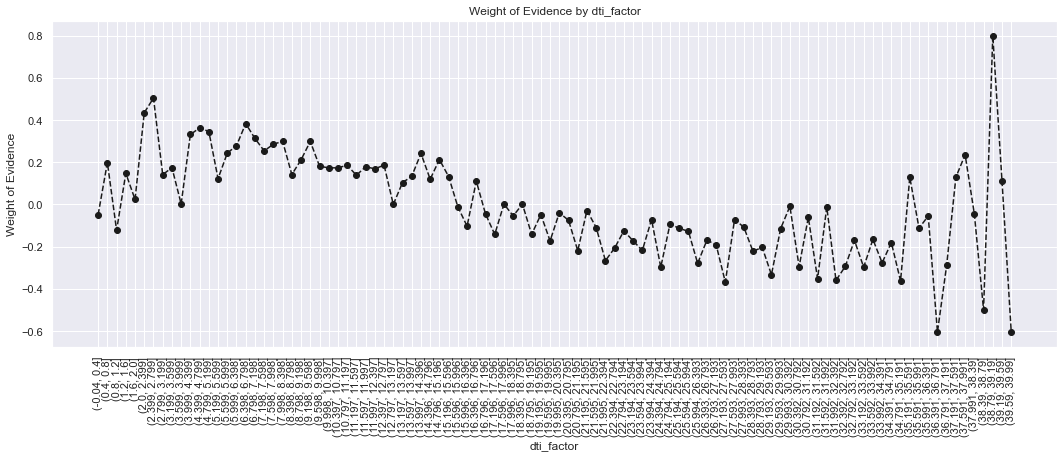

In [217]:
plot_by_woe(df_temp, 90)

In [218]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['dti'] <= 35, : ]

In [219]:
df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)
df_temp = woe_cont(df_input_prep_temp, 'dti_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-219-d89e3acf0a04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)


dti_factor  count  proportion_of_good  proportion_of_count  n_good  \
0   (-0.035, 0.7]    414            0.891304             0.003579   369.0   
1      (0.7, 1.4]    495            0.880808             0.004279   436.0   
2      (1.4, 2.1]    642            0.917445             0.005550   589.0   
3      (2.1, 2.8]    783            0.927203             0.006769   726.0   
4      (2.8, 3.5]    984            0.908537             0.008507   894.0   
5      (3.5, 4.2]   1170            0.909402             0.010115  1064.0   
6      (4.2, 4.9]   1376            0.909884             0.011895  1252.0   
7      (4.9, 5.6]   1707            0.914470             0.014757  1561.0   
8      (5.6, 6.3]   1857            0.911686             0.016054  1693.0   
9      (6.3, 7.0]   2076            0.925819             0.017947  1922.0   
10     (7.0, 7.7]   2203            0.913300             0.019045  2012.0   
11     (7.7, 8.4]   2568            0.916667             0.022200  2354.0   
12     (8.4, 9.1]   2741            0.904050             0.023696  2478.0   
13     (9.1, 9.8]   2845            0.918102             0.024595  2612.0   
14    (9.8, 10.5]   3109            0.908009             0.026877  2823.0   
15   (10.5, 11.2]   3225            0.905736             0.027880  2921.0   
16   (11.2, 11.9]   3320            0.906024             0.028701  3008.0   
17   (11.9, 12.6]   3625            0.911724             0.031338  3305.0   
18   (12.6, 13.3]   3626            0.893547             0.031347  3240.0   
19   (13.3, 14.0]   3862            0.903418             0.033387  3489.0   
20   (14.0, 14.7]   3770            0.907162             0.032592  3420.0   
21   (14.7, 15.4]   3774            0.909380             0.032626  3432.0   
22   (15.4, 16.1]   3806            0.897267             0.032903  3415.0   
23   (16.1, 16.8]   3695            0.888227             0.031943  3282.0   
24   (16.8, 17.5]   3850            0.879221             0.033283  3385.0   
25   (17.5, 18.2]   3690            0.895393             0.031900  3304.0   
26   (18.2, 18.9]   3549            0.886165             0.030681  3145.0   
27   (18.9, 19.6]   3481            0.881643             0.030093  3069.0   
28   (19.6, 20.3]   3633            0.881641             0.031407  3203.0   
29   (20.3, 21.0]   3507            0.879954             0.030318  3086.0   
30   (21.0, 21.7]   3199            0.883088             0.027655  2825.0   
31   (21.7, 22.4]   3063            0.867450             0.026480  2657.0   
32   (22.4, 23.1]   2906            0.874742             0.025122  2542.0   
33   (23.1, 23.8]   2956            0.874154             0.025555  2584.0   
34   (23.8, 24.5]   2789            0.875583             0.024111  2442.0   
35   (24.5, 25.2]   2539            0.872785             0.021950  2216.0   
36   (25.2, 25.9]   2095            0.874463             0.018111  1832.0   
37   (25.9, 26.6]   2119            0.870694             0.018319  1845.0   
38   (26.6, 27.3]   1965            0.869720             0.016987  1709.0   
39   (27.3, 28.0]   1850            0.872432             0.015993  1614.0   
40   (28.0, 28.7]   1764            0.876417             0.015250  1546.0   
41   (28.7, 29.4]   1624            0.866379             0.014039  1407.0   
42   (29.4, 30.1]   1415            0.869258             0.012233  1230.0   
43   (30.1, 30.8]   1080            0.875926             0.009337   946.0   
44   (30.8, 31.5]   1040            0.874038             0.008991   909.0   
45   (31.5, 32.2]    936            0.875000             0.008092   819.0   
46   (32.2, 32.9]    834            0.852518             0.007210   711.0   
47   (32.9, 33.6]    767            0.869622             0.006631   667.0   
48   (33.6, 34.3]    713            0.873773             0.006164   623.0   
49   (34.3, 35.0]    637            0.860283             0.005507   548.0   

    n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    45.0     0.003577

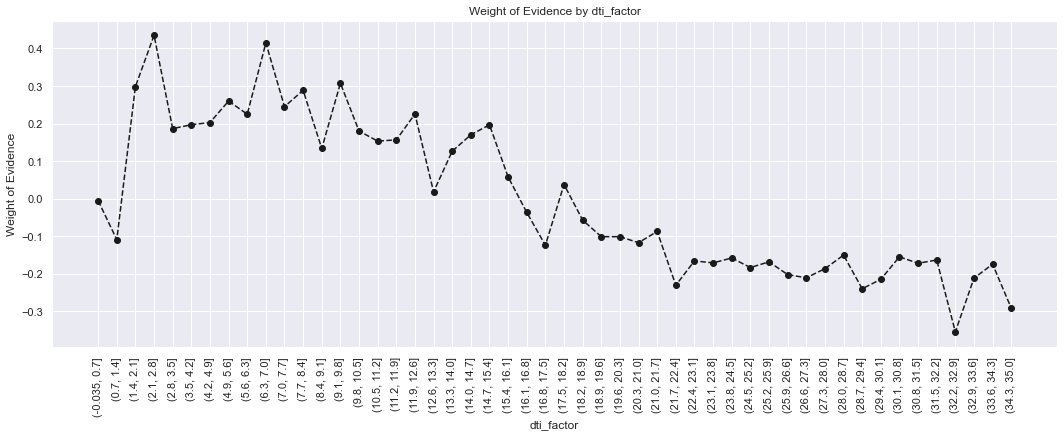

In [220]:
plot_by_woe(df_temp, 90)

In [221]:
df_input_prep['dti_<=1.4'] = np.where((df_input_prep['dti'] <= 1.4), 1, 0)
df_input_prep['dti_1.4-3.5'] = np.where((df_input_prep['dti'] > 1.4) & (df_input_prep['dti'] <= 3.5), 1, 0)
df_input_prep['dti_3.5-7.7'] = np.where((df_input_prep['dti'] > 3.5) & (df_input_prep['dti'] <= 7.7), 1, 0)
df_input_prep['dti_7.7-10.5'] = np.where((df_input_prep['dti'] > 7.7) & (df_input_prep['dti'] <= 10.5), 1, 0)
df_input_prep['dti_10.5-16.1'] = np.where((df_input_prep['dti'] > 10.5) & (df_input_prep['dti'] <= 16.1), 1, 0)
df_input_prep['dti_16.1-20.3'] = np.where((df_input_prep['dti'] > 16.1) & (df_input_prep['dti'] <= 20.3), 1, 0)
df_input_prep['dti_20.3-21.7'] = np.where((df_input_prep['dti'] > 20.3) & (df_input_prep['dti'] <= 21.7), 1, 0)
df_input_prep['dti_21.7-22.4'] = np.where((df_input_prep['dti'] > 21.7) & (df_input_prep['dti'] <= 22.4), 1, 0)
df_input_prep['dti_22.4-35'] = np.where((df_input_prep['dti'] > 22.4) & (df_input_prep['dti'] <= 35), 1, 0)
df_input_prep['dti_>35'] = np.where((df_input_prep['dti'] > 35), 1, 0)

In [222]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_record'])]
df_input_prep_temp['mths_since_last_record_factor'] = pd.cut(df_input_prep_temp['mths_since_last_record'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_record_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-222-1f7c4e8fb8ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['mths_since_last_record_factor'] = pd.cut(df_input_prep_temp['mths_since_last_record'], 50)
C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


mths_since_last_record_factor  count  proportion_of_good  \
0                 (-0.129, 2.58]    330            0.745455   
1                   (2.58, 5.16]     36            0.916667   
2                   (5.16, 7.74]     35            0.828571   
3                  (7.74, 10.32]     73            0.958904   
4                  (10.32, 12.9]     60            0.916667   
5                  (12.9, 15.48]    110            0.918182   
6                 (15.48, 18.06]    103            0.893204   
7                 (18.06, 20.64]     80            0.937500   
8                 (20.64, 23.22]    140            0.907143   
9                  (23.22, 25.8]     96            0.854167   
10                 (25.8, 28.38]    203            0.906404   
11                (28.38, 30.96]    129            0.922481   
12                (30.96, 33.54]    212            0.919811   
13                (33.54, 36.12]    226            0.907080   
14                 (36.12, 38.7]    206            0.922330   
15                 (38.7, 41.28]    321            0.931464   
16                (41.28, 43.86]    224            0.910714   
17                (43.86, 46.44]    393            0.933842   
18                (46.44, 49.02]    425            0.910588   
19                 (49.02, 51.6]    296            0.915541   
20                 (51.6, 54.18]    529            0.899811   
21                (54.18, 56.76]    357            0.941176   
22                (56.76, 59.34]    499            0.909820   
23                (59.34, 61.92]    369            0.924119   
24                 (61.92, 64.5]    535            0.919626   
25                 (64.5, 67.08]    525            0.937143   
26                (67.08, 69.66]    302            0.903974   
27                (69.66, 72.24]    441            0.907029   
28                (72.24, 74.82]    278            0.902878   
29                 (74.82, 77.4]    440            0.884091   
30                 (77.4, 79.98]    286            0.902098   
31                (79.98, 82.56]    440            0.890909   
32                (82.56, 85.14]    346            0.890173   
33                (85.14, 87.72]    321            0.844237   
34                 (87.72, 90.3]    389            0.853470   
35                 (90.3, 92.88]    307            0.859935   
36                (92.88, 95.46]    498            0.859438   
37                (95.46, 98.04]    547            0.859232   
38               (98.04, 100.62]    368            0.853261   
39               (100.62, 103.2]    659            0.874052   
40               (103.2, 105.78]    484            0.904959   
41              (105.78, 108.36]    728            0.875000   
42              (108.36, 110.94]    466            0.916309   
43              (110.94, 113.52]    666            0.879880   
44               (113.52, 116.1]    581            0.846816   
45               (116.1, 118.68]    400            0.897500   
46              (118.68, 121.26]    138            0.847826   
47              (121.26, 123.84]      0                 NaN   
48              (123.84, 126.42]      0                 NaN   
49               (126.42, 129.0]      1            0.000000   

    proportion_of_count  n_good  n_bad  prop_n_good  prop_n_bad       WoE   IV  
0              0.021157   246.0   84.0     0.017693    0.049587 -1.030569  inf  
1              0.002308    33.0    3.0     0.002373    0.001771  0.292811  inf  
2              0.002244    29.0    6.0     0.002086    0.003542 -0.529548  inf  
3              0.004680    70.0    3.0     0.005035    0.001771  1.044799  inf  
4              0.003847    55.0    5.0     0.003956    0.002952  0.292811  inf  
5              0.007052   101.0    9.0     0.007264    0.005313  0.312812  inf  
6              0.006603    92.0   11.0     0.006617    0.006494  0.018809  inf  
7              0.005129    75.0    5.0     0.005394    0.002952  0.602966  inf  
8              0.008976   127.0   13.0     0.009134    0.007

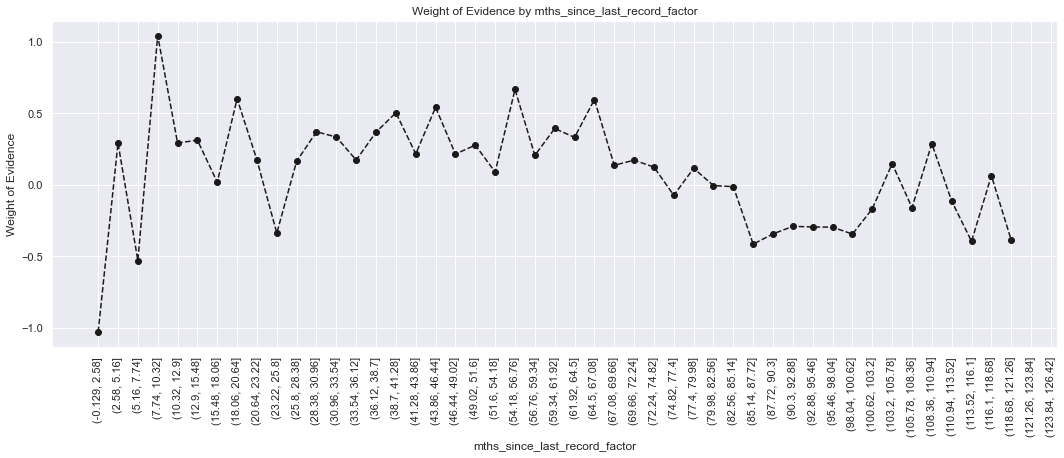

In [223]:
plot_by_woe(df_temp, 90)

In [224]:
df_input_prep['mths_since_last_record_Missing'] = np.where((df_input_prep['mths_since_last_record'].isnull()), 1, 0)
df_input_prep['mths_since_last_record_0-2'] = np.where((df_input_prep['mths_since_last_record'] >= 0) & (df_input_prep['mths_since_last_record'] <= 2), 1, 0)
df_input_prep['mths_since_last_record_3-20'] = np.where((df_input_prep['mths_since_last_record'] >= 3) & (df_input_prep['mths_since_last_record'] <= 20), 1, 0)
df_input_prep['mths_since_last_record_21-31'] = np.where((df_input_prep['mths_since_last_record'] >= 21) & (df_input_prep['mths_since_last_record'] <= 31), 1, 0)
df_input_prep['mths_since_last_record_32-80'] = np.where((df_input_prep['mths_since_last_record'] >= 32) & (df_input_prep['mths_since_last_record'] <= 80), 1, 0)
df_input_prep['mths_since_last_record_81-86'] = np.where((df_input_prep['mths_since_last_record'] >= 81) & (df_input_prep['mths_since_last_record'] <= 86), 1, 0)
df_input_prep['mths_since_last_record_>86'] = np.where((df_input_prep['mths_since_last_record'] > 86), 1, 0)

## Results

In [225]:
df_input_test = df_input_prep.copy()

In [226]:
df_input_train.shape

(349713, 323)

In [227]:
df_input_test.shape

(116572, 323)

In [228]:
#df_input_train.to_csv('df_input_train.csv')
#df_input_test.to_csv('df_input_test.csv')
#df_target_train.to_csv('df_target_train.csv')
#df_target_test.to_csv('df_target_test.csv')

# Feature Selection :

In [229]:
df_input_test = df_input_test.set_index(['index'])
df_input_train = df_input_train.set_index(['index'])

In [230]:
df_target_train.shape

(349713,)

In [231]:
df_target_test.shape

(116572,)

In [232]:
input_train_with_ref_cat = df_input_train.loc[:, ['grade_A',
'grade_B',
'grade_C',
'grade_D',
'grade_E',
'grade_F',
'grade_G',
'home_ownership_RENT_OTHER_NONE_ANY',
'home_ownership_OWN',
'home_ownership_MORTGAGE',
'addr_state_ND_NE_IA_NV_FL_HI_AL',
'addr_state_NM_VA',
'addr_state_NY',
'addr_state_OK_TN_MO_LA_MD_NC',
'addr_state_CA',
'addr_state_UT_KY_AZ_NJ',
'addr_state_AR_MI_PA_OH_MN',
'addr_state_RI_MA_DE_SD_IN',
'addr_state_GA_WA_OR',
'addr_state_WI_MT',
'addr_state_TX',
'addr_state_IL_CT',
'addr_state_KS_SC_CO_VT_AK_MS',
'addr_state_WV_NH_WY_DC_ME_ID',
'verification_status_Not Verified',
'verification_status_Source Verified',
'verification_status_Verified',
'purpose_sm_b_educ',
'purpose_ren_en_mov_house_other',                                                          
'purpose_credit_card',
'purpose_debt_consolidation',
'purpose_major_purch__car__home_impr',
'initial_list_status_f',
'initial_list_status_w',
'term_36',
'term_60',
'emp_length_int_0',
'emp_length_int_1-3',
'emp_length_int_4',
'emp_length_int_5-6',
'emp_length_int_7-9',
'emp_length_int_10',
'issue_d_in_mnths_<39',
'issue_d_in_mnths_39-40',
'issue_d_in_mnths_41-42',
'issue_d_in_mnths_43-48',
'issue_d_in_mnths_49-54',
'issue_d_in_mnths_55-66',
'issue_d_in_mnths_67-84',
'issue_d_in_mnths_>84',
'int_rate_<9.548',
'int_rate_9.548-12.025',
'int_rate_12.025-15.74',
'int_rate_15.74-20.281',
'int_rate_>20.281',
'earliest_cr_line_in_mnths_<140',
'earliest_cr_line_in_mnths_141-164',
'earliest_cr_line_in_mnths_165-247',
'earliest_cr_line_in_mnths_248-270',
'earliest_cr_line_in_mnths_271-352',
'earliest_cr_line_in_mnths_>352',
'delinq_2yrs_0',
'delinq_2yrs_1-6',
'delinq_2yrs_>6',
'inq_last_6mths_0',
'inq_last_6mths_1-2',
'inq_last_6mths_3-6',
'inq_last_6mths_>6',
'open_acc_0',
'open_acc_1-3',
'open_acc_4-12',
'open_acc_13-17',
'open_acc_18-22',
'open_acc_23-25',
'open_acc_26-30',
'open_acc_>=31',
'pub_rec_0-2',
'pub_rec_3-4',
'pub_rec_>=5',
'total_acc_<=27',
'total_acc_28-51',
'total_acc_>=52',
'acc_now_delinq_0',
'acc_now_delinq_>=1',
'total_rev_hi_lim_<=5K',
'total_rev_hi_lim_5K-10K',
'total_rev_hi_lim_10K-20K',
'total_rev_hi_lim_20K-30K',
'total_rev_hi_lim_30K-40K',
'total_rev_hi_lim_40K-55K',
'total_rev_hi_lim_55K-95K',
'total_rev_hi_lim_>95K',
'annual_inc_<20K',
'annual_inc_20K-30K',
'annual_inc_30K-40K',
'annual_inc_40K-50K',
'annual_inc_50K-60K',
'annual_inc_60K-70K',
'annual_inc_70K-80K',
'annual_inc_80K-90K',
'annual_inc_90K-100K',
'annual_inc_100K-125K',
'annual_inc_125K-150K',
'annual_inc_>150K',
'dti_<=1.4',
'dti_1.4-3.5',
'dti_3.5-7.7',
'dti_7.7-10.5',
'dti_10.5-16.1',
'dti_16.1-20.3',
'dti_20.3-21.7',
'dti_21.7-22.4',
'dti_22.4-35',
'dti_>35',
'mths_since_last_delinq_Missing',
'mths_since_last_delinq_0-3',
'mths_since_last_delinq_4-30',
'mths_since_last_delinq_31-56',
'mths_since_last_delinq_>=57',
'mths_since_last_record_Missing',
'mths_since_last_record_0-2',
'mths_since_last_record_3-20',
'mths_since_last_record_21-31',
'mths_since_last_record_32-80',
'mths_since_last_record_81-86',
'mths_since_last_record_>86']]

In [233]:
ref_categories = ['grade_G',
'home_ownership_RENT_OTHER_NONE_ANY',
'addr_state_ND_NE_IA_NV_FL_HI_AL',
'verification_status_Verified',
'purpose_sm_b_educ',
'initial_list_status_f',
'term_60',
'emp_length_int_0',
'issue_d_in_mnths_>84',
'int_rate_>20.281',
'earliest_cr_line_in_mnths_<140',
'delinq_2yrs_>6',
'inq_last_6mths_>6',
'open_acc_0',
'pub_rec_0-2',
'total_acc_<=27',
'acc_now_delinq_0',
'total_rev_hi_lim_<=5K',
'annual_inc_<20K',
'dti_>35',
'mths_since_last_delinq_0-3',
'mths_since_last_record_0-2']

In [234]:
input_train = input_train_with_ref_cat.drop(ref_categories, axis = 1)
input_train.head()

grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  \
index                                                          
145391        0        0        0        1        0        0   
392160        0        0        1        0        0        0   
2469          0        0        1        0        0        0   
308958        0        1        0        0        0        0   
132941        0        1        0        0        0        0   

        home_ownership_OWN  home_ownership_MORTGAGE  addr_state_NM_VA  \
index                                                                   
145391                   0                        1                 0   
392160                   1                        0                 0   
2469                     0                        1                 0   
308958                   1                        0                 0   
132941                   0                        0                 0   

        addr_state_NY  ...  mths_since_last_delinq_Missing  \
index                  ...                                   
145391              0  ...                               1   
392160              0  ...                               1   
2469                0  ...                               1   
308958              0  ...                               1   
132941              1  ...                               1   

        mths_since_last_delinq_4-30  mths_since_last_delinq_31-56  \
index                                                               
145391                            0                             0   
392160                            0                             0   
2469                              0                             0   
308958                            0                             0   
132941                            0                             0   

        mths_since_last_delinq_>=57  mths_since_last_record_Missing  \
index                                                                 
145391                            0                               1   
392160                            0                               0   
2469                              0                               1   
308958                            0                               1   
132941                            0                               1   

        mths_since_last_record_3-20  mths_since_last_record_21-31  \
index                                                               
145391                            0                             0   
392160                            0                             0   
2469                              0                             0   
308958                            0                             0   
132941                            0                             0   

        mths_since_last_record_32-80  mths_since_last_record_81-86  \
index                                                                
145391                             0                             0   
392160                             1                             0   
2469                               0                             0   
308958                             0                             0   
132941                             0                             0   

        mths_since_last_record_>86  
index                               
145391                           0  
392160                           0  
2469                             0  
308958                           0  
132941                           0  

[5 rows x 104 columns]

# PD Model

Now lets predict the model using Logistic Regression and validate using ROC_AUC

## Logistic Regression

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [236]:
reg = LogisticRegression()

In [237]:
df_target_train.shape

(349713,)

In [238]:
pd.options.display.max_rows = None

In [239]:
reg.fit(input_train, df_target_train)

C:\Users\azzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [240]:
feature_name = input_train.columns.values

Below are the coefficient for each of the dummy variable

In [241]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

Feature name  Coefficients
0                              Intercept     -1.496908
1                                grade_A      1.132087
2                                grade_B      0.929729
3                                grade_C      0.721146
4                                grade_D      0.552343
5                                grade_E      0.388013
6                                grade_F      0.236037
7                     home_ownership_OWN      0.069218
8                home_ownership_MORTGAGE      0.109321
9                       addr_state_NM_VA      0.078008
10                         addr_state_NY      0.073460
11          addr_state_OK_TN_MO_LA_MD_NC      0.088318
12                         addr_state_CA      0.092251
13                addr_state_UT_KY_AZ_NJ      0.097041
14             addr_state_AR_MI_PA_OH_MN      0.169202
15             addr_state_RI_MA_DE_SD_IN      0.132395
16                   addr_state_GA_WA_OR      0.228218
17                      addr_state_WI_MT      0.276627
18                         addr_state_TX      0.231566
19                      addr_state_IL_CT      0.290830
20          addr_state_KS_SC_CO_VT_AK_MS      0.377373
21          addr_state_WV_NH_WY_DC_ME_ID      0.508645
22      verification_status_Not Verified      0.086271
23   verification_status_Source Verified     -0.021558
24        purpose_ren_en_mov_house_other      0.183333
25                   purpose_credit_card      0.294606
26            purpose_debt_consolidation      0.191222
27   purpose_major_purch__car__home_impr      0.259629
28                 initial_list_status_w      0.050430
29                               term_36      0.083282
30                    emp_length_int_1-3      0.124697
31                      emp_length_int_4      0.144318
32                    emp_length_int_5-6      0.101926
33                    emp_length_int_7-9      0.079082
34                     emp_length_int_10      0.137125
35                  issue_d_in_mnths_<39      1.079374
36                issue_d_in_mnths_39-40      0.860850
37                issue_d_in_mnths_41-42      0.762704
38                issue_d_in_mnths_43-48      0.559968
39                issue_d_in_mnths_49-54      0.381141
40                issue_d_in_mnths_55-66      0.126795
41                issue_d_in_mnths_67-84     -0.098176
42                       int_rate_<9.548      0.943952
43                 int_rate_9.548-12.025      0.592835
44                 int_rate_12.025-15.74      0.347511
45                 int_rate_15.74-20.281      0.132340
46     earliest_cr_line_in_mnths_141-164      0.084624
47     earliest_cr_line_in_mnths_165-247      0.040220
48     earliest_cr_line_in_mnths_248-270      0.045557
49     earliest_cr_line_in_mnths_271-352      0.114479
50        earliest_cr_line_in_mnths_>352      0.129971
51                         delinq_2yrs_0      0.198001
52                       delinq_2yrs_1-6      0.169417
53                      inq_last_6mths_0      0.623146
54                    inq_last_6mths_1-2      0.468782
55                    inq_last_6mths_3-6      0.279453
56                          open_acc_1-3     -0.046759
57                         open_acc_4-12     -0.128381
58                        open_acc_13-17     -0.153503
59                        open_acc_18-22     -0.172659
60                        open_acc_23-25     -0.171878
61                        open_acc_26-30     -0.239796
62                         open_acc_>=31     -0.308537
63                           pub_rec_3-4     -0.039757
64                           pub_rec_>=5      0.097463
65                       total_acc_28-51     -0.028649
66                        total_acc_>=52     -0.012811
67                    acc_now_delinq_>=1      0.189428
68               total_rev_hi_lim_5K-10K      0.037856
69              total_rev_hi_lim_10K-20K      0.021454
70              total_rev_hi_lim_20K-30K      0.038437
71              total_rev_hi_lim_30K-40K      0.035421
72           

## Feature Selection

we could see that there is over a 100 variable. Lets use p value to find which independent variables contribute to predicting the dependent variable and which is not. Because this is a Regression Model, we should use p value that treat the variable as multivariate

In [242]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [243]:
reg = LogisticRegression_with_p_values()

In [244]:
reg.fit(input_train, df_target_train)

C:\Users\azzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [245]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

Feature name  Coefficients
0                              Intercept     -1.496908
1                                grade_A      1.132087
2                                grade_B      0.929729
3                                grade_C      0.721146
4                                grade_D      0.552343
5                                grade_E      0.388013
6                                grade_F      0.236037
7                     home_ownership_OWN      0.069218
8                home_ownership_MORTGAGE      0.109321
9                       addr_state_NM_VA      0.078008
10                         addr_state_NY      0.073460
11          addr_state_OK_TN_MO_LA_MD_NC      0.088318
12                         addr_state_CA      0.092251
13                addr_state_UT_KY_AZ_NJ      0.097041
14             addr_state_AR_MI_PA_OH_MN      0.169202
15             addr_state_RI_MA_DE_SD_IN      0.132395
16                   addr_state_GA_WA_OR      0.228218
17                      addr_state_WI_MT      0.276627
18                         addr_state_TX      0.231566
19                      addr_state_IL_CT      0.290830
20          addr_state_KS_SC_CO_VT_AK_MS      0.377373
21          addr_state_WV_NH_WY_DC_ME_ID      0.508645
22      verification_status_Not Verified      0.086271
23   verification_status_Source Verified     -0.021558
24        purpose_ren_en_mov_house_other      0.183333
25                   purpose_credit_card      0.294606
26            purpose_debt_consolidation      0.191222
27   purpose_major_purch__car__home_impr      0.259629
28                 initial_list_status_w      0.050430
29                               term_36      0.083282
30                    emp_length_int_1-3      0.124697
31                      emp_length_int_4      0.144318
32                    emp_length_int_5-6      0.101926
33                    emp_length_int_7-9      0.079082
34                     emp_length_int_10      0.137125
35                  issue_d_in_mnths_<39      1.079374
36                issue_d_in_mnths_39-40      0.860850
37                issue_d_in_mnths_41-42      0.762704
38                issue_d_in_mnths_43-48      0.559968
39                issue_d_in_mnths_49-54      0.381141
40                issue_d_in_mnths_55-66      0.126795
41                issue_d_in_mnths_67-84     -0.098176
42                       int_rate_<9.548      0.943952
43                 int_rate_9.548-12.025      0.592835
44                 int_rate_12.025-15.74      0.347511
45                 int_rate_15.74-20.281      0.132340
46     earliest_cr_line_in_mnths_141-164      0.084624
47     earliest_cr_line_in_mnths_165-247      0.040220
48     earliest_cr_line_in_mnths_248-270      0.045557
49     earliest_cr_line_in_mnths_271-352      0.114479
50        earliest_cr_line_in_mnths_>352      0.129971
51                         delinq_2yrs_0      0.198001
52                       delinq_2yrs_1-6      0.169417
53                      inq_last_6mths_0      0.623146
54                    inq_last_6mths_1-2      0.468782
55                    inq_last_6mths_3-6      0.279453
56                          open_acc_1-3     -0.046759
57                         open_acc_4-12     -0.128381
58                        open_acc_13-17     -0.153503
59                        open_acc_18-22     -0.172659
60                        open_acc_23-25     -0.171878
61                        open_acc_26-30     -0.239796
62                         open_acc_>=31     -0.308537
63                           pub_rec_3-4     -0.039757
64                           pub_rec_>=5      0.097463
65                       total_acc_28-51     -0.028649
66                        total_acc_>=52     -0.012811
67                    acc_now_delinq_>=1      0.189428
68               total_rev_hi_lim_5K-10K      0.037856
69              total_rev_hi_lim_10K-20K      0.021454
70              total_rev_hi_lim_20K-30K      0.038437
71              total_rev_hi_lim_30K-40K      0.035421
72           

In [246]:
p_values = reg.p_values

In [247]:
p_values = np.append(np.nan, np.array(p_values))

In [248]:
summary_table['p_values'] = p_values

In [249]:
summary_table

Feature name  Coefficients       p_values
0                              Intercept     -1.496908            NaN
1                                grade_A      1.132087   3.575007e-33
2                                grade_B      0.929729   1.033308e-49
3                                grade_C      0.721146   1.580464e-35
4                                grade_D      0.552343   9.360669e-24
5                                grade_E      0.388013   2.037968e-15
6                                grade_F      0.236037   3.820275e-06
7                     home_ownership_OWN      0.069218   8.147010e-04
8                home_ownership_MORTGAGE      0.109321   7.786454e-17
9                       addr_state_NM_VA      0.078008   1.856839e-02
10                         addr_state_NY      0.073460   3.165252e-03
11          addr_state_OK_TN_MO_LA_MD_NC      0.088318   2.130397e-04
12                         addr_state_CA      0.092251   2.408314e-05
13                addr_state_UT_KY_AZ_NJ      0.097041   1.563482e-04
14             addr_state_AR_MI_PA_OH_MN      0.169202   3.069749e-13
15             addr_state_RI_MA_DE_SD_IN      0.132395   1.848931e-05
16                   addr_state_GA_WA_OR      0.228218   1.350146e-16
17                      addr_state_WI_MT      0.276627   2.229539e-08
18                         addr_state_TX      0.231566   3.452172e-18
19                      addr_state_IL_CT      0.290830   6.553886e-22
20          addr_state_KS_SC_CO_VT_AK_MS      0.377373   5.020440e-32
21          addr_state_WV_NH_WY_DC_ME_ID      0.508645   7.396657e-21
22      verification_status_Not Verified      0.086271   1.370463e-08
23   verification_status_Source Verified     -0.021558   1.203955e-01
24        purpose_ren_en_mov_house_other      0.183333   6.679763e-09
25                   purpose_credit_card      0.294606   8.089154e-25
26            purpose_debt_consolidation      0.191222   3.018156e-13
27   purpose_major_purch__car__home_impr      0.259629   3.017523e-16
28                 initial_list_status_w      0.050430   1.847576e-04
29                               term_36      0.083282   1.326315e-08
30                    emp_length_int_1-3      0.124697   1.170093e-10
31                      emp_length_int_4      0.144318   1.476374e-07
32                    emp_length_int_5-6      0.101926   3.984419e-06
33                    emp_length_int_7-9      0.079082   2.303241e-04
34                     emp_length_int_10      0.137125   5.261527e-13
35                  issue_d_in_mnths_<39      1.079374  1.190300e-165
36                issue_d_in_mnths_39-40      0.860850  2.211982e-132
37                issue_d_in_mnths_41-42      0.762704  2.572062e-109
38                issue_d_in_mnths_43-48      0.559968   2.095470e-74
39                issue_d_in_mnths_49-54      0.381141   1.395381e-34
40                issue_d_in_mnths_55-66      0.126795   3.248209e-05
41                issue_d_in_mnths_67-84     -0.098176   1.129843e-03
42                       int_rate_<9.548      0.943952   3.339695e-32
43                 int_rate_9.548-12.025      0.592835   7.206588e-37
44                 int_rate_12.025-15.74      0.347511   1.279370e-19
45                 int_rate_15.74-20.281      0.132340   1.171390e-05
46     earliest_cr_line_in_mnths_141-164      0.084624   1.229529e-03
47     earliest_cr_line_in_mnths_165-247      0.040220   5.856613e-02
48     earliest_cr_line_in_mnths_248-270      0.045557   9.827026e-02
49     earliest_cr_line_in_mnths_271-352      0.114479   4.013492e-06
50        earliest_cr_line_in_mnths_>352      0.129971   3.496642e-06
51                         delinq_2yrs_0      0.198001   1.157619e-01
52                       delinq_2yrs_1-6      0.169417   1.735074e-01
53                      inq_last_6mths_0      0.623146   1.952893e-07
54                    inq_last_6mths_1-2      0.468782   8.856753e-05
55                    inq_last_6mths_3-6      0.279453   1.997773e-02
56                          open_acc_1

In [250]:
input_train_with_ref_cat = df_input_train.loc[:, ['grade_A',
'grade_B',
'grade_C',
'grade_D',
'grade_E',
'grade_F',
'grade_G',
'home_ownership_RENT_OTHER_NONE_ANY',
'home_ownership_OWN',
'home_ownership_MORTGAGE',
'addr_state_ND_NE_IA_NV_FL_HI_AL',
'addr_state_NM_VA',
'addr_state_NY',
'addr_state_OK_TN_MO_LA_MD_NC',
'addr_state_CA',
'addr_state_UT_KY_AZ_NJ',
'addr_state_AR_MI_PA_OH_MN',
'addr_state_RI_MA_DE_SD_IN',
'addr_state_GA_WA_OR',
'addr_state_WI_MT',
'addr_state_TX',
'addr_state_IL_CT',
'addr_state_KS_SC_CO_VT_AK_MS',
'addr_state_WV_NH_WY_DC_ME_ID',
'verification_status_Not Verified',
'verification_status_Source Verified',
'verification_status_Verified',
'purpose_sm_b_educ',
'purpose_ren_en_mov_house_other',                                                          
'purpose_credit_card',
'purpose_debt_consolidation',
'purpose_major_purch__car__home_impr',
'initial_list_status_f',
'initial_list_status_w',
'term_36',
'term_60',
'emp_length_int_0',
'emp_length_int_1-3',
'emp_length_int_4',
'emp_length_int_5-6',
'emp_length_int_7-9',
'emp_length_int_10',
'issue_d_in_mnths_<39',
'issue_d_in_mnths_39-40',
'issue_d_in_mnths_41-42',
'issue_d_in_mnths_43-48',
'issue_d_in_mnths_49-54',
'issue_d_in_mnths_55-66',
'issue_d_in_mnths_67-84',
'issue_d_in_mnths_>84',
'int_rate_<9.548',
'int_rate_9.548-12.025',
'int_rate_12.025-15.74',
'int_rate_15.74-20.281',
'int_rate_>20.281',
'earliest_cr_line_in_mnths_<140',
'earliest_cr_line_in_mnths_141-164',
'earliest_cr_line_in_mnths_165-247',
'earliest_cr_line_in_mnths_248-270',
'earliest_cr_line_in_mnths_271-352',
'earliest_cr_line_in_mnths_>352',
'inq_last_6mths_0',
'inq_last_6mths_1-2',
'inq_last_6mths_3-6',
'inq_last_6mths_>6',
'acc_now_delinq_0',
'acc_now_delinq_>=1',
'annual_inc_<20K',
'annual_inc_20K-30K',
'annual_inc_30K-40K',
'annual_inc_40K-50K',
'annual_inc_50K-60K',
'annual_inc_60K-70K',
'annual_inc_70K-80K',
'annual_inc_80K-90K',
'annual_inc_90K-100K',
'annual_inc_100K-125K',
'annual_inc_125K-150K',
'annual_inc_>150K',
'dti_<=1.4',
'dti_1.4-3.5',
'dti_3.5-7.7',
'dti_7.7-10.5',
'dti_10.5-16.1',
'dti_16.1-20.3',
'dti_20.3-21.7',
'dti_21.7-22.4',
'dti_22.4-35',
'dti_>35',
'mths_since_last_record_Missing',
'mths_since_last_record_0-2',
'mths_since_last_record_3-20',
'mths_since_last_record_21-31',
'mths_since_last_record_32-80',
'mths_since_last_record_81-86',
'mths_since_last_record_>86']]

In [251]:
ref_categories = ['grade_G',
'home_ownership_RENT_OTHER_NONE_ANY',
'addr_state_ND_NE_IA_NV_FL_HI_AL',
'verification_status_Verified',
'purpose_sm_b_educ',
'initial_list_status_f',
'term_60',
'emp_length_int_0',
'issue_d_in_mnths_>84',
'int_rate_>20.281',
'earliest_cr_line_in_mnths_<140',
'inq_last_6mths_>6',
'acc_now_delinq_0',
'annual_inc_<20K',
'dti_>35',
'mths_since_last_record_0-2']

In [252]:
input_train = input_train_with_ref_cat.drop(ref_categories, axis = 1)
input_train.head()

grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  \
index                                                          
145391        0        0        0        1        0        0   
392160        0        0        1        0        0        0   
2469          0        0        1        0        0        0   
308958        0        1        0        0        0        0   
132941        0        1        0        0        0        0   

        home_ownership_OWN  home_ownership_MORTGAGE  addr_state_NM_VA  \
index                                                                   
145391                   0                        1                 0   
392160                   1                        0                 0   
2469                     0                        1                 0   
308958                   1                        0                 0   
132941                   0                        0                 0   

        addr_state_NY  ...  dti_16.1-20.3  dti_20.3-21.7  dti_21.7-22.4  \
index                  ...                                                
145391              0  ...              0              0              1   
392160              0  ...              0              0              0   
2469                0  ...              0              0              0   
308958              0  ...              1              0              0   
132941              1  ...              1              0              0   

        dti_22.4-35  mths_since_last_record_Missing  \
index                                                 
145391            0                               1   
392160            0                               0   
2469              0                               1   
308958            0                               1   
132941            0                               1   

        mths_since_last_record_3-20  mths_since_last_record_21-31  \
index                                                               
145391                            0                             0   
392160                            0                             0   
2469                              0                             0   
308958                            0                             0   
132941                            0                             0   

        mths_since_last_record_32-80  mths_since_last_record_81-86  \
index                                                                
145391                             0                             0   
392160                             1                             0   
2469                               0                             0   
308958                             0                             0   
132941                             0                             0   

        mths_since_last_record_>86  
index                               
145391                           0  
392160                           0  
2469                             0  
308958                           0  
132941                           0  

[5 rows x 80 columns]

In [253]:
reg2 = LogisticRegression_with_p_values()
reg2.fit(input_train, df_target_train)

C:\Users\azzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [254]:
feature_name = input_train.columns.values

In [255]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

Feature name  Coefficients
0                             Intercept     -1.465937
1                               grade_A      1.070101
2                               grade_B      0.943574
3                               grade_C      0.738573
4                               grade_D      0.569884
5                               grade_E      0.405170
6                               grade_F      0.246438
7                    home_ownership_OWN      0.069781
8               home_ownership_MORTGAGE      0.106442
9                      addr_state_NM_VA      0.060902
10                        addr_state_NY      0.062290
11         addr_state_OK_TN_MO_LA_MD_NC      0.080481
12                        addr_state_CA      0.087083
13               addr_state_UT_KY_AZ_NJ      0.088201
14            addr_state_AR_MI_PA_OH_MN      0.158825
15            addr_state_RI_MA_DE_SD_IN      0.124798
16                  addr_state_GA_WA_OR      0.219456
17                     addr_state_WI_MT      0.249614
18                        addr_state_TX      0.224071
19                     addr_state_IL_CT      0.281844
20         addr_state_KS_SC_CO_VT_AK_MS      0.378481
21         addr_state_WV_NH_WY_DC_ME_ID      0.503487
22     verification_status_Not Verified      0.082107
23  verification_status_Source Verified     -0.021556
24       purpose_ren_en_mov_house_other      0.191549
25                  purpose_credit_card      0.298544
26           purpose_debt_consolidation      0.194128
27  purpose_major_purch__car__home_impr      0.266407
28                initial_list_status_w      0.048793
29                              term_36      0.083750
30                   emp_length_int_1-3      0.127209
31                     emp_length_int_4      0.149012
32                   emp_length_int_5-6      0.105956
33                   emp_length_int_7-9      0.080273
34                    emp_length_int_10      0.141600
35                 issue_d_in_mnths_<39      1.082204
36               issue_d_in_mnths_39-40      0.863917
37               issue_d_in_mnths_41-42      0.762719
38               issue_d_in_mnths_43-48      0.560066
39               issue_d_in_mnths_49-54      0.383214
40               issue_d_in_mnths_55-66      0.125680
41               issue_d_in_mnths_67-84     -0.112094
42                      int_rate_<9.548      1.019055
43                int_rate_9.548-12.025      0.597543
44                int_rate_12.025-15.74      0.347264
45                int_rate_15.74-20.281      0.131693
46    earliest_cr_line_in_mnths_141-164      0.091638
47    earliest_cr_line_in_mnths_165-247      0.047597
48    earliest_cr_line_in_mnths_248-270      0.054087
49    earliest_cr_line_in_mnths_271-352      0.130765
50       earliest_cr_line_in_mnths_>352      0.142588
51                     inq_last_6mths_0      0.691623
52                   inq_last_6mths_1-2      0.533497
53                   inq_last_6mths_3-6      0.341634
54                   acc_now_delinq_>=1      0.005018
55                   annual_inc_20K-30K     -0.040984
56                   annual_inc_30K-40K      0.013159
57                   annual_inc_40K-50K      0.125014
58                   annual_inc_50K-60K      0.176379
59                   annual_inc_60K-70K      0.265077
60                   annual_inc_70K-80K      0.335899
61                   annual_inc_80K-90K      0.418185
62                  annual_inc_90K-100K      0.426773
63                 annual_inc_100K-125K      0.515775
64                 annual_inc_125K-150K      0.535904
65                     annual_inc_>150K      0.534461
66                            dti_<=1.4      0.257407
67                          dti_1.4-3.5      0.323665
68                          dti_3.5-7.7      0.339455
69                         dti_7.7-10.5      0.274343
70                        dti_10.5-16.1      0.195483
71                        dti_16.1-20.3      0.122408
72                        dti_20.3-21.7      0.092805
73                        dti_2

In [256]:
p_values = reg2.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table

Feature name  Coefficients       p_values
0                             Intercept     -1.465937            NaN
1                               grade_A      1.070101   3.084788e-29
2                               grade_B      0.943574   1.130848e-51
3                               grade_C      0.738573   1.083541e-37
4                               grade_D      0.569884   1.141900e-25
5                               grade_E      0.405170   2.498236e-17
6                               grade_F      0.246438   7.613799e-07
7                    home_ownership_OWN      0.069781   7.182798e-04
8               home_ownership_MORTGAGE      0.106442   3.325651e-16
9                      addr_state_NM_VA      0.060902   6.510952e-02
10                        addr_state_NY      0.062290   1.212778e-02
11         addr_state_OK_TN_MO_LA_MD_NC      0.080481   7.221565e-04
12                        addr_state_CA      0.087083   6.528846e-05
13               addr_state_UT_KY_AZ_NJ      0.088201   5.775712e-04
14            addr_state_AR_MI_PA_OH_MN      0.158825   6.928447e-12
15            addr_state_RI_MA_DE_SD_IN      0.124798   5.303986e-05
16                  addr_state_GA_WA_OR      0.219456   1.638335e-15
17                     addr_state_WI_MT      0.249614   3.747275e-07
18                        addr_state_TX      0.224071   3.671479e-17
19                     addr_state_IL_CT      0.281844   9.930542e-21
20         addr_state_KS_SC_CO_VT_AK_MS      0.378481   4.075941e-32
21         addr_state_WV_NH_WY_DC_ME_ID      0.503487   1.825216e-20
22     verification_status_Not Verified      0.082107   5.134065e-08
23  verification_status_Source Verified     -0.021556   1.189423e-01
24       purpose_ren_en_mov_house_other      0.191549   1.076762e-09
25                  purpose_credit_card      0.298544   6.993886e-26
26           purpose_debt_consolidation      0.194128   7.740177e-14
27  purpose_major_purch__car__home_impr      0.266407   3.205176e-17
28                initial_list_status_w      0.048793   2.938368e-04
29                              term_36      0.083750   5.820079e-09
30                   emp_length_int_1-3      0.127209   4.543282e-11
31                     emp_length_int_4      0.149012   5.634522e-08
32                   emp_length_int_5-6      0.105956   1.582580e-06
33                   emp_length_int_7-9      0.080273   1.814836e-04
34                    emp_length_int_10      0.141600   8.410020e-14
35                 issue_d_in_mnths_<39      1.082204  1.676544e-173
36               issue_d_in_mnths_39-40      0.863917  4.046687e-140
37               issue_d_in_mnths_41-42      0.762719  2.186382e-115
38               issue_d_in_mnths_43-48      0.560066   3.251878e-79
39               issue_d_in_mnths_49-54      0.383214   4.528774e-37
40               issue_d_in_mnths_55-66      0.125680   2.302030e-05
41               issue_d_in_mnths_67-84     -0.112094   1.984926e-04
42                      int_rate_<9.548      1.019055   4.172337e-36
43                int_rate_9.548-12.025      0.597543   5.644799e-38
44                int_rate_12.025-15.74      0.347264   6.979893e-20
45                int_rate_15.74-20.281      0.131693   1.126284e-05
46    earliest_cr_line_in_mnths_141-164      0.091638   4.280539e-04
47    earliest_cr_line_in_mnths_165-247      0.047597   2.127843e-02
48    earliest_cr_line_in_mnths_248-270      0.054087   4.386888e-02
49    earliest_cr_line_in_mnths_271-352      0.130765   4.742447e-08
50       earliest_cr_line_in_mnths_>352      0.142588   1.377999e-07
51                     inq_last_6mths_0      0.691623   2.515393e-14
52                   inq_last_6mths_1-2      0.533497   3.975110e-09
53                   inq_last_6mths_3-6      0.341634   1.805841e-04
54                   acc_now_delinq_>=1      0.005018   9.570554e-01
55                   annual_inc_20K-30K     -0.040984   3.397960e-01
56                   annual_inc_30K-40K      0.013159   7.496014e-01
57                   annu

In [257]:
import pickle

In [258]:
pickle.dump(reg2, open('pd_model.sav', 'wb'))

# Test the PD Model

In [259]:
input_test_with_ref_cat = df_input_test.loc[:, ['grade_A',
'grade_B',
'grade_C',
'grade_D',
'grade_E',
'grade_F',
'grade_G',
'home_ownership_RENT_OTHER_NONE_ANY',
'home_ownership_OWN',
'home_ownership_MORTGAGE',
'addr_state_ND_NE_IA_NV_FL_HI_AL',
'addr_state_NM_VA',
'addr_state_NY',
'addr_state_OK_TN_MO_LA_MD_NC',
'addr_state_CA',
'addr_state_UT_KY_AZ_NJ',
'addr_state_AR_MI_PA_OH_MN',
'addr_state_RI_MA_DE_SD_IN',
'addr_state_GA_WA_OR',
'addr_state_WI_MT',
'addr_state_TX',
'addr_state_IL_CT',
'addr_state_KS_SC_CO_VT_AK_MS',
'addr_state_WV_NH_WY_DC_ME_ID',
'verification_status_Not Verified',
'verification_status_Source Verified',
'verification_status_Verified',
'purpose_sm_b_educ',
'purpose_ren_en_mov_house_other',                                                          
'purpose_credit_card',
'purpose_debt_consolidation',
'purpose_major_purch__car__home_impr',
'initial_list_status_f',
'initial_list_status_w',
'term_36',
'term_60',
'emp_length_int_0',
'emp_length_int_1-3',
'emp_length_int_4',
'emp_length_int_5-6',
'emp_length_int_7-9',
'emp_length_int_10',
'issue_d_in_mnths_<39',
'issue_d_in_mnths_39-40',
'issue_d_in_mnths_41-42',
'issue_d_in_mnths_43-48',
'issue_d_in_mnths_49-54',
'issue_d_in_mnths_55-66',
'issue_d_in_mnths_67-84',
'issue_d_in_mnths_>84',
'int_rate_<9.548',
'int_rate_9.548-12.025',
'int_rate_12.025-15.74',
'int_rate_15.74-20.281',
'int_rate_>20.281',
'earliest_cr_line_in_mnths_<140',
'earliest_cr_line_in_mnths_141-164',
'earliest_cr_line_in_mnths_165-247',
'earliest_cr_line_in_mnths_248-270',
'earliest_cr_line_in_mnths_271-352',
'earliest_cr_line_in_mnths_>352',
'inq_last_6mths_0',
'inq_last_6mths_1-2',
'inq_last_6mths_3-6',
'inq_last_6mths_>6',
'acc_now_delinq_0',
'acc_now_delinq_>=1',
'annual_inc_<20K',
'annual_inc_20K-30K',
'annual_inc_30K-40K',
'annual_inc_40K-50K',
'annual_inc_50K-60K',
'annual_inc_60K-70K',
'annual_inc_70K-80K',
'annual_inc_80K-90K',
'annual_inc_90K-100K',
'annual_inc_100K-125K',
'annual_inc_125K-150K',
'annual_inc_>150K',
'dti_<=1.4',
'dti_1.4-3.5',
'dti_3.5-7.7',
'dti_7.7-10.5',
'dti_10.5-16.1',
'dti_16.1-20.3',
'dti_20.3-21.7',
'dti_21.7-22.4',
'dti_22.4-35',
'dti_>35',
'mths_since_last_record_Missing',
'mths_since_last_record_0-2',
'mths_since_last_record_3-20',
'mths_since_last_record_21-31',
'mths_since_last_record_32-80',
'mths_since_last_record_81-86',
'mths_since_last_record_>86']]

In [260]:
input_test = input_test_with_ref_cat.drop(ref_categories, axis = 1)

In [261]:
y_hat_test_proba = reg2.model.predict_proba(input_test)

In [262]:
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, make_scorer, roc_curve, roc_auc_score, log_loss, plot_confusion_matrix
predictions_rf = reg2.model.predict(input_test)
print(classification_report(df_target_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.39      0.00      0.00     12620
           1       0.89      1.00      0.94    103952

    accuracy                           0.89    116572
   macro avg       0.64      0.50      0.47    116572
weighted avg       0.84      0.89      0.84    116572



In [263]:
y_hat_test = reg2.model.predict(input_test)
y_hat_test

array([1, 1, 1, ..., 1, 1, 1])

In [264]:
y_hat_test_proba = y_hat_test_proba[:][:,1]
y_hat_test_proba

array([0.87930158, 0.93344895, 0.92800867, ..., 0.94307307, 0.89227729,
       0.97011527])

In [265]:
df_temp = df_target_test
df_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([df_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

In [266]:
df_actual_predicted_probs.columns = ['df_target_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = df_target_test.index

## ROC - AUC

In [267]:
from sklearn.metrics import roc_curve, roc_auc_score

In [268]:
roc_curve(df_actual_predicted_probs['df_target_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99992076, 0.99992076,
        1.        ]),
 array([0.00000000e+00, 9.61982453e-06, 8.94643682e-04, ...,
        9.99990380e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.99292709, 0.99292709, 0.98909017, ..., 0.38815871, 0.38103443,
        0.37982973]))

In [269]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['df_target_test'],
                                 df_actual_predicted_probs['y_hat_test_proba'])

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

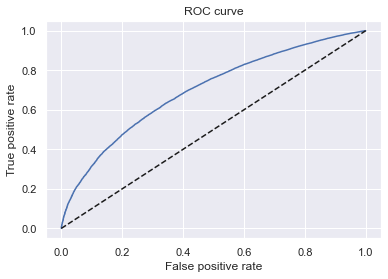

In [271]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [272]:
AUROC = roc_auc_score(df_actual_predicted_probs['df_target_test'], df_actual_predicted_probs['y_hat_test_proba'])
AUROC

0.6981136179638683